In [10]:
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
    Trainer, TrainingArguments,
)
import warnings
warnings.filterwarnings('ignore')

# ==================== SETTINGS ====================
EPOCHS = 50                 # bump to 50 after smoke test
USE_CLASS_WEIGHTS = True   # weighted CE loss for imbalance
USE_OVERSAMPLING = True    # oversample minority class in train

DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"

# Global history to store results from all models
all_models_history = {}
final_test_metrics = {}

# ==================== FINANCIAL TEXT PREPROCESSING ====================
def preprocess_financial_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    financial_abbreviations = {
        'EPS': 'earnings per share',
        'EBITDA': 'earnings before interest taxes depreciation amortization',
        'CEO': 'chief executive officer',
        'CFO': 'chief financial officer',
        'IPO': 'initial public offering',
        'M&A': 'mergers acquisitions',
        'ROI': 'return on investment',
        'ROE': 'return on equity',
        'P/E': 'price to earnings ratio',
        'GDP': 'gross domestic product',
        'USD': 'US dollars',
        'EUR': 'euros',
        'GBP': 'british pounds',
        'FY': 'fiscal year',
        'Q1': 'first quarter',
        'Q2': 'second quarter',
        'Q3': 'third quarter',
        'Q4': 'fourth quarter'
    }
    for abbr, full in financial_abbreviations.items():
        pattern = r'(?<!\w)' + re.escape(abbr) + r'(?!\w)'
        text = re.sub(pattern, full, text)
    text = re.sub(r'\$([\d.,]+)', r'\1 dollars', text)
    text = re.sub(r'€([\d.,]+)', r'\1 euros', text)
    text = re.sub(r'£([\d.,]+)', r'\1 pounds', text)
    text = re.sub(r'([\d.,]+)\s*%', r'\1 percent', text)
    text = re.sub(r'[^\w\s\$\%\.\:\-\+]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ==================== DATA LOADING AND PREPROCESSING ====================
def load_and_preprocess_data():
    print("Loading and preprocessing data...")
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    # Detect id_vars & year columns
    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    # Melt
    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)

    # Make numeric for pivot
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    # Pivot back to wide
    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    # Find target column robustly
    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        candidates = [c for c in df.columns if re.search(
            r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not candidates:
            raise KeyError("Missing required column: 'Liquid assets to deposits and short term funding (%)'")
        target = candidates[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # Strat helper
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc) == 2 and vc.min() > 0) else 0
    return df

# ==================== BALANCING HELPERS ====================
def oversample_minority(train_df):
    counts = train_df['liquidity_risk'].value_counts()
    if counts.nunique() == 1:
        return train_df.reset_index(drop=True)
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    n_major = counts.max()
    minority = train_df[train_df['liquidity_risk'] == minority_class]
    majority = train_df[train_df['liquidity_risk'] == majority_class]
    minority_up = minority.sample(n=n_major, replace=True, random_state=42)
    balanced = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=42).reset_index(drop=True)
    print(f"Oversampled minority class {minority_class}: {len(minority)} -> {len(minority_up)}")
    return balanced

def make_class_weights(train_df, num_labels=2):
    counts = train_df['liquidity_risk'].value_counts().sort_index()
    total = counts.sum()
    weights = total / (num_labels * counts.reindex(range(num_labels), fill_value=1))
    weights = weights / weights.mean()
    return torch.tensor(weights.values, dtype=torch.float)

# ==================== MODEL BUILD ====================
def build_model_and_tokenizer(model_name, model_display_name):
    print(f"Loading {model_display_name} tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    # Robust pad token handling
    pad_added = False
    if tokenizer.pad_token_id is None:
        if tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        elif tokenizer.sep_token is not None:
            tokenizer.pad_token = tokenizer.sep_token
        else:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            pad_added = True

    # Config with safe dropout settings across architectures
    config = AutoConfig.from_pretrained(model_name, num_labels=2, problem_type="single_label_classification")
    for attr, val in [
        ("hidden_dropout_prob", 0.1),
        ("attention_probs_dropout_prob", 0.1),
        ("classifier_dropout", 0.1),
        ("dropout", 0.1),
        ("attention_dropout", 0.1),
    ]:
        if hasattr(config, attr):
            setattr(config, attr, val)

    # Allow head re-init for mismatched label dims (FinBERT 3->2)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, config=config, ignore_mismatched_sizes=True
    )

    if model.config.pad_token_id is None and tokenizer.pad_token_id is not None:
        model.config.pad_token_id = tokenizer.pad_token_id

    if pad_added:
        model.resize_token_embeddings(len(tokenizer))

    return tokenizer, model

# ==================== WEIGHTED TRAINER ====================
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # Accept extra args from newer HF versions (e.g., num_items_in_batch)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ==================== TRAINING ====================
def train_transformer_model(model_name, model_display_name):
    print(f"\n{'='*60}\nTRAINING {model_display_name.upper()} MODEL\n{'='*60}")
    df = load_and_preprocess_data()

    # Build text column
    if "finbert" in model_name.lower():
        print("Applying financial text preprocessing for FinBERT...")
        df["processed_text"] = df.apply(
            lambda row: preprocess_financial_text(" ".join(
                f"{col}:{val}" for col, val in row.items()
                if pd.notna(val) and col not in ['liquidity_risk', '_strat']
            )),
            axis=1
        )
        text_column = "processed_text"
    else:
        df["text_input"] = df.apply(
            lambda row: " ".join(
                f"{col}:{val}" for col, val in row.items()
                if pd.notna(val) and col not in ['liquidity_risk', '_strat']
            ),
            axis=1
        )
        text_column = "text_input"

    # Splits with safe stratification
    stratify_col = df["_strat"] if df["_strat"].nunique() > 1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=stratify_col)
    stratify_train = train_df["_strat"] if train_df["_strat"].nunique() > 1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=stratify_train)

    if USE_OVERSAMPLING:
        train_df = oversample_minority(train_df)

    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
    print(f"Class distribution - Train: {train_df['liquidity_risk'].value_counts().to_dict()}")
    print(f"Class distribution - Validation: {val_df['liquidity_risk'].value_counts().to_dict()}")
    print(f"Class distribution - Test: {test_df['liquidity_risk'].value_counts().to_dict()}")

    class LiquidityRiskDataset(torch.utils.data.Dataset):
        def __init__(self, texts, labels, tokenizer, max_len):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            text = str(self.texts[idx])
            label = self.labels[idx]
            enc = self.tokenizer(text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
            return {"input_ids": enc["input_ids"].squeeze(0),
                    "attention_mask": enc["attention_mask"].squeeze(0),
                    "labels": torch.tensor(label, dtype=torch.long)}

    tokenizer, model = build_model_and_tokenizer(model_name, model_display_name)

    train_dataset = LiquidityRiskDataset(train_df[text_column].values, train_df["liquidity_risk"].values, tokenizer, 256)
    val_dataset   = LiquidityRiskDataset(val_df[text_column].values,   val_df["liquidity_risk"].values,   tokenizer, 256)
    test_dataset  = LiquidityRiskDataset(test_df[text_column].values,  test_df["liquidity_risk"].values,  tokenizer, 256)

    training_args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/', '_')}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        logging_dir=f"./logs_{model_name.replace('/', '_')}",
        metric_for_best_model="f1",
        greater_is_better=True,
        load_best_model_at_end=True,
        save_total_limit=1,
        save_safetensors=True,
        report_to="none",
        gradient_accumulation_steps=2,
        warmup_steps=100,
        eval_accumulation_steps=1,
        dataloader_pin_memory=False,
        fp16=torch.cuda.is_available(),
    )

    def compute_metrics_transformers(eval_pred):
        logits, labels = eval_pred
        if isinstance(logits, tuple):
            logits = logits[0]
        preds = torch.argmax(torch.tensor(logits), dim=1).numpy()
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, zero_division=0, average='weighted'),
            "precision": precision_score(labels, preds, zero_division=0, average='weighted'),
            "recall": recall_score(labels, preds, zero_division=0, average='weighted')
        }

    class_weights = make_class_weights(train_df) if USE_CLASS_WEIGHTS else None
    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_transformers
    )

    # Train
    print(f"Starting training for {model_display_name}...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    print(f"{model_display_name} training completed in {training_time:.2f} seconds")

    # Epoch-wise history
    logs = trainer.state.log_history
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    eval_by_epoch, train_loss_by_epoch = {}, {}
    for log in logs:
        if 'eval_loss' in log and 'epoch' in log:
            ep = int(round(log['epoch']))
            eval_by_epoch[ep] = {
                'val_loss': log.get('eval_loss'),
                'val_accuracy': log.get('eval_accuracy'),
                'val_f1': log.get('eval_f1'),
                'val_precision': log.get('eval_precision'),
                'val_recall': log.get('eval_recall'),
            }
        if 'loss' in log and 'epoch' in log:
            ep = int(round(log['epoch']))
            train_loss_by_epoch[ep] = log['loss']
    max_ep = max(list(eval_by_epoch.keys()) + list(train_loss_by_epoch.keys())) if (eval_by_epoch or train_loss_by_epoch) else 0
    for ep in range(1, max_ep + 1):
        history['epoch'].append(ep)
        history['train_loss'].append(train_loss_by_epoch.get(ep, float('nan')))
        ev = eval_by_epoch.get(ep, {})
        history['val_loss'].append(ev.get('val_loss', float('nan')))
        history['val_accuracy'].append(ev.get('val_accuracy', float('nan')))
        history['val_f1'].append(ev.get('val_f1', float('nan')))
        history['val_precision'].append(ev.get('val_precision', float('nan')))
        history['val_recall'].append(ev.get('val_recall', float('nan')))

    # ===== Confusion matrix + classification report =====
    print(f"Evaluating {model_display_name} on test set...")
    eval_results = trainer.evaluate(eval_dataset=test_dataset)

    preds_output = trainer.predict(test_dataset)
    y_true = preds_output.label_ids
    y_pred = preds_output.predictions.argmax(axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("\nConfusion Matrix [rows=true, cols=pred] (0=minority,1=majority):")
    print(cm)
    print("\nClassification Report (macro avg is useful on imbalance):")
    print(classification_report(y_true, y_pred, digits=4))

    # Plot & save CM
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f'{model_display_name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_display_name.lower()}.png', dpi=220)
    plt.close(fig)

    # Store metrics
    final_test_metrics[model_display_name] = {
        "accuracy": float(eval_results.get("eval_accuracy", 0)),
        "f1": float(eval_results.get("eval_f1", 0)),
        "precision": float(eval_results.get("eval_precision", 0)),
        "recall": float(eval_results.get("eval_recall", 0)),
        "loss": float(eval_results.get("eval_loss", 0)),
        "training_time": training_time
    }

    print(f"\n{model_display_name} Test Results:")
    print(f"Accuracy: {eval_results.get('eval_accuracy', 0):.4f}")
    print(f"F1 Score: {eval_results.get('eval_f1', 0):.4f}")
    print(f"Precision: {eval_results.get('eval_precision', 0):.4f}")
    print(f"Recall: {eval_results.get('eval_recall', 0):.4f}")
    print(f"Loss: {eval_results.get('eval_loss', 0):.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

    return history

# ==================== PLOTTING & SUMMARY ====================
def plot_comparison_graphs():
    print("\nGenerating enhanced comparison plots...")
    n_models = len(all_models_history)
    if n_models == 0:
        print("No models to plot!")
        return
    colors = {'BERT': '#FF6B6B', 'DistilBERT': '#4ECDC4', 'RoBERTa': '#45B7D1', 'FinBERT': '#FFA73F'}
    line_styles = {'BERT': '-', 'DistilBERT': '--', 'RoBERTa': '-.', 'FinBERT': ':'}
    markers = {'BERT': 'o', 'DistilBERT': 's', 'RoBERTa': '^', 'FinBERT': 'D'}
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    def plot_metric(ax, key, title, ylim=None):
        for model_name, history in all_models_history.items():
            if key in history and history[key]:
                epochs = list(range(1, len(history[key]) + 1))
                ax.plot(
                    epochs, history[key],
                    label=model_name,
                    color=colors.get(model_name, 'black'),
                    linestyle=line_styles.get(model_name, '-'),
                    marker=markers.get(model_name, 'o'),
                    markersize=6, linewidth=2.5
                )
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Epoch'); ax.set_ylabel(title.split()[-1])
        if ylim: ax.set_ylim(*ylim)
        ax.legend(); ax.grid(True, alpha=0.3)

    plot_metric(axes[0, 0], 'val_loss', 'Validation Loss', None)
    plot_metric(axes[0, 1], 'val_accuracy', 'Validation Accuracy', (0.7, 1.0))
    plot_metric(axes[0, 2], 'val_f1', 'Validation F1 Score', (0.7, 1.0))
    plot_metric(axes[1, 0], 'val_precision', 'Validation Precision', (0.7, 1.0))
    plot_metric(axes[1, 1], 'val_recall', 'Validation Recall', (0.7, 1.0))
    plot_metric(axes[1, 2], 'train_loss', 'Training Loss', None)

    plt.tight_layout()
    plt.savefig('transformer_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_performance_radar_chart():
    print("\nCreating radar chart for model comparison...")
    if not final_test_metrics:
        print("No test metrics available!")
        return
    models = list(final_test_metrics.keys())
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, polar=True)
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA73F']
    for i, model in enumerate(models):
        values = [final_test_metrics[model].get(metric, 0) for metric in metrics]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i % len(colors)])
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    ax.set_thetagrids(np.degrees(angles[:-1]), ['Accuracy', 'F1 Score', 'Precision', 'Recall'])
    ax.set_ylim(0.7, 1.0)
    ax.set_title('Transformer Models Performance Radar Chart', fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig('transformer_models_radar.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_final_summary():
    print("\n" + "="*80)
    print("FINAL TRANSFORMER MODELS COMPARISON SUMMARY")
    print("="*80)
    if not final_test_metrics:
        print("No models were successfully trained!")
        return
    summary_data = []
    for model_name, metrics in final_test_metrics.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics.get('accuracy', 0):.4f}",
            'F1 Score': f"{metrics.get('f1', 0):.4f}",
            'Precision': f"{metrics.get('precision', 0):.4f}",
            'Recall': f"{metrics.get('recall', 0):.4f}",
            'Loss': f"{metrics.get('loss', 0):.4f}",
            'Training Time (s)': f"{metrics.get('training_time', 0):.2f}"
        })
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

# ==================== MAIN ====================
def main():
    models_to_train = [
        ("yiyanghkust/finbert-tone", "FinBERT"),
        ("bert-base-uncased", "BERT"),
        ("distilbert-base-uncased", "DistilBERT"),
        ("roberta-base", "RoBERTa"),
        
    ]
    print("Starting training of transformer models...")
    print("Models to train: FinBERT,BERT, DistilBERT, RoBERTa")
    print("="*60)

    for model_name, display_name in models_to_train:
        try:
            print(f"\nStarting training for {display_name}...")
            history = train_transformer_model(model_name, display_name)
            if history is not None:
                all_models_history[display_name] = history
                print(f"✅ {display_name} training completed successfully!")
            else:
                print(f"❌ {display_name} training failed!")
        except Exception as e:
            print(f"❌ Error training {display_name}: {e}")

    plot_comparison_graphs()
    create_performance_radar_chart()
    print_final_summary()

    if final_test_metrics:
        best_model = max(final_test_metrics.items(), key=lambda x: x[1]['f1'])
        print(f"\n🎉 BEST PERFORMING MODEL: {best_model[0]}")
        print(f"   F1 Score: {best_model[1]['f1']:.4f}")
        print(f"   Accuracy: {best_model[1]['accuracy']:.4f}")

if __name__ == "__main__":
    main()


Starting training of transformer models...
Models to train: FinBERT,BERT, DistilBERT, RoBERTa

Starting training for FinBERT...

TRAINING FINBERT MODEL
Loading and preprocessing data...
Applying financial text preprocessing for FinBERT...
Oversampled minority class 0: 150 -> 810
Train size: 1620, Validation size: 240, Test size: 301
Class distribution - Train: {1: 810, 0: 810}
Class distribution - Validation: {1: 203, 0: 37}
Class distribution - Test: {1: 254, 0: 47}
Loading FinBERT tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for FinBERT...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [1]:
# ========================= LSTM CLASSIFIER (COPY–PASTE–RUN) =========================
# Uses your exact Kaggle CSV path. Trains 50 epochs, saves best weights by macro-F1,
# tunes decision threshold on the validation set, and reports/plots test metrics.

import os, re, time, math, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)

# ------------------------- SETTINGS -------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"

SEED = 42
EPOCHS = 50
BATCH_SIZE = 64
LR = 2e-3
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_LEN = 256

USE_OVERSAMPLING = True  # oversample minority in train
# IMPORTANT: exclude the target feature from the text to avoid leakage
EXCLUDE_TARGET_FROM_TEXT = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_BEST_TO = "lstm_best.pt"
PRINT_EVERY = 1  # epochs

# ------------------------- SEEDING -------------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

# ------------------------- DATA LOADING -------------------------
def load_and_preprocess_data():
    print("Loading and preprocessing data...")
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    # Detect id vars & year columns
    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    # Melt
    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)

    # Make numeric for pivot
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    # Pivot back to wide
    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    # Find target column robustly
    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        candidates = [c for c in df.columns if re.search(
            r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not candidates:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = candidates[0]

    # Label
    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # Build serialized text input as "col:value" tokens
    exclude = {"liquidity_risk"}
    if EXCLUDE_TARGET_FROM_TEXT:
        exclude.add(target)

    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)

    df["text_input"] = df.apply(row_to_text, axis=1)

    # Safe strat col
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc) == 2 and vc.min() > 0) else 0
    return df, target

def oversample_minority(train_df):
    counts = train_df['liquidity_risk'].value_counts()
    if counts.nunique() == 1:
        return train_df.reset_index(drop=True)
    maj = counts.idxmax()
    minc = counts.idxmin()
    n_major = counts.max()
    minority = train_df[train_df['liquidity_risk'] == minc]
    majority = train_df[train_df['liquidity_risk'] == maj]
    minority_up = minority.sample(n=n_major, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

# ------------------------- TOKENIZER / VOCAB -------------------------
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, min_freq=1, max_size=50000):
    from collections import Counter
    counter = Counter()
    for t in texts:
        counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq: break
        if len(vocab) >= max_size: break
        if tok not in (PAD, UNK):
            vocab.append(tok)
    itos = vocab
    stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi, max_len=MAX_LEN):
    toks = str(text).split()
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks[:max_len]]
    if len(ids) < max_len:
        ids = ids + [stoi[PAD]]*(max_len - len(ids))
    return np.array(ids, dtype=np.int64)

# ------------------------- DATASET -------------------------
class TextClsDS(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = texts
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        x = numericalize(self.texts[idx], self.stoi)
        y = self.labels[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

# ------------------------- MODEL -------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0
        )
        feat_dim = hidden_size * (2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, 2)

    def forward(self, x):
        emb = self.embedding(x)                # [B, T, E]
        out, (h, c) = self.lstm(emb)           # h: [num_layers*dir, B, H]
        # Use last hidden state from both directions
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)  # [B, 2H]
        else:
            h_last = h[-1]                              # [B, H]
        z = self.dropout(h_last)
        logits = self.fc(z)                    # [B, 2]
        return logits

# ------------------------- METRICS & UTILS -------------------------
@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs, labels = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        p = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        probs.append(p); labels.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate(model, loader, threshold=0.5):
    probs, y_true = predict_proba(model, loader)
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    bal = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {"accuracy":acc,"f1_weighted":f1_w,"f1_macro":f1_m,"precision":prec,"recall":rec,"balanced_acc":bal,"cm":cm}, probs

def tune_threshold(model, val_loader):
    probs, y_true = predict_proba(model, val_loader)
    best_t, best_score = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        y_pred = (probs >= t).astype(int)
        s = f1_score(y_true, y_pred, average='macro', zero_division=0)
        if s > best_score:
            best_score, best_t = s, t
    return best_t, best_score

def plot_confusion_matrix(cm, title, fname):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout()
    plt.savefig(fname, dpi=220); plt.close(fig)

# ------------------------- TRAINER -------------------------
def train_lstm():
    df, target_col = load_and_preprocess_data()

    # Splits
    strat = df["_strat"] if df["_strat"].nunique() > 1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique() > 1 else None
    train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    # Save pre-oversample counts for class weights
    pre_counts = train_df["liquidity_risk"].value_counts().sort_index()
    if USE_OVERSAMPLING:
        train_df = oversample_minority(train_df)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class distribution - Train:", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Val:",   val_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Test:",  test_df["liquidity_risk"].value_counts().to_dict())

    # Build vocab on train only
    stoi, itos = build_vocab(train_df["text_input"].values, min_freq=1, max_size=50000)
    pad_idx = stoi[PAD]

    # Datasets & loaders
    tr_ds = TextClsDS(train_df["text_input"].values, train_df["liquidity_risk"].values, stoi)
    va_ds = TextClsDS(val_df["text_input"].values,   val_df["liquidity_risk"].values,   stoi)
    te_ds = TextClsDS(test_df["text_input"].values,  test_df["liquidity_risk"].values,  stoi)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    te_loader = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Model
    model = LSTMClassifier(
        vocab_size=len(itos), embed_dim=EMBED_DIM,
        hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
        bidir=BIDIRECTIONAL, dropout=DROPOUT, pad_idx=pad_idx
    ).to(DEVICE)

    # Class weights from pre-oversample
    cw = pre_counts.reindex([0,1], fill_value=1)
    total = cw.sum()
    class_weights = (total / (2*cw)).values
    class_weights = class_weights / class_weights.mean()
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

    crit = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=LR, steps_per_epoch=max(1,len(tr_loader)), epochs=EPOCHS, pct_start=0.1
    )

    best_macro_f1 = -1
    best_state = None
    hist = {"epoch": [], "train_loss": [], "val_f1_macro": [], "val_loss": []}

    print("\nStarting LSTM training...")
    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            scheduler.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(tr_loader.dataset)

        # Validation
        model.eval()
        v_losses = []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                v_losses.append(crit(logits, yb).item()*xb.size(0))
        val_loss = sum(v_losses)/len(va_loader.dataset)

        # Threshold from val probs (macro-F1)
        t_val, f1m_val = tune_threshold(model, va_loader)

        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_f1_macro"].append(f1m_val)

        if epoch % PRINT_EVERY == 0:
            print(f"Epoch {epoch:02d}/{EPOCHS} | TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | ValF1_macro {f1m_val:.4f} | Thr {t_val:.2f}")

        # Save best by macro-F1
        if f1m_val > best_macro_f1:
            best_macro_f1 = f1m_val
            best_state = {
                "model": model.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "threshold": float(t_val),
                "epoch": epoch,
                "val_f1_macro": float(f1m_val)
            }
            torch.save(best_state, SAVE_BEST_TO)

    print(f"\nBest Val macro-F1: {best_macro_f1:.4f}. Weights saved to {SAVE_BEST_TO}")

    # ----------- Evaluate best on TEST -----------
    checkpoint = torch.load(SAVE_BEST_TO, map_location=DEVICE)
    model.load_state_dict(checkpoint["model"])
    best_t = checkpoint["threshold"]

    test_metrics, _ = evaluate(model, te_loader, threshold=best_t)
    cm = test_metrics["cm"]

    print("\nEvaluating LSTM on test set...")
    print(f"Threshold used: {best_t:.2f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1 (weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"F1 (macro):    {test_metrics['f1_macro']:.4f}")
    print(f"Precision:     {test_metrics['precision']:.4f}")
    print(f"Recall:        {test_metrics['recall']:.4f}")
    print(f"Balanced Acc:  {test_metrics['balanced_acc']:.4f}")
    print("\nConfusion Matrix [rows=true, cols=pred] (0,1):")
    print(cm)

    # Full classification report with selected threshold
    # Recompute for report
    probs, y_true = predict_proba(model, te_loader)
    y_pred = (probs >= best_t).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Save artifacts
    plot_confusion_matrix(cm, "LSTM Confusion Matrix", "confusion_matrix_lstm.png")
    with open("lstm_test_metrics.json","w") as f:
        json.dump({k: (v.tolist() if hasattr(v, "tolist") else v) for k,v in test_metrics.items()}, f, indent=2)

    # Plot training curves
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax1.plot(hist["epoch"], hist["train_loss"], label="Train Loss")
    ax1.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("lstm_training_curves.png", dpi=220); plt.close(fig)

    fig, ax2 = plt.subplots(figsize=(8,5))
    ax2.plot(hist["epoch"], hist["val_f1_macro"], label="Val F1-macro")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("F1-macro"); ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("lstm_val_f1_macro.png", dpi=220); plt.close(fig)

if __name__ == "__main__":
    print("DEVICE:", DEVICE)
    train_lstm()
# ========================= END LSTM =========================


DEVICE: cuda
Loading and preprocessing data...
Oversampled minority class 0: 150 -> 810
Train size: 1620, Val size: 240, Test size: 301
Class distribution - Train: {1: 810, 0: 810}
Class distribution - Val: {1: 203, 0: 37}
Class distribution - Test: {1: 254, 0: 47}

Starting LSTM training...
Epoch 01/50 | TrainLoss 0.5646 | ValLoss 0.9481 | ValF1_macro 0.5650 | Thr 0.18
Epoch 02/50 | TrainLoss 0.4474 | ValLoss 0.9232 | ValF1_macro 0.6111 | Thr 0.19
Epoch 03/50 | TrainLoss 0.3954 | ValLoss 0.8378 | ValF1_macro 0.6638 | Thr 0.14
Epoch 04/50 | TrainLoss 0.2049 | ValLoss 0.5092 | ValF1_macro 0.8088 | Thr 0.22
Epoch 05/50 | TrainLoss 0.1051 | ValLoss 0.6058 | ValF1_macro 0.8243 | Thr 0.10
Epoch 06/50 | TrainLoss 0.0603 | ValLoss 0.8082 | ValF1_macro 0.8144 | Thr 0.74
Epoch 07/50 | TrainLoss 0.0321 | ValLoss 0.6555 | ValF1_macro 0.8622 | Thr 0.17
Epoch 08/50 | TrainLoss 0.0120 | ValLoss 0.8020 | ValF1_macro 0.8287 | Thr 0.07
Epoch 09/50 | TrainLoss 0.0019 | ValLoss 0.8391 | ValF1_macro 0.837

<ipython-input-1-ac8e789356d1>:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_BEST_TO, map_location=DEVICE)



Evaluating LSTM on test set...
Threshold used: 0.17
Accuracy: 0.9203
F1 (weighted): 0.9196
F1 (macro):    0.8460
Precision:     0.9190
Recall:        0.9203
Balanced Acc:  0.8400

Confusion Matrix [rows=true, cols=pred] (0,1):
[[ 34  13]
 [ 11 243]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7556    0.7234    0.7391        47
           1     0.9492    0.9567    0.9529       254

    accuracy                         0.9203       301
   macro avg     0.8524    0.8400    0.8460       301
weighted avg     0.9190    0.9203    0.9196       301



In [2]:
# ========================= KD: RoBERTa (Teacher) -> LSTM (Student) =========================
# Copy–paste–run on Kaggle. Uses your exact CSV path. No target leakage.

import os, re, time, json, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
                          Trainer, TrainingArguments)

# ------------------------- SETTINGS -------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Teacher (RoBERTa)
TEACHER_MODEL_NAME = "roberta-base"
TEACHER_EPOCHS = 10            # fast teacher fit; increase if needed
TEACHER_MAX_LEN = 256
TEACHER_BATCH_TRAIN = 8
TEACHER_BATCH_EVAL = 16
TEACHER_LR = 2e-5
TEACHER_OUTDIR = "./kd_teacher_roberta"
TEACHER_LOAD_DIR = None        # e.g., "./results_roberta-base" to load an existing finetuned teacher; else None to train now

# Student (LSTM)
EPOCHS_STUDENT = 50
BATCH_SIZE = 64
LR_STUDENT = 2e-3
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_LEN = 256
SAVE_STUDENT_TO = "lstm_kd_best.pt"

# Distillation
TAU = 4.0                      # temperature
ALPHA = 0.5                    # α for CE; (1-α) for KD
USE_OVERSAMPLING = True
EXCLUDE_TARGET_FROM_TEXT = True

# ------------------------- SEEDING -------------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

# ------------------------- DATA LOADING -------------------------
def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    # Melt → clean years → numeric values
    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    # Pivot back to wide
    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    # Target
    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        cands = [c for c in df.columns if re.search(r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not cands:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = cands[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # Build serialized text input
    exclude = {"liquidity_risk"}
    if EXCLUDE_TARGET_FROM_TEXT:
        exclude.add(target)
    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)
    df["text_input"] = df.apply(row_to_text, axis=1)

    # Safe strat
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc)==2 and vc.min()>0) else 0
    return df, target

def oversample_minority(df):
    counts = df['liquidity_risk'].value_counts()
    if counts.nunique()==1:
        return df.reset_index(drop=True)
    maj = counts.idxmax(); minc = counts.idxmin()
    n_major = counts.max()
    minority = df[df['liquidity_risk']==minc]
    majority = df[df['liquidity_risk']==maj]
    minority_up = minority.sample(n=n_major, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

# ------------------------- VOCAB FOR LSTM -------------------------
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, min_freq=1, max_size=50000):
    from collections import Counter
    counter = Counter()
    for t in texts:
        counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_size: break
        if tok not in (PAD, UNK): vocab.append(tok)
    itos = vocab; stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi, max_len=MAX_LEN):
    toks = str(text).split()
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks[:max_len]]
    if len(ids) < max_len:
        ids += [stoi[PAD]]*(max_len - len(ids))
    return np.array(ids, dtype=np.int64)

# ------------------------- DATASETS -------------------------
class KDTrainDataset(Dataset):
    """Provides BOTH student indices and teacher-tokenized inputs."""
    def __init__(self, texts, labels, stoi, tokenizer, max_len_teacher):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
        self.tok = tokenizer
        self.max_len_teacher = max_len_teacher
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        t = self.texts[idx]
        s_ids = numericalize(t, self.stoi)
        enc = self.tok(t, max_length=self.max_len_teacher, padding="max_length", truncation=True, return_tensors="pt")
        item = {
            "x_student": torch.from_numpy(s_ids),
            "y": torch.tensor(self.labels[idx], dtype=torch.long),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }
        return item

class PlainTextDataset(Dataset):
    """Student-only dataset for val/test (no teacher forward needed)."""
    def __init__(self, texts, labels, stoi):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        x = numericalize(self.texts[idx], self.stoi)
        y = self.labels[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

# ------------------------- MODELS -------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0)
        feat = hidden_size*(2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat, 2)
    def forward(self, x):
        emb = self.embedding(x)              # [B,T,E]
        out, (h, c) = self.lstm(emb)
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_last = h[-1]
        z = self.dropout(h_last)
        return self.fc(z)

# ------------------------- METRICS & UTILS -------------------------
@torch.no_grad()
def predict_proba_student(model, loader):
    model.eval()
    probs, labels = [], []
    for batch in loader:
        if isinstance(batch, dict):
            xb, yb = batch["x_student"].to(DEVICE), batch["y"].to(DEVICE)
        else:
            xb, yb = batch[0].to(DEVICE), batch[1].to(DEVICE)
        logits = model(xb)
        p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.append(p); labels.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate_student(model, loader, threshold=0.5):
    probs, y_true = predict_proba_student(model, loader)
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    bal = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {"accuracy":acc,"f1_weighted":f1w,"f1_macro":f1m,"precision":prec,"recall":rec,"balanced_acc":bal,"cm":cm}, probs

def tune_threshold_student(model, val_loader):
    probs, y_true = predict_proba_student(model, val_loader)
    best_t, best_score = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        y_pred = (probs >= t).astype(int)
        s = f1_score(y_true, y_pred, average='macro', zero_division=0)
        if s > best_score:
            best_score, best_t = s, t
    return best_t, best_score

def plot_cm(cm, title, fname):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout(); plt.savefig(fname, dpi=220); plt.close(fig)

# ------------------------- HF TRAINER PATCH -------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ------------------------- TEACHER TRAIN/LOAD -------------------------
def make_class_weights(train_df):
    counts = train_df['liquidity_risk'].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values
    return torch.tensor(w, dtype=torch.float32)

def train_or_load_teacher(train_df, val_df, test_df, text_col="text_input"):
    tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)
    config = AutoConfig.from_pretrained(TEACHER_MODEL_NAME, num_labels=2, problem_type="single_label_classification")
    model = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_NAME, config=config)

    # dataset wrapper for HF
    class TxtDS(torch.utils.data.Dataset):
        def __init__(self, df):
            self.texts = df[text_col].tolist()
            self.labels = df["liquidity_risk"].astype(int).tolist()
        def __len__(self): return len(self.texts)
        def __getitem__(self, i):
            enc = tokenizer(self.texts[i], max_length=TEACHER_MAX_LEN, padding="max_length", truncation=True, return_tensors="pt")
            return {"input_ids": enc["input_ids"].squeeze(0),
                    "attention_mask": enc["attention_mask"].squeeze(0),
                    "labels": torch.tensor(self.labels[i], dtype=torch.long)}

    if TEACHER_LOAD_DIR and os.path.isdir(TEACHER_LOAD_DIR):
        print(f"Loading teacher from {TEACHER_LOAD_DIR}")
        model = AutoModelForSequenceClassification.from_pretrained(TEACHER_LOAD_DIR)
    else:
        print("Training teacher (RoBERTa)...")
        train_use = oversample_minority(train_df) if USE_OVERSAMPLING else train_df
        class_weights = make_class_weights(train_df)  # pre-oversample weights
        tr, va = TxtDS(train_use), TxtDS(val_df)

        args = TrainingArguments(
            output_dir=TEACHER_OUTDIR,
            evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
            learning_rate=TEACHER_LR,
            per_device_train_batch_size=TEACHER_BATCH_TRAIN,
            per_device_eval_batch_size=TEACHER_BATCH_EVAL,
            num_train_epochs=TEACHER_EPOCHS, weight_decay=0.01,
            load_best_model_at_end=True, metric_for_best_model="f1_macro", greater_is_better=True,
            save_total_limit=1, report_to="none", fp16=torch.cuda.is_available()
        )

        def metrics_fn(eval_pred):
            logits, labels = eval_pred
            preds = logits.argmax(axis=1)
            return {
                "accuracy": accuracy_score(labels, preds),
                "f1": f1_score(labels, preds, average='weighted', zero_division=0),
                "f1_macro": f1_score(labels, preds, average='macro', zero_division=0)
            }

        trainer = WeightedTrainer(
            class_weights=class_weights, model=model, args=args,
            train_dataset=tr, eval_dataset=va, tokenizer=tokenizer, compute_metrics=metrics_fn
        )
        trainer.train()
        model = trainer.model  # best

    # Evaluate teacher
    model.eval(); model.to(DEVICE)
    @torch.no_grad()
    def eval_split(df):
        ds = TxtDS(df)
        loader = DataLoader(ds, batch_size=TEACHER_BATCH_EVAL, shuffle=False)
        probs, labels = [], []
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attn = batch["attention_mask"].to(DEVICE)
            logits = model(input_ids=input_ids, attention_mask=attn).logits
            p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            probs.append(p); labels.append(batch["labels"].numpy())
        probs = np.concatenate(probs); labels = np.concatenate(labels)
        # tune threshold for teacher too (macro-F1)
        best_t, best_f1 = 0.5, -1
        for t in np.linspace(0.05, 0.95, 181):
            f1m = f1_score(labels, (probs>=t).astype(int), average='macro', zero_division=0)
            if f1m > best_f1: best_f1, best_t = f1m, t
        y_pred = (probs>=best_t).astype(int)
        m = {
            "accuracy": accuracy_score(labels, y_pred),
            "f1_weighted": f1_score(labels, y_pred, average='weighted', zero_division=0),
            "f1_macro": f1_score(labels, y_pred, average='macro', zero_division=0),
            "precision": precision_score(labels, y_pred, average='weighted', zero_division=0),
            "recall": recall_score(labels, y_pred, average='weighted', zero_division=0),
            "balanced_acc": balanced_accuracy_score(labels, y_pred),
            "threshold": best_t,
            "cm": confusion_matrix(labels, y_pred, labels=[0,1])
        }
        return m, probs, labels

    print("Evaluating teacher...")
    teach_val_metrics, _, _ = eval_split(val_df)
    teach_test_metrics, teacher_test_probs, teacher_test_labels = eval_split(test_df)
    print("\n[Teacher] Test metrics:")
    for k,v in teach_test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", teach_test_metrics["cm"])

    return tokenizer, model, teach_test_metrics

# ------------------------- KD TRAIN STUDENT -------------------------
def train_student_kd(df_train, df_val, df_test, teacher_tok, teacher_model):
    # Build vocab on train
    stoi, itos = build_vocab(df_train["text_input"].values, max_size=50000)
    pad_idx = stoi[PAD]

    # Keep pre-oversample counts for CE weights
    pre_counts = df_train["liquidity_risk"].value_counts().sort_index()
    if USE_OVERSAMPLING:
        df_train = oversample_minority(df_train)

    # Datasets
    kd_train = KDTrainDataset(df_train["text_input"].values, df_train["liquidity_risk"].values,
                              stoi, teacher_tok, TEACHER_MAX_LEN)
    val_ds = PlainTextDataset(df_val["text_input"].values, df_val["liquidity_risk"].values, stoi)
    test_ds= PlainTextDataset(df_test["text_input"].values, df_test["liquidity_risk"].values, stoi)

    train_loader = DataLoader(kd_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Student model
    student = LSTMClassifier(
        vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS, bidir=BIDIRECTIONAL, dropout=DROPOUT, pad_idx=pad_idx
    ).to(DEVICE)

    # Losses/opt
    cw = pre_counts.reindex([0,1], fill_value=1).astype(float)
    total = cw.sum()
    ce_weights = (total/(2*cw)).values
    ce_weights = ce_weights/ce_weights.mean()
    ce_weights = torch.tensor(ce_weights, dtype=torch.float32).to(DEVICE)
    ce_loss = nn.CrossEntropyLoss(weight=ce_weights)
    kd_loss = nn.KLDivLoss(reduction="batchmean")

    opt = torch.optim.Adam(student.parameters(), lr=LR_STUDENT)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=LR_STUDENT, steps_per_epoch=max(1,len(train_loader)), epochs=EPOCHS_STUDENT, pct_start=0.1
    )

    # Freeze teacher
    teacher_model.eval(); 
    for p in teacher_model.parameters(): p.requires_grad=False
    teacher_model.to(DEVICE)

    best_macro_f1, best_state = -1, None

    print("\nStarting KD training (teacher: RoBERTa → student: LSTM)")
    for epoch in range(1, EPOCHS_STUDENT+1):
        student.train()
        run_loss = 0.0
        for batch in train_loader:
            xb = batch["x_student"].to(DEVICE)
            yb = batch["y"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attn = batch["attention_mask"].to(DEVICE)

            # Forward
            with torch.no_grad():
                t_logits = teacher_model(input_ids=input_ids, attention_mask=attn).logits

            s_logits = student(xb)

            # KD term
            log_p_s = torch.log_softmax(s_logits/TAU, dim=1)
            p_t = torch.softmax(t_logits/TAU, dim=1)
            loss_kd = kd_loss(log_p_s, p_t) * (TAU*TAU)

            # CE term
            loss_ce = ce_loss(s_logits, yb)

            loss = ALPHA*loss_ce + (1-ALPHA)*loss_kd

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            opt.step()
            sched.step()
            run_loss += loss.item()*xb.size(0)

        train_loss = run_loss/len(train_loader.dataset)

        # Validate with tuned threshold (macro-F1)
        t_val, f1m_val = tune_threshold_student(student, val_loader)

        if epoch%1==0:
            print(f"Epoch {epoch:02d}/{EPOCHS_STUDENT} | TrainLoss {train_loss:.4f} | Val F1_macro {f1m_val:.4f} | Thr {t_val:.2f}")

        if f1m_val>best_macro_f1:
            best_macro_f1=f1m_val
            best_state={
                "model": student.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "threshold": float(t_val),
                "epoch": epoch,
                "val_f1_macro": float(f1m_val),
                "alpha": ALPHA, "tau": TAU
            }
            torch.save(best_state, SAVE_STUDENT_TO)

    print(f"\nBest Val macro-F1 (KD student): {best_macro_f1:.4f}. Saved to {SAVE_STUDENT_TO}")

    # Evaluate best on TEST
    checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE)
    student.load_state_dict(checkpoint["model"])
    best_t = checkpoint["threshold"]

    test_metrics, _ = evaluate_student(student, test_loader, threshold=best_t)
    print("\n[Student (KD)] Test metrics:")
    for k,v in test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", test_metrics["cm"])

    plot_cm(test_metrics["cm"], "LSTM KD Confusion Matrix", "confusion_matrix_lstm_kd.png")
    with open("lstm_kd_test_metrics.json","w") as f:
        json.dump({k:(v.tolist() if hasattr(v,'tolist') else v) for k,v in test_metrics.items()}, f, indent=2)

    return test_metrics

# ------------------------- MAIN -------------------------
def main():
    print("DEVICE:", DEVICE)
    df, target = load_and_preprocess_data()

    # Splits
    strat = df["_strat"] if df["_strat"].nunique()>1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class distribution - Train:", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Val:",   val_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Test:",  test_df["liquidity_risk"].value_counts().to_dict())

    # Teacher
    teacher_tok, teacher_model, teacher_test_metrics = train_or_load_teacher(train_df, val_df, test_df)

    # Student with KD
    student_kd_metrics = train_student_kd(train_df.copy(), val_df.copy(), test_df.copy(), teacher_tok, teacher_model)

    print("\n===== SUMMARY =====")
    print("[Teacher: RoBERTa] Test ->",
          {k:round(v,4) for k,v in teacher_test_metrics.items() if k!='cm'})
    print("[Student: LSTM KD] Test ->",
          {k:round(v,4) for k,v in student_kd_metrics.items() if k!='cm'})

if __name__ == "__main__":
    main()
# ========================= END KD SCRIPT =========================


DEVICE: cuda
Train size: 960, Val size: 240, Test size: 301
Class distribution - Train: {1: 810, 0: 150}
Class distribution - Val: {1: 203, 0: 37}
Class distribution - Test: {1: 254, 0: 47}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-2-fc80b5d1a0a5>:247: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Training teacher (RoBERTa)...
Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.453600,1.039380,0.154167,0.041185,0.133574
2,0.326900,0.485159,0.837500,0.851886,0.748055
3,0.208700,0.702851,0.841667,0.852493,0.740171
4,0.157800,0.788365,0.858333,0.867073,0.763451
5,0.141300,0.815803,0.862500,0.872339,0.776265
6,0.134300,0.977562,0.858333,0.867073,0.763451
7,0.162600,1.357531,0.870833,0.875282,0.769795
8,0.144400,1.559377,0.866667,0.874892,0.777365
9,0.127500,1.897751,0.870833,0.877393,0.778407
10,0.109600,2.123398,0.875000,0.878750,0.775000


Evaluating teacher...

[Teacher] Test metrics:
accuracy: 0.8870
f1_weighted: 0.8913
f1_macro: 0.8024
precision: 0.8982
recall: 0.8870
balanced_acc: 0.8290
threshold: 0.0500
Confusion Matrix:
 [[ 35  12]
 [ 22 232]]
Oversampled minority class 0: 150 -> 810

Starting KD training (teacher: RoBERTa → student: LSTM)
Epoch 01/50 | TrainLoss 3.9689 | Val F1_macro 0.6175 | Thr 0.27
Epoch 02/50 | TrainLoss 3.7852 | Val F1_macro 0.6431 | Thr 0.19
Epoch 03/50 | TrainLoss 2.9547 | Val F1_macro 0.7266 | Thr 0.05
Epoch 04/50 | TrainLoss 1.1288 | Val F1_macro 0.7862 | Thr 0.12
Epoch 05/50 | TrainLoss 0.5062 | Val F1_macro 0.7867 | Thr 0.05
Epoch 06/50 | TrainLoss 0.3504 | Val F1_macro 0.8142 | Thr 0.05
Epoch 07/50 | TrainLoss 0.2186 | Val F1_macro 0.8039 | Thr 0.05
Epoch 08/50 | TrainLoss 0.1622 | Val F1_macro 0.8243 | Thr 0.05
Epoch 09/50 | TrainLoss 0.1187 | Val F1_macro 0.7954 | Thr 0.10
Epoch 10/50 | TrainLoss 0.0941 | Val F1_macro 0.7944 | Thr 0.10
Epoch 11/50 | TrainLoss 0.0792 | Val F1_macro 0

<ipython-input-2-fc80b5d1a0a5>:468: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE)



[Student (KD)] Test metrics:
accuracy: 0.8970
f1_weighted: 0.8913
f1_macro: 0.7834
precision: 0.8898
recall: 0.8970
balanced_acc: 0.7569
Confusion Matrix:
 [[ 26  21]
 [ 10 244]]

===== SUMMARY =====
[Teacher: RoBERTa] Test -> {'accuracy': 0.887, 'f1_weighted': 0.8913, 'f1_macro': 0.8024, 'precision': 0.8982, 'recall': 0.887, 'balanced_acc': 0.829, 'threshold': 0.05}
[Student: LSTM KD] Test -> {'accuracy': 0.897, 'f1_weighted': 0.8913, 'f1_macro': 0.7834, 'precision': 0.8898, 'recall': 0.897, 'balanced_acc': 0.7569}


In [3]:
# ========================= KD: RoBERTa (Teacher, 50e) -> LSTM (Student) =========================
# Copy–paste–run on Kaggle. Avoids target leakage in text; avoids test-threshold leakage.

import os, re, time, json, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
                          Trainer, TrainingArguments)

# ------------------------- SETTINGS -------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Teacher (RoBERTa)
TEACHER_MODEL_NAME = "roberta-base"
TEACHER_EPOCHS = 50            # <-- requested: 50 epochs
TEACHER_MAX_LEN = 256
TEACHER_BATCH_TRAIN = 8
TEACHER_BATCH_EVAL = 16
TEACHER_LR = 2e-5
TEACHER_OUTDIR = "./kd_teacher_roberta_50e"
TEACHER_LOAD_DIR = None        # set to a fine-tuned dir to skip training; else None

# Student (LSTM)
EPOCHS_STUDENT = 50
BATCH_SIZE = 64
LR_STUDENT = 2e-3
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_LEN = 256
SAVE_STUDENT_TO = "lstm_kd_best.pt"

# Distillation
TAU = 4.0                      # temperature
ALPHA = 0.5                    # α for CE; (1-α) for KD
USE_OVERSAMPLING = True
EXCLUDE_TARGET_FROM_TEXT = True

# ------------------------- SEEDING -------------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

# ------------------------- DATA LOADING -------------------------
def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    # Melt → clean years → numeric values
    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    # Pivot back to wide
    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    # Target
    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        cands = [c for c in df.columns if re.search(r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not cands:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = cands[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # Build serialized text input (no leakage)
    exclude = {"liquidity_risk"}
    if EXCLUDE_TARGET_FROM_TEXT:
        exclude.add(target)
    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)
    df["text_input"] = df.apply(row_to_text, axis=1)

    # Safe strat
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc)==2 and vc.min()>0) else 0
    return df, target

def oversample_minority(df):
    counts = df['liquidity_risk'].value_counts()
    if counts.nunique()==1:
        return df.reset_index(drop=True)
    maj = counts.idxmax(); minc = counts.idxmin()
    n_major = counts.max()
    minority = df[df['liquidity_risk']==minc]
    majority = df[df['liquidity_risk']==maj]
    minority_up = minority.sample(n=n_major, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

# ------------------------- VOCAB FOR LSTM -------------------------
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, min_freq=1, max_size=50000):
    from collections import Counter
    counter = Counter()
    for t in texts:
        counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_size: break
        if tok not in (PAD, UNK): vocab.append(tok)
    itos = vocab; stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi, max_len=MAX_LEN):
    toks = str(text).split()
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks[:max_len]]
    if len(ids) < max_len:
        ids += [stoi[PAD]]*(max_len - len(ids))
    return np.array(ids, dtype=np.int64)

# ------------------------- DATASETS -------------------------
class KDTrainDataset(Dataset):
    """Provides BOTH student indices and teacher-tokenized inputs."""
    def __init__(self, texts, labels, stoi, tokenizer, max_len_teacher):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
        self.tok = tokenizer
        self.max_len_teacher = max_len_teacher
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        t = self.texts[idx]
        s_ids = numericalize(t, self.stoi)
        enc = self.tok(t, max_length=self.max_len_teacher, padding="max_length", truncation=True, return_tensors="pt")
        item = {
            "x_student": torch.from_numpy(s_ids),
            "y": torch.tensor(self.labels[idx], dtype=torch.long),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }
        return item

class PlainTextDataset(Dataset):
    """Student-only dataset for val/test (no teacher forward needed)."""
    def __init__(self, texts, labels, stoi):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        x = numericalize(self.texts[idx], self.stoi)
        y = self.labels[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

# ------------------------- MODELS -------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0)
        feat = hidden_size*(2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat, 2)
    def forward(self, x):
        emb = self.embedding(x)              # [B,T,E]
        out, (h, c) = self.lstm(emb)
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_last = h[-1]
        z = self.dropout(h_last)
        return self.fc(z)

# ------------------------- METRICS & UTILS -------------------------
@torch.no_grad()
def predict_proba_student(model, loader):
    model.eval()
    probs, labels = [], []
    for batch in loader:
        if isinstance(batch, dict):
            xb, yb = batch["x_student"].to(DEVICE), batch["y"].to(DEVICE)
        else:
            xb, yb = batch[0].to(DEVICE), batch[1].to(DEVICE)
        logits = model(xb)
        p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.append(p); labels.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate_student(model, loader, threshold=0.5):
    probs, y_true = predict_proba_student(model, loader)
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    bal = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {"accuracy":acc,"f1_weighted":f1w,"f1_macro":f1m,"precision":prec,"recall":rec,"balanced_acc":bal,"cm":cm}, probs

def tune_threshold_student(model, val_loader):
    probs, y_true = predict_proba_student(model, val_loader)
    best_t, best_score = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        y_pred = (probs >= t).astype(int)
        s = f1_score(y_true, y_pred, average='macro', zero_division=0)
        if s > best_score:
            best_score, best_t = s, t
    return best_t, best_score

def plot_cm(cm, title, fname):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout(); plt.savefig(fname, dpi=220); plt.close(fig)

# ------------------------- HF TRAINER PATCH -------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ------------------------- TEACHER UTILS (NO THRESHOLD LEAKAGE) -------------------------
def make_class_weights(train_df):
    counts = train_df['liquidity_risk'].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values
    return torch.tensor(w, dtype=torch.float32)

def teacher_tokenizer_and_model():
    tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)
    config = AutoConfig.from_pretrained(TEACHER_MODEL_NAME, num_labels=2, problem_type="single_label_classification")
    model = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_NAME, config=config)
    return tokenizer, model

class TxtDS(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, text_col="text_input"):
        self.texts = df[text_col].tolist()
        self.labels = df["liquidity_risk"].astype(int).tolist()
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(0),
                "attention_mask": enc["attention_mask"].squeeze(0),
                "labels": torch.tensor(self.labels[i], dtype=torch.long)}

@torch.no_grad()
def teacher_probs(df, tokenizer, model):
    ds = TxtDS(df, tokenizer, TEACHER_MAX_LEN)
    loader = DataLoader(ds, batch_size=TEACHER_BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    probs, labels = [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn).logits
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.append(p); labels.append(batch["labels"].numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate_teacher_with_val_threshold(val_df, test_df, tokenizer, model):
    # tune threshold ONLY on validation
    val_probs, val_y = teacher_probs(val_df, tokenizer, model)
    best_t, best_f1m = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        f1m = f1_score(val_y, (val_probs>=t).astype(int), average='macro', zero_division=0)
        if f1m > best_f1m:
            best_f1m, best_t = f1m, t

    # apply to test
    test_probs, test_y = teacher_probs(test_df, tokenizer, model)
    pred = (test_probs >= best_t).astype(int)
    m = {
        "accuracy": accuracy_score(test_y, pred),
        "f1_weighted": f1_score(test_y, pred, average='weighted', zero_division=0),
        "f1_macro": f1_score(test_y, pred, average='macro', zero_division=0),
        "precision": precision_score(test_y, pred, average='weighted', zero_division=0),
        "recall": recall_score(test_y, pred, average='weighted', zero_division=0),
        "balanced_acc": balanced_accuracy_score(test_y, pred),
        "threshold": best_t,
        "cm": confusion_matrix(test_y, pred, labels=[0,1])
    }
    return m

# ------------------------- TEACHER TRAIN/LOAD -------------------------
def train_or_load_teacher(train_df, val_df):
    tokenizer, model = teacher_tokenizer_and_model()

    if TEACHER_LOAD_DIR and os.path.isdir(TEACHER_LOAD_DIR):
        print(f"Loading teacher from {TEACHER_LOAD_DIR}")
        model = AutoModelForSequenceClassification.from_pretrained(TEACHER_LOAD_DIR)
        return tokenizer, model

    print("Training teacher (RoBERTa, 50 epochs)...")
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING else train_df
    class_weights = make_class_weights(train_df)  # pre-oversample weights
    tr = TxtDS(train_use, tokenizer, TEACHER_MAX_LEN)
    va = TxtDS(val_df, tokenizer, TEACHER_MAX_LEN)

    args = TrainingArguments(
        output_dir=TEACHER_OUTDIR,
        evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
        learning_rate=TEACHER_LR,
        per_device_train_batch_size=TEACHER_BATCH_TRAIN,
        per_device_eval_batch_size=TEACHER_BATCH_EVAL,
        num_train_epochs=TEACHER_EPOCHS, weight_decay=0.01,
        load_best_model_at_end=True, metric_for_best_model="f1_macro", greater_is_better=True,
        save_total_limit=1, report_to="none", fp16=torch.cuda.is_available()
    )

    def metrics_fn(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted', zero_division=0),
            "f1_macro": f1_score(labels, preds, average='macro', zero_division=0)
        }

    trainer = WeightedTrainer(
        class_weights=class_weights, model=model, args=args,
        train_dataset=tr, eval_dataset=va, tokenizer=tokenizer, compute_metrics=metrics_fn
    )
    trainer.train()
    model = trainer.model  # best
    return tokenizer, model

# ------------------------- KD TRAIN STUDENT -------------------------
def train_student_kd(df_train, df_val, df_test, teacher_tok, teacher_model):
    # Build vocab on train
    stoi, itos = build_vocab(df_train["text_input"].values, max_size=50000)
    pad_idx = stoi[PAD]

    # Keep pre-oversample counts for CE weights
    pre_counts = df_train["liquidity_risk"].value_counts().sort_index()
    if USE_OVERSAMPLING:
        df_train = oversample_minority(df_train)

    # Datasets
    kd_train = KDTrainDataset(df_train["text_input"].values, df_train["liquidity_risk"].values,
                              stoi, teacher_tok, TEACHER_MAX_LEN)
    val_ds = PlainTextDataset(df_val["text_input"].values, df_val["liquidity_risk"].values, stoi)
    test_ds= PlainTextDataset(df_test["text_input"].values, df_test["liquidity_risk"].values, stoi)

    train_loader = DataLoader(kd_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Student model
    student = LSTMClassifier(
        vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS, bidir=BIDIRECTIONAL, dropout=DROPOUT, pad_idx=pad_idx
    ).to(DEVICE)

    # Losses/opt
    cw = pre_counts.reindex([0,1], fill_value=1).astype(float)
    total = cw.sum()
    ce_weights = (total/(2*cw)).values
    ce_weights = ce_weights/ce_weights.mean()
    ce_weights = torch.tensor(ce_weights, dtype=torch.float32).to(DEVICE)
    ce_loss = nn.CrossEntropyLoss(weight=ce_weights)
    kd_loss = nn.KLDivLoss(reduction="batchmean")

    opt = torch.optim.Adam(student.parameters(), lr=LR_STUDENT)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=LR_STUDENT, steps_per_epoch=max(1,len(train_loader)), epochs=EPOCHS_STUDENT, pct_start=0.1
    )

    # Freeze teacher
    teacher_model.eval(); 
    for p in teacher_model.parameters(): p.requires_grad=False
    teacher_model.to(DEVICE)

    best_macro_f1, best_state = -1, None

    print("\nStarting KD training (teacher: RoBERTa → student: LSTM)")
    for epoch in range(1, EPOCHS_STUDENT+1):
        student.train()
        run_loss = 0.0
        for batch in train_loader:
            xb = batch["x_student"].to(DEVICE)
            yb = batch["y"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attn = batch["attention_mask"].to(DEVICE)

            # Forward
            with torch.no_grad():
                t_logits = teacher_model(input_ids=input_ids, attention_mask=attn).logits

            s_logits = student(xb)

            # KD term
            log_p_s = torch.log_softmax(s_logits/TAU, dim=1)
            p_t     = torch.softmax(t_logits/TAU, dim=1)
            loss_kd = kd_loss(log_p_s, p_t) * (TAU*TAU)

            # CE term
            loss_ce = ce_loss(s_logits, yb)

            loss = ALPHA*loss_ce + (1-ALPHA)*loss_kd

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            opt.step()
            sched.step()
            run_loss += loss.item()*xb.size(0)

        # Validation with tuned threshold (macro-F1) – tuned on val ONLY
        t_val, f1m_val = tune_threshold_student(student, val_loader)

        print(f"Epoch {epoch:02d}/{EPOCHS_STUDENT} | TrainLoss {run_loss/len(train_loader.dataset):.4f} | Val F1_macro {f1m_val:.4f} | Thr {t_val:.2f}")

        if f1m_val>best_macro_f1:
            best_macro_f1=f1m_val
            best_state={
                "model": student.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "threshold": float(t_val),
                "epoch": epoch,
                "val_f1_macro": float(f1m_val),
                "alpha": ALPHA, "tau": TAU
            }
            torch.save(best_state, SAVE_STUDENT_TO)

    print(f"\nBest Val macro-F1 (KD student): {best_macro_f1:.4f}. Saved to {SAVE_STUDENT_TO}")

    # Evaluate best on TEST using the val-tuned threshold
    try:
        checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE, weights_only=True)  # PyTorch 2.4+
    except TypeError:
        checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE)  # fallback for older torch
    student.load_state_dict(checkpoint["model"])
    best_t = checkpoint["threshold"]

    test_metrics, _ = evaluate_student(student, test_loader, threshold=best_t)
    print("\n[Student (KD)] Test metrics (val-tuned threshold):")
    for k,v in test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", test_metrics["cm"])

    plot_cm(test_metrics["cm"], "LSTM KD Confusion Matrix", "confusion_matrix_lstm_kd.png")
    with open("lstm_kd_test_metrics.json","w") as f:
        json.dump({k:(v.tolist() if hasattr(v,'tolist') else v) for k,v in test_metrics.items()}, f, indent=2)

    return test_metrics

# ------------------------- MAIN -------------------------
def main():
    print("DEVICE:", DEVICE)
    df, target = load_and_preprocess_data()

    # Splits
    strat = df["_strat"] if df["_strat"].nunique()>1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class distribution - Train:", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Val:",   val_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Test:",  test_df["liquidity_risk"].value_counts().to_dict())

    # Teacher
    tok, teacher_model = train_or_load_teacher(train_df, val_df)

    # Evaluate teacher with threshold tuned ONLY on validation
    teacher_test_metrics = evaluate_teacher_with_val_threshold(val_df, test_df, tok, teacher_model)
    print("\n[Teacher (RoBERTa, 50e)] Test metrics (val-tuned threshold):")
    for k,v in teacher_test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", teacher_test_metrics["cm"])

    # Student with KD
    student_kd_metrics = train_student_kd(train_df.copy(), val_df.copy(), test_df.copy(), tok, teacher_model)

    print("\n===== SUMMARY =====")
    print("[Teacher: RoBERTa 50e] Test ->",
          {k:round(v,4) for k,v in teacher_test_metrics.items() if k!='cm'})
    print("[Student: LSTM KD 50e] Test ->",
          {k:round(v,4) for k,v in student_kd_metrics.items() if k!='cm'})

if __name__ == "__main__":
    main()
# ========================= END KD SCRIPT =========================


DEVICE: cuda
Train size: 960, Val size: 240, Test size: 301
Class distribution - Train: {1: 810, 0: 150}
Class distribution - Val: {1: 203, 0: 37}
Class distribution - Test: {1: 254, 0: 47}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-3b5ed45ab2d8>:247: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Training teacher (RoBERTa, 50 epochs)...
Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.452300,0.831577,0.154167,0.041185,0.133574
2,0.318000,0.448881,0.870833,0.879241,0.786201
3,0.238500,0.542666,0.866667,0.874892,0.777365
4,0.186500,0.796254,0.866667,0.876617,0.784850
5,0.158200,0.587467,0.858333,0.866060,0.759178
6,0.155500,0.713410,0.862500,0.871450,0.772407
7,0.238000,1.100113,0.912500,0.912008,0.830366
8,0.153000,1.254545,0.900000,0.900000,0.808281
9,0.356700,2.617612,0.925000,0.920042,0.837740
10,0.282300,2.887632,0.920833,0.917369,0.835207



[Teacher (RoBERTa, 50e)] Test metrics (val-tuned threshold):
accuracy: 0.9103
f1_weighted: 0.9073
f1_macro: 0.8186
precision: 0.9060
recall: 0.9103
balanced_acc: 0.7995
threshold: 0.0500
Confusion Matrix:
 [[ 30  17]
 [ 10 244]]
Oversampled minority class 0: 150 -> 810

Starting KD training (teacher: RoBERTa → student: LSTM)
Epoch 01/50 | TrainLoss 5.4611 | Val F1_macro 0.6029 | Thr 0.32
Epoch 02/50 | TrainLoss 5.3335 | Val F1_macro 0.6405 | Thr 0.31
Epoch 03/50 | TrainLoss 3.7758 | Val F1_macro 0.5580 | Thr 0.05
Epoch 04/50 | TrainLoss 1.8572 | Val F1_macro 0.7751 | Thr 0.05
Epoch 05/50 | TrainLoss 1.1505 | Val F1_macro 0.7610 | Thr 0.05
Epoch 06/50 | TrainLoss 0.4539 | Val F1_macro 0.5788 | Thr 0.05
Epoch 07/50 | TrainLoss 0.2479 | Val F1_macro 0.7084 | Thr 0.05
Epoch 08/50 | TrainLoss 0.0844 | Val F1_macro 0.4963 | Thr 0.05
Epoch 09/50 | TrainLoss 0.0280 | Val F1_macro 0.7457 | Thr 0.05
Epoch 10/50 | TrainLoss 0.0041 | Val F1_macro 0.7680 | Thr 0.05
Epoch 11/50 | TrainLoss 0.0026 |

In [4]:
# ========================= KD v2: RoBERTa (Teacher, 50e) -> LSTM (Student) =========================
# Copy–paste–run on Kaggle. Avoids target leakage in text and test-threshold leakage in evaluation.

import os, re, time, json, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
                          Trainer, TrainingArguments)

# ------------------------- SETTINGS -------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Teacher (RoBERTa)
TEACHER_MODEL_NAME = "roberta-base"
TEACHER_EPOCHS = 50            # <-- 50 epochs as requested
TEACHER_MAX_LEN = 256
TEACHER_BATCH_TRAIN = 8
TEACHER_BATCH_EVAL = 16
TEACHER_LR = 2e-5
TEACHER_OUTDIR = "./kd_teacher_roberta_50e"
TEACHER_LOAD_DIR = None        # set to a fine-tuned dir to skip training; else None

# Student (LSTM)
EPOCHS_STUDENT = 50
BATCH_SIZE = 64
LR_STUDENT = 2e-3
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_LEN = 256
SAVE_STUDENT_TO = "lstm_kd_best.pt"

# Distillation flags/knobs
TAU = 4.0                       # KD temperature
ALPHA_BASE = 0.5                # (we use a schedule; this is a base)
USE_OVERSAMPLING_TEACHER = True
USE_OVERSAMPLING_KD = False     # <-- OFF for KD stage (recommended)
CLASS_BALANCED_KD = True        # weight KD a bit more for minority class
LABEL_SMOOTH = 0.05             # CE label smoothing (0.0 to disable)
EXCLUDE_TARGET_FROM_TEXT = True # avoid target leakage in text

# ------------------------- SEEDING -------------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

# ------------------------- DATA LOADING -------------------------
def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    # Melt → clean years → numeric values
    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    # Pivot back to wide
    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    # Target
    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        cands = [c for c in df.columns if re.search(r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not cands:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = cands[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # Build serialized text input (no leakage)
    exclude = {"liquidity_risk"}
    if EXCLUDE_TARGET_FROM_TEXT:
        exclude.add(target)
    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)
    df["text_input"] = df.apply(row_to_text, axis=1)

    # Safe strat
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc)==2 and vc.min()>0) else 0
    return df, target

def oversample_minority(df):
    counts = df['liquidity_risk'].value_counts()
    if counts.nunique()==1:
        return df.reset_index(drop=True)
    maj = counts.idxmax(); minc = counts.idxmin()
    n_major = counts.max()
    minority = df[df['liquidity_risk']==minc]
    majority = df[df['liquidity_risk']==maj]
    minority_up = minority.sample(n=n_major, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

# ------------------------- VOCAB FOR LSTM -------------------------
PAD, UNK = "<pad>", "<unk>"

from collections import Counter

def build_vocab(texts, min_freq=1, max_size=50000):
    counter = Counter()
    for t in texts:
        counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_size: break
        if tok not in (PAD, UNK): vocab.append(tok)
    itos = vocab; stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi, max_len=MAX_LEN):
    toks = str(text).split()
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks[:max_len]]
    if len(ids) < max_len:
        ids += [stoi[PAD]]*(max_len - len(ids))
    return np.array(ids, dtype=np.int64)

# ------------------------- DATASETS -------------------------
class KDTrainDataset(Dataset):
    """Provides BOTH student indices and teacher-tokenized inputs."""
    def __init__(self, texts, labels, stoi, tokenizer, max_len_teacher):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
        self.tok = tokenizer
        self.max_len_teacher = max_len_teacher
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        t = self.texts[idx]
        s_ids = numericalize(t, self.stoi)
        enc = self.tok(t, max_length=self.max_len_teacher, padding="max_length", truncation=True, return_tensors="pt")
        item = {
            "x_student": torch.from_numpy(s_ids),
            "y": torch.tensor(self.labels[idx], dtype=torch.long),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }
        return item

class PlainTextDataset(Dataset):
    """Student-only dataset for val/test (no teacher forward needed)."""
    def __init__(self, texts, labels, stoi):
        self.texts = list(texts)
        self.labels = labels.astype(np.int64)
        self.stoi = stoi
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        x = numericalize(self.texts[idx], self.stoi)
        y = self.labels[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

# ------------------------- MODELS -------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0)
        feat = hidden_size*(2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat, 2)
    def forward(self, x):
        emb = self.embedding(x)              # [B,T,E]
        out, (h, c) = self.lstm(emb)
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_last = h[-1]
        z = self.dropout(h_last)
        return self.fc(z)

# ------------------------- METRICS & UTILS -------------------------
@torch.no_grad()
def predict_proba_student(model, loader):
    model.eval()
    probs, labels = [], []
    for batch in loader:
        if isinstance(batch, dict):
            xb, yb = batch["x_student"].to(DEVICE), batch["y"].to(DEVICE)
        else:
            xb, yb = batch[0].to(DEVICE), batch[1].to(DEVICE)
        logits = model(xb)
        p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.append(p); labels.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate_student(model, loader, threshold=0.5):
    probs, y_true = predict_proba_student(model, loader)
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    bal = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {"accuracy":acc,"f1_weighted":f1w,"f1_macro":f1m,"precision":prec,"recall":rec,"balanced_acc":bal,"cm":cm}, probs

def tune_threshold_student(model, val_loader):
    probs, y_true = predict_proba_student(model, val_loader)
    best_t, best_score = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        y_pred = (probs >= t).astype(int)
        s = f1_score(y_true, y_pred, average='macro', zero_division=0)
        if s > best_score:
            best_score, best_t = s, t
    return best_t, best_score

def plot_cm(cm, title, fname):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout(); plt.savefig(fname, dpi=220); plt.close(fig)

# ------------------------- HF TRAINER PATCH -------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ------------------------- TEACHER UTILS (CALIBRATION + NO LEAKAGE) -------------------------
def make_class_weights(train_df):
    counts = train_df['liquidity_risk'].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values
    return torch.tensor(w, dtype=torch.float32)

def teacher_tokenizer_and_model():
    tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)
    config = AutoConfig.from_pretrained(TEACHER_MODEL_NAME, num_labels=2, problem_type="single_label_classification")
    model = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_NAME, config=config)
    return tokenizer, model

class TxtDS(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, text_col="text_input"):
        self.texts = df[text_col].tolist()
        self.labels = df["liquidity_risk"].astype(int).tolist()
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(0),
                "attention_mask": enc["attention_mask"].squeeze(0),
                "labels": torch.tensor(self.labels[i], dtype=torch.long)}

@torch.no_grad()
def collect_logits_and_labels(df, tokenizer, model):
    ds = TxtDS(df, tokenizer, TEACHER_MAX_LEN)
    loader = DataLoader(ds, batch_size=TEACHER_BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    logits_list, labels_list = [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn).logits
        logits_list.append(logits.cpu())
        labels_list.append(batch["labels"])
    return torch.cat(logits_list, 0), torch.cat(labels_list, 0)

def fit_temperature_on_val(tokenizer, model, val_df):
    logits, labels = collect_logits_and_labels(val_df, tokenizer, model)
    logits, labels = logits.to(DEVICE), labels.to(DEVICE)
    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = nn.CrossEntropyLoss()

    optimizer = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        loss = nll(logits / T.clamp_min(1e-3), labels)
        loss.backward()
        return loss
    optimizer.step(closure)
    Tcal = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated teacher temperature (val NLL): {Tcal:.3f}")
    return Tcal

@torch.no_grad()
def teacher_probs(df, tokenizer, model, Tcal=1.0):
    ds = TxtDS(df, tokenizer, TEACHER_MAX_LEN)
    loader = DataLoader(ds, batch_size=TEACHER_BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    probs, labels = [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn).logits
        logits = logits / max(Tcal, 1e-3)   # apply calibration safely
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.append(p); labels.append(batch["labels"].numpy())
    return np.concatenate(probs), np.concatenate(labels)

def evaluate_teacher_with_val_threshold(val_df, test_df, tokenizer, model, Tcal):
    # tune threshold ONLY on validation (no leakage)
    val_probs, val_y = teacher_probs(val_df, tokenizer, model, Tcal)
    best_t, best_f1m = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        f1m = f1_score(val_y, (val_probs>=t).astype(int), average='macro', zero_division=0)
        if f1m > best_f1m:
            best_f1m, best_t = f1m, t

    # apply to test (still calibrated)
    test_probs, test_y = teacher_probs(test_df, tokenizer, model, Tcal)
    pred = (test_probs >= best_t).astype(int)
    m = {
        "accuracy": accuracy_score(test_y, pred),
        "f1_weighted": f1_score(test_y, pred, average='weighted', zero_division=0),
        "f1_macro": f1_score(test_y, pred, average='macro', zero_division=0),
        "precision": precision_score(test_y, pred, average='weighted', zero_division=0),
        "recall": recall_score(test_y, pred, average='weighted', zero_division=0),
        "balanced_acc": balanced_accuracy_score(test_y, pred),
        "threshold": best_t,
        "cm": confusion_matrix(test_y, pred, labels=[0,1])
    }
    return m

# ------------------------- TEACHER TRAIN/LOAD -------------------------
def train_or_load_teacher(train_df, val_df):
    tokenizer, model = teacher_tokenizer_and_model()

    if TEACHER_LOAD_DIR and os.path.isdir(TEACHER_LOAD_DIR):
        print(f"Loading teacher from {TEACHER_LOAD_DIR}")
        model = AutoModelForSequenceClassification.from_pretrained(TEACHER_LOAD_DIR)
        return tokenizer, model

    print("Training teacher (RoBERTa, 50 epochs)...")
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING_TEACHER else train_df
    class_weights = make_class_weights(train_df)  # pre-oversample weights
    tr = TxtDS(train_use, tokenizer, TEACHER_MAX_LEN)
    va = TxtDS(val_df, tokenizer, TEACHER_MAX_LEN)

    args = TrainingArguments(
        output_dir=TEACHER_OUTDIR,
        evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
        learning_rate=TEACHER_LR,
        per_device_train_batch_size=TEACHER_BATCH_TRAIN,
        per_device_eval_batch_size=TEACHER_BATCH_EVAL,
        num_train_epochs=TEACHER_EPOCHS, weight_decay=0.01,
        load_best_model_at_end=True, metric_for_best_model="f1_macro", greater_is_better=True,
        save_total_limit=1, report_to="none", fp16=torch.cuda.is_available()
    )

    def metrics_fn(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted', zero_division=0),
            "f1_macro": f1_score(labels, preds, average='macro', zero_division=0)
        }

    trainer = WeightedTrainer(
        class_weights=class_weights, model=model, args=args,
        train_dataset=tr, eval_dataset=va, tokenizer=tokenizer, compute_metrics=metrics_fn
    )
    trainer.train()
    model = trainer.model  # best
    return tokenizer, model

# ------------------------- KD TRAIN STUDENT -------------------------
def alpha_for_epoch(epoch):
    # 1–5: CE only; 6–20: ramp KD; 21+: KD heavier
    if epoch <= 5:
        return 1.0
    elif epoch <= 20:
        return float(np.interp(epoch, [6,20], [0.9, 0.5]))
    else:
        return 0.3

def train_student_kd(df_train, df_val, df_test, teacher_tok, teacher_model, Tcal):
    # Build vocab on train
    stoi, itos = build_vocab(df_train["text_input"].values, max_size=50000)
    pad_idx = stoi[PAD]

    # Keep pre-oversample counts for CE weights
    pre_counts = df_train["liquidity_risk"].value_counts().sort_index()
    if USE_OVERSAMPLING_KD:
        df_train = oversample_minority(df_train)

    # Datasets
    kd_train = KDTrainDataset(df_train["text_input"].values, df_train["liquidity_risk"].values,
                              stoi, teacher_tok, TEACHER_MAX_LEN)
    val_ds = PlainTextDataset(df_val["text_input"].values, df_val["liquidity_risk"].values, stoi)
    test_ds= PlainTextDataset(df_test["text_input"].values, df_test["liquidity_risk"].values, stoi)

    train_loader = DataLoader(kd_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Student model
    student = LSTMClassifier(
        vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS, bidir=BIDIRECTIONAL, dropout=DROPOUT, pad_idx=pad_idx
    ).to(DEVICE)

    # Losses/opt
    cw = pre_counts.reindex([0,1], fill_value=1).astype(float)
    total = cw.sum()
    ce_weights = (total/(2*cw)).values
    ce_weights = ce_weights/ce_weights.mean()
    ce_weights = torch.tensor(ce_weights, dtype=torch.float32).to(DEVICE)
    ce_loss = nn.CrossEntropyLoss(weight=ce_weights, label_smoothing=LABEL_SMOOTH if LABEL_SMOOTH>0 else 0.0)
    kd_loss = nn.KLDivLoss(reduction="batchmean")

    opt = torch.optim.Adam(student.parameters(), lr=LR_STUDENT)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=LR_STUDENT, steps_per_epoch=max(1,len(train_loader)), epochs=EPOCHS_STUDENT, pct_start=0.1
    )

    # Freeze teacher
    teacher_model.eval(); 
    for p in teacher_model.parameters(): p.requires_grad=False
    teacher_model.to(DEVICE)

    best_macro_f1, best_state = -1, None

    print("\nStarting KD training (teacher: RoBERTa → student: LSTM)")
    for epoch in range(1, EPOCHS_STUDENT+1):
        student.train()
        run_loss = 0.0
        for batch in train_loader:
            xb = batch["x_student"].to(DEVICE)
            yb = batch["y"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attn = batch["attention_mask"].to(DEVICE)

            with torch.no_grad():
                t_logits = teacher_model(input_ids=input_ids, attention_mask=attn).logits
                t_logits = t_logits / max(Tcal, 1e-3)   # calibrated teacher logits

            s_logits = student(xb)

            # KD (with TAU)
            log_p_s = torch.log_softmax(s_logits/TAU, dim=1)
            p_t     = torch.softmax(t_logits/TAU, dim=1)

            if CLASS_BALANCED_KD:
                per_sample_kld = nn.KLDivLoss(reduction="none")(log_p_s, p_t).sum(dim=1)
                w0, w1 = 1.5, 1.0   # try 1.5–2.5 for more minority boost
                w = torch.where(yb==0, torch.tensor(w0, device=yb.device), torch.tensor(w1, device=yb.device))
                loss_kd = (per_sample_kld * w).mean() * (TAU*TAU)
            else:
                loss_kd = kd_loss(log_p_s, p_t) * (TAU*TAU)

            loss_ce = ce_loss(s_logits, yb)
            alpha = alpha_for_epoch(epoch)  # scheduled alpha (CE weight)

            loss = alpha*loss_ce + (1-alpha)*loss_kd

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            opt.step()
            sched.step()
            run_loss += loss.item()*xb.size(0)

        # Validation with tuned threshold (macro-F1) – tuned on val ONLY
        t_val, f1m_val = tune_threshold_student(student, val_loader)

        print(f"Epoch {epoch:02d}/{EPOCHS_STUDENT} | TrainLoss {run_loss/len(train_loader.dataset):.4f} | Val F1_macro {f1m_val:.4f} | Thr {t_val:.2f}")

        if f1m_val>best_macro_f1:
            best_macro_f1=f1m_val
            best_state={
                "model": student.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "threshold": float(t_val),
                "epoch": epoch,
                "val_f1_macro": float(f1m_val),
                "alpha_end": alpha_for_epoch(epoch), "tau": TAU,
                "class_balanced_kd": CLASS_BALANCED_KD, "label_smooth": LABEL_SMOOTH,
                "Tcal": Tcal
            }
            torch.save(best_state, SAVE_STUDENT_TO)

    print(f"\nBest Val macro-F1 (KD student): {best_macro_f1:.4f}. Saved to {SAVE_STUDENT_TO}")

    # Evaluate best on TEST using the val-tuned threshold
    try:
        checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE, weights_only=True)  # PyTorch 2.4+
    except TypeError:
        checkpoint = torch.load(SAVE_STUDENT_TO, map_location=DEVICE)  # fallback for older torch
    student.load_state_dict(checkpoint["model"])
    best_t = checkpoint["threshold"]

    test_loader  = DataLoader(PlainTextDataset(df_test["text_input"].values, df_test["liquidity_risk"].values, stoi),
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_metrics, _ = evaluate_student(student, test_loader, threshold=best_t)
    print("\n[Student (KD)] Test metrics (val-tuned threshold):")
    for k,v in test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", test_metrics["cm"])

    plot_cm(test_metrics["cm"], "LSTM KD Confusion Matrix", "confusion_matrix_lstm_kd.png")
    with open("lstm_kd_test_metrics.json","w") as f:
        json.dump({k:(v.tolist() if hasattr(v,'tolist') else v) for k,v in test_metrics.items()}, f, indent=2)

    return test_metrics

# ------------------------- MAIN -------------------------
def main():
    print("DEVICE:", DEVICE)
    df, target = load_and_preprocess_data()

    # Splits
    strat = df["_strat"] if df["_strat"].nunique()>1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class distribution - Train:", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Val:",   val_df["liquidity_risk"].value_counts().to_dict())
    print("Class distribution - Test:",  test_df["liquidity_risk"].value_counts().to_dict())

    # Teacher
    tok, teacher_model = train_or_load_teacher(train_df, val_df)

    # Temperature calibration on validation (no leakage)
    Tcal = fit_temperature_on_val(tok, teacher_model, val_df)

    # Teacher evaluation with val-tuned threshold (no leakage)
    teacher_test_metrics = evaluate_teacher_with_val_threshold(val_df, test_df, tok, teacher_model, Tcal)
    print("\n[Teacher (RoBERTa, 50e)] Test metrics (val-tuned threshold, calibrated):")
    for k,v in teacher_test_metrics.items():
        if k!="cm": print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
    print("Confusion Matrix:\n", teacher_test_metrics["cm"])

    # Student with KD (scheduled alpha, class-balanced KD, label smoothing)
    student_kd_metrics = train_student_kd(train_df.copy(), val_df.copy(), test_df.copy(), tok, teacher_model, Tcal)

    print("\n===== SUMMARY =====")
    print("[Teacher: RoBERTa 50e] Test ->",
          {k:round(v,4) for k,v in teacher_test_metrics.items() if k!='cm'})
    print("[Student: LSTM KD 50e] Test ->",
          {k:round(v,4) for k,v in student_kd_metrics.items() if k!='cm'})

if __name__ == "__main__":
    main()
# ========================= END KD v2 SCRIPT =========================


DEVICE: cuda
Train size: 960, Val size: 240, Test size: 301
Class distribution - Train: {1: 810, 0: 150}
Class distribution - Val: {1: 203, 0: 37}
Class distribution - Test: {1: 254, 0: 47}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-a2337af29d54>:251: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Training teacher (RoBERTa, 50 epochs)...
Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.452300,0.831577,0.154167,0.041185,0.133574
2,0.318000,0.448881,0.870833,0.879241,0.786201
3,0.238500,0.542666,0.866667,0.874892,0.777365
4,0.186500,0.796254,0.866667,0.876617,0.784850
5,0.158200,0.587467,0.858333,0.866060,0.759178
6,0.155500,0.713410,0.862500,0.871450,0.772407
7,0.238000,1.100113,0.912500,0.912008,0.830366
8,0.153000,1.254545,0.900000,0.900000,0.808281
9,0.356700,2.617612,0.925000,0.920042,0.837740
10,0.282300,2.887632,0.920833,0.917369,0.835207


Calibrated teacher temperature (val NLL): 7.089

[Teacher (RoBERTa, 50e)] Test metrics (val-tuned threshold, calibrated):
accuracy: 0.9136
f1_weighted: 0.9103
f1_macro: 0.8236
precision: 0.9092
recall: 0.9136
balanced_acc: 0.8014
threshold: 0.0850
Confusion Matrix:
 [[ 30  17]
 [  9 245]]

Starting KD training (teacher: RoBERTa → student: LSTM)
Epoch 01/50 | TrainLoss 0.7240 | Val F1_macro 0.5793 | Thr 0.46
Epoch 02/50 | TrainLoss 0.7152 | Val F1_macro 0.6380 | Thr 0.48
Epoch 03/50 | TrainLoss 0.6636 | Val F1_macro 0.6658 | Thr 0.41
Epoch 04/50 | TrainLoss 0.4967 | Val F1_macro 0.7944 | Thr 0.13
Epoch 05/50 | TrainLoss 0.3997 | Val F1_macro 0.7927 | Thr 0.45
Epoch 06/50 | TrainLoss 0.3663 | Val F1_macro 0.8376 | Thr 0.07
Epoch 07/50 | TrainLoss 0.3480 | Val F1_macro 0.8430 | Thr 0.27
Epoch 08/50 | TrainLoss 0.2762 | Val F1_macro 0.8264 | Thr 0.35
Epoch 09/50 | TrainLoss 0.2417 | Val F1_macro 0.8160 | Thr 0.20
Epoch 10/50 | TrainLoss 0.2138 | Val F1_macro 0.8243 | Thr 0.14
Epoch 11/50 |

In [1]:
# ======================= Full Re-Run & Compare: BERT/DistilBERT/RoBERTa/FinBERT + KD LSTM =======================
# Copy–paste–run on Kaggle. Unified, leak-free evaluation with validation calibration & threshold tuning.

import os, re, json, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, balanced_accuracy_score)

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
                          Trainer, TrainingArguments, set_seed as hf_set_seed)

# ----------------------------- CONFIG -----------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS_TRANSFORMER = 50
LR_TRANSFORMER = 2e-5
BATCH_TRAIN = 8
BATCH_EVAL = 16
MAX_LEN = 256

# KD student (LSTM)
EPOCHS_STUDENT = 50
LR_STUDENT = 2e-3
BATCH_STUDENT = 64
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
TAU = 4.0
LABEL_SMOOTH = 0.05
CLASS_BALANCED_KD = True
USE_OVERSAMPLING_TEACHER = True
USE_OVERSAMPLING_KD = False

OUTDIR = "./repro_run"
os.makedirs(OUTDIR, exist_ok=True)

MODELS = [
    ("bert-base-uncased", "BERT"),
    ("distilbert-base-uncased", "DistilBERT"),
    ("roberta-base", "RoBERTa"),
    ("yiyanghkust/finbert-tone", "FinBERT"),
]

# ----------------------------- UTILS -----------------------------
def set_all_seeds(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    hf_set_seed(seed)

set_all_seeds()

def oversample_minority(df, label_col="liquidity_risk"):
    counts = df[label_col].value_counts()
    if counts.nunique()==1: return df.reset_index(drop=True)
    maj = counts.idxmax(); minc = counts.idxmin()
    target_n = counts.max()
    minority = df[df[label_col]==minc]
    majority = df[df[label_col]==maj]
    minority_up = minority.sample(n=target_n, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        cands = [c for c in df.columns if re.search(r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not cands:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = cands[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # build text WITHOUT target or label (no leakage)
    exclude = {"liquidity_risk", target}
    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)
    df["text_input"] = df.apply(row_to_text, axis=1)

    # strat
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc)==2 and vc.min()>0) else 0
    return df, target

# ----------------------------- DATASETS -----------------------------
class TxtDS(Dataset):
    def __init__(self, df, tokenizer, max_len, text_col="text_input"):
        self.texts = df[text_col].tolist()
        self.labels = df["liquidity_risk"].astype(int).tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[i], dtype=torch.long)
        }

# ----------------------------- TRAINER -----------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def class_weights_from(train_df):
    counts = train_df["liquidity_risk"].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values
    return torch.tensor(w, dtype=torch.float32)

# ----------------------------- CALIBRATION & EVAL -----------------------------
@torch.no_grad()
def collect_logits_and_labels(df, tokenizer, model):
    ds = TxtDS(df, tokenizer, MAX_LEN)
    loader = DataLoader(ds, batch_size=BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    logits_list, labels_list = [], []
    for batch in loader:
        ids = batch["input_ids"].to(DEVICE); attn = batch["attention_mask"].to(DEVICE)
        logits = model(input_ids=ids, attention_mask=attn).logits
        logits_list.append(logits.cpu()); labels_list.append(batch["labels"])
    return torch.cat(logits_list, 0), torch.cat(labels_list, 0)

def fit_temperature_on_val(tokenizer, model, val_df):
    logits, labels = collect_logits_and_labels(val_df, tokenizer, model)
    logits, labels = logits.to(DEVICE), labels.to(DEVICE)
    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        opt.zero_grad()
        loss = nll(logits / T.clamp_min(1e-3), labels)
        loss.backward(); return loss
    opt.step(closure)
    Tcal = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated temperature: {Tcal:.3f}")
    return Tcal

@torch.no_grad()
def probs_for(df, tokenizer, model, Tcal=1.0):
    ds = TxtDS(df, tokenizer, MAX_LEN)
    loader = DataLoader(ds, batch_size=BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    probs, labels = [], []
    for b in loader:
        ids = b["input_ids"].to(DEVICE); attn = b["attention_mask"].to(DEVICE)
        logits = model(input_ids=ids, attention_mask=attn).logits
        logits = logits / max(Tcal, 1e-3)
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.append(p); labels.append(b["labels"].numpy())
    return np.concatenate(probs), np.concatenate(labels)

def tune_threshold(val_probs, val_y):
    best_t, best_f1m = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        ypred = (val_probs >= t).astype(int)
        f1m = f1_score(val_y, ypred, average='macro', zero_division=0)
        if f1m > best_f1m:
            best_f1m, best_t = f1m, t
    return best_t, best_f1m

def evaluate_with_threshold(test_probs, test_y, t):
    pred = (test_probs >= t).astype(int)
    return dict(
        accuracy = accuracy_score(test_y, pred),
        f1_weighted = f1_score(test_y, pred, average='weighted', zero_division=0),
        f1_macro = f1_score(test_y, pred, average='macro', zero_division=0),
        precision = precision_score(test_y, pred, average='weighted', zero_division=0),
        recall = recall_score(test_y, pred, average='weighted', zero_division=0),
        balanced_acc = balanced_accuracy_score(test_y, pred),
        threshold = float(t),
        cm = confusion_matrix(test_y, pred, labels=[0,1])
    )

def save_cm(cm, title, path):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout(); plt.savefig(path, dpi=220); plt.close(fig)

# ----------------------------- TRANSFORMER TRAIN -----------------------------
def build_tok_model(name):
    tok = AutoTokenizer.from_pretrained(name, use_fast=True)
    # FinBERT has 3-class head; ignore mismatched sizes by using config+from_pretrained(ignore_mismatched_sizes=True)
    if "finbert" in name.lower():
        cfg = AutoConfig.from_pretrained(name, num_labels=2, problem_type="single_label_classification")
        mdl = AutoModelForSequenceClassification.from_pretrained(name, config=cfg, ignore_mismatched_sizes=True)
    else:
        cfg = AutoConfig.from_pretrained(name, num_labels=2, problem_type="single_label_classification")
        mdl = AutoModelForSequenceClassification.from_pretrained(name, config=cfg)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token
    return tok, mdl

def train_transformer_on_split(model_name, display_name, train_df, val_df, test_df):
    print(f"\n==== TRAINING {display_name} ====")
    tok, mdl = build_tok_model(model_name)

    # oversample ONLY for training the transformer (optional)
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING_TEACHER else train_df

    tr_ds = TxtDS(train_use, tok, MAX_LEN)
    va_ds = TxtDS(val_df, tok, MAX_LEN)

    class_w = class_weights_from(train_df)  # weights based on original distribution
    args = TrainingArguments(
        output_dir=os.path.join(OUTDIR, f"{display_name}_out"),
        evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
        learning_rate=LR_TRANSFORMER,
        per_device_train_batch_size=BATCH_TRAIN,
        per_device_eval_batch_size=BATCH_EVAL,
        num_train_epochs=EPOCHS_TRANSFORMER, weight_decay=0.01,
        load_best_model_at_end=True, metric_for_best_model="f1_macro", greater_is_better=True,
        save_total_limit=1, report_to="none", fp16=torch.cuda.is_available()
    )

    def metrics_fn(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted', zero_division=0),
            "f1_macro": f1_score(labels, preds, average='macro', zero_division=0)
        }

    trainer = WeightedTrainer(
        class_weights=class_w, model=mdl, args=args,
        train_dataset=tr_ds, eval_dataset=va_ds,
        tokenizer=tok, compute_metrics=metrics_fn
    )
    trainer.train()
    mdl = trainer.model

    # calibration & eval (no leakage)
    Tcal = fit_temperature_on_val(tok, mdl, val_df)
    val_probs, val_y = probs_for(val_df, tok, mdl, Tcal)
    t_best, f1m_val = tune_threshold(val_probs, val_y)
    test_probs, test_y = probs_for(test_df, tok, mdl, Tcal)
    metrics = evaluate_with_threshold(test_probs, test_y, t_best)

    # save CM
    cm_path = os.path.join(OUTDIR, f"cm_{display_name}.png")
    save_cm(metrics["cm"], f"{display_name} Confusion Matrix", cm_path)

    # flatten metrics for summary
    mflat = {k: (v.tolist() if hasattr(v,'tolist') else v) for k,v in metrics.items()}
    mflat["model"] = display_name
    mflat["Tcal"] = Tcal
    return tok, mdl, mflat

# ----------------------------- LSTM KD -----------------------------
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, max_size=50000, min_freq=1):
    counter = Counter()
    for t in texts: counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_size: break
        if tok not in (PAD, UNK): vocab.append(tok)
    itos = vocab; stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi):
    toks = str(text).split()[:MAX_LEN]
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks]
    if len(ids)<MAX_LEN: ids += [stoi[PAD]]*(MAX_LEN-len(ids))
    return np.array(ids, dtype=np.int64)

class KDTrainDS(Dataset):
    def __init__(self, texts, labels, stoi, tokenizer):
        self.texts = list(texts); self.labels = labels.astype(np.int64)
        self.stoi = stoi; self.tok = tokenizer
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        t = self.texts[i]
        x = torch.from_numpy(numericalize(t, self.stoi))
        enc = self.tok(t, max_length=MAX_LEN, padding="max_length", truncation=True, return_tensors="pt")
        return {
            "x_student": x,
            "y": torch.tensor(self.labels[i], dtype=torch.long),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }

class PlainDS(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = list(texts); self.labels = labels.astype(np.int64); self.stoi = stoi
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        return (torch.from_numpy(numericalize(self.texts[i], self.stoi)),
                torch.tensor(self.labels[i], dtype=torch.long))

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0)
        feat = hidden_size*(2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat, 2)
    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_last = torch.cat([h[-2], h[-1]], dim=1) if self.lstm.bidirectional else h[-1]
        z = self.dropout(h_last)
        return self.fc(z)

def alpha_for_epoch(e):
    if e <= 5: return 1.0
    if e <= 20: return float(np.interp(e, [6,20], [0.9,0.5]))
    return 0.3

def train_kd_student(roberta_tok, roberta_model, Tcal, train_df, val_df, test_df):
    # vocab from train
    stoi, itos = build_vocab(train_df["text_input"].values)
    pad_idx = stoi[PAD]
    # CE weights from pre-oversample distribution
    counts = train_df["liquidity_risk"].value_counts().sort_index()
    total = counts.sum()
    ce_w = (total/(2*counts.reindex([0,1], fill_value=1))).values
    ce_w = (ce_w/ce_w.mean()).astype(np.float32)
    ce_w = torch.tensor(ce_w, dtype=torch.float32).to(DEVICE)

    # oversampling OFF (recommended) for KD
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING_KD else train_df

    train_ds = KDTrainDS(train_use["text_input"].values, train_use["liquidity_risk"].values, stoi, roberta_tok)
    val_ds   = PlainDS(val_df["text_input"].values,   val_df["liquidity_risk"].values, stoi)
    test_ds  = PlainDS(test_df["text_input"].values,  test_df["liquidity_risk"].values, stoi)

    tr_loader = DataLoader(train_ds, batch_size=BATCH_STUDENT, shuffle=True, num_workers=2, pin_memory=True)
    va_loader = DataLoader(val_ds,   batch_size=BATCH_STUDENT, shuffle=False, num_workers=2, pin_memory=True)
    te_loader = DataLoader(test_ds,  batch_size=BATCH_STUDENT, shuffle=False, num_workers=2, pin_memory=True)

    student = LSTMClassifier(len(itos), EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT, pad_idx).to(DEVICE)
    opt = torch.optim.Adam(student.parameters(), lr=LR_STUDENT)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR_STUDENT, steps_per_epoch=max(1,len(tr_loader)), epochs=EPOCHS_STUDENT, pct_start=0.1)
    ce_loss = nn.CrossEntropyLoss(weight=ce_w, label_smoothing=LABEL_SMOOTH if LABEL_SMOOTH>0 else 0.0)

    roberta_model.eval(); 
    for p in roberta_model.parameters(): p.requires_grad=False
    roberta_model.to(DEVICE)

    best_f1m, best = -1, None
    for ep in range(1, EPOCHS_STUDENT+1):
        student.train(); run_loss = 0.0
        for batch in tr_loader:
            xb = batch["x_student"].to(DEVICE); yb = batch["y"].to(DEVICE)
            ids = batch["input_ids"].to(DEVICE); attn = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                t_logits = roberta_model(input_ids=ids, attention_mask=attn).logits / max(Tcal, 1e-3)
            s_logits = student(xb)

            # KD
            log_p_s = torch.log_softmax(s_logits/TAU, dim=1)
            p_t     = torch.softmax(t_logits/TAU, dim=1)
            if CLASS_BALANCED_KD:
                per_sample_kld = nn.KLDivLoss(reduction="none")(log_p_s, p_t).sum(dim=1)
                w0, w1 = 1.5, 1.0
                w = torch.where(yb==0, torch.tensor(w0, device=yb.device), torch.tensor(w1, device=yb.device))
                loss_kd = (per_sample_kld * w).mean() * (TAU*TAU)
            else:
                loss_kd = nn.KLDivLoss(reduction="batchmean")(log_p_s, p_t) * (TAU*TAU)

            loss_ce = ce_loss(s_logits, yb)
            alpha = alpha_for_epoch(ep)
            loss = alpha*loss_ce + (1-alpha)*loss_kd

            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            opt.step(); sched.step()
            run_loss += loss.item()*xb.size(0)

        # tune threshold on validation
        student.eval()
        probs, yv = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb = xb.to(DEVICE)
                p = torch.softmax(student(xb), dim=1)[:,1].cpu().numpy()
                probs.append(p); yv.append(yb.numpy())
        probs = np.concatenate(probs); yv = np.concatenate(yv)
        t_val, f1m_val = tune_threshold(probs, yv)
        print(f"Epoch {ep:02d}/{EPOCHS_STUDENT} | TrainLoss {run_loss/len(tr_loader.dataset):.4f} | Val F1_macro {f1m_val:.4f} | Thr {t_val:.2f}")
        if f1m_val > best_f1m:
            best_f1m = f1m_val
            best = {"state": student.state_dict(), "threshold": float(t_val)}

    # evaluate best on test
    student.load_state_dict(best["state"])
    t = best["threshold"]
    probs, yt = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(DEVICE)
            p = torch.softmax(student(xb), dim=1)[:,1].cpu().numpy()
            probs.append(p); yt.append(yb.numpy())
    probs = np.concatenate(probs); yt = np.concatenate(yt)
    m = evaluate_with_threshold(probs, yt, t)
    m["model"] = "LSTM_KD"
    cm_path = os.path.join(OUTDIR, f"cm_LSTM_KD.png")
    save_cm(m["cm"], "LSTM KD Confusion Matrix", cm_path)
    return m

# ----------------------------- PLOTS -----------------------------
def plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    plt.figure(figsize=(10,6))
    x = np.arange(len(df))
    width = 0.22
    for i, met in enumerate(metrics):
        plt.bar(x+i*width, df[met].values, width, label=met.capitalize())
        for j, v in enumerate(df[met].values):
            plt.text(j+i*width, v+0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+width, df["model"].values, rotation=15)
    plt.ylim(0.6, 1.0)
    plt.title("Test Performance Comparison (val-calibrated, val-threshold)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

def plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for _, row in df.iterrows():
        vals = [row[m] for m in metrics] + [row[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=row["model"])
        ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6, 1.0)
    ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05))
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

# ----------------------------- MAIN -----------------------------
def main():
    print("DEVICE:", DEVICE)
    df, target = load_and_preprocess_data()

    # shared split
    strat = df["_strat"] if df["_strat"].nunique()>1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class dist (Train):", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class dist (Val):  ", val_df["liquidity_risk"].value_counts().to_dict())
    print("Class dist (Test): ", test_df["liquidity_risk"].value_counts().to_dict())

    all_metrics = []

    # Train/evaluate Transformers
    teacher_tok, teacher_model = None, None
    for name, disp in MODELS:
        tok, mdl, m = train_transformer_on_split(name, disp, train_df, val_df, test_df)
        all_metrics.append(m)
        if disp == "RoBERTa":
            teacher_tok, teacher_model = tok, mdl
            teacher_T = m["Tcal"]

    # KD student using RoBERTa teacher
    if teacher_tok is not None and teacher_model is not None:
        kd_metrics = train_kd_student(teacher_tok, teacher_model, teacher_T, train_df.copy(), val_df.copy(), test_df.copy())
        all_metrics.append(kd_metrics)
    else:
        print("WARNING: RoBERTa teacher not available; skipping KD student.")

    # Save & plot
    dfm = pd.DataFrame(all_metrics)
    # keep only scalar columns for CSV
    drop_cols = [c for c in dfm.columns if isinstance(dfm[c].iloc[0], (list, np.ndarray, dict))]
    dfm_clean = dfm.drop(columns=drop_cols, errors="ignore")
    dfm_clean.to_csv(os.path.join(OUTDIR, "final_metrics.csv"), index=False)
    print("\n=== FINAL METRICS ===")
    print(dfm_clean[["model","accuracy","f1_weighted","f1_macro","balanced_acc","precision","recall","threshold"]].to_string(index=False))

    # Plots
    # Sort for nice view (by f1_macro)
    df_plot = dfm_clean.sort_values("f1_macro", ascending=False)
    plot_bars(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png")
    plot_radar(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png")
    print(f"\nArtifacts saved in: {OUTDIR}")
    print(" - final_metrics.csv")
    print(" - cm_*.png, cm_LSTM_KD.png")
    print(" - comparison_bars.png, comparison_radar.png")

if __name__ == "__main__":
    main()
# ======================= END =======================


DEVICE: cuda
Train size: 960, Val size: 240, Test size: 301
Class dist (Train): {1: 810, 0: 150}
Class dist (Val):   {1: 203, 0: 37}
Class dist (Test):  {1: 254, 0: 47}

==== TRAINING BERT ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-a5c45e6428e7>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.448700,1.279528,0.154167,0.041185,0.133574
2,0.323800,0.553621,0.800000,0.820867,0.705401
3,0.179100,0.583154,0.870833,0.876372,0.774210
4,0.165100,0.867470,0.887500,0.891374,0.799499
5,0.204500,0.971237,0.870833,0.877393,0.778407
6,0.151200,1.387913,0.887500,0.889273,0.791177
7,0.267600,1.313358,0.887500,0.891374,0.799499
8,0.261000,2.449167,0.900000,0.900000,0.808281
9,0.193500,2.913792,0.862500,0.870499,0.768360
10,0.142500,2.944268,0.895833,0.896399,0.802469


Calibrated temperature: 6.728

==== TRAINING DistilBERT ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-a5c45e6428e7>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.363100,0.606174,0.762500,0.789428,0.661713
2,0.196200,0.539449,0.862500,0.870499,0.768360
3,0.169100,0.596252,0.820833,0.839876,0.737905
4,0.140900,0.780812,0.875000,0.882711,0.791280
5,0.131300,0.725182,0.891667,0.896747,0.812410
6,0.109300,0.796927,0.908333,0.911884,0.838215
7,0.127100,0.948832,0.891667,0.898350,0.819109
8,0.116200,1.865185,0.912500,0.912975,0.834074
9,0.141400,2.340746,0.904167,0.906602,0.825752
10,0.144600,2.280980,0.895833,0.900300,0.817911


Calibrated temperature: 8.231

==== TRAINING RoBERTa ====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-a5c45e6428e7>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.458000,1.221428,0.154167,0.041185,0.133574
2,0.387600,0.874104,0.650000,0.698364,0.592727
3,0.250900,0.900534,0.875000,0.877583,0.770379
4,0.180000,0.930213,0.862500,0.865994,0.749992
5,0.172300,0.820417,0.850000,0.859253,0.749536
6,0.154500,1.093737,0.858333,0.867073,0.763451
7,0.156500,0.948546,0.841667,0.853483,0.744509
8,0.183100,1.112713,0.850000,0.859253,0.749536
9,0.167900,1.557025,0.891667,0.892824,0.796769
10,0.135000,1.550108,0.904167,0.905677,0.822113


Calibrated temperature: 4.577

==== TRAINING FinBERT ====


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-a5c45e6428e7>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.434800,0.954090,0.300000,0.307877,0.299806
2,0.248900,0.579018,0.837500,0.851029,0.744087
3,0.158400,0.625484,0.858333,0.868020,0.767521
4,0.135700,1.340157,0.912500,0.912008,0.830366
5,0.159300,2.682159,0.875000,0.880862,0.783550
6,0.227400,2.728160,0.887500,0.891374,0.799499
7,0.219900,3.521009,0.912500,0.907391,0.813160
8,0.122700,3.061711,0.900000,0.900000,0.808281
9,0.102900,2.983367,0.887500,0.891374,0.799499
10,0.039800,2.867958,0.908333,0.908333,0.824258


Calibrated temperature: 6.611
Epoch 01/50 | TrainLoss 0.7240 | Val F1_macro 0.5729 | Thr 0.46
Epoch 02/50 | TrainLoss 0.7158 | Val F1_macro 0.6261 | Thr 0.50
Epoch 03/50 | TrainLoss 0.6662 | Val F1_macro 0.6617 | Thr 0.45
Epoch 04/50 | TrainLoss 0.4923 | Val F1_macro 0.7981 | Thr 0.17
Epoch 05/50 | TrainLoss 0.4010 | Val F1_macro 0.7913 | Thr 0.51
Epoch 06/50 | TrainLoss 0.3443 | Val F1_macro 0.8316 | Thr 0.11
Epoch 07/50 | TrainLoss 0.3269 | Val F1_macro 0.8377 | Thr 0.12
Epoch 08/50 | TrainLoss 0.2696 | Val F1_macro 0.8487 | Thr 0.23
Epoch 09/50 | TrainLoss 0.2414 | Val F1_macro 0.8160 | Thr 0.22
Epoch 10/50 | TrainLoss 0.2211 | Val F1_macro 0.8487 | Thr 0.10
Epoch 11/50 | TrainLoss 0.2062 | Val F1_macro 0.8595 | Thr 0.08
Epoch 12/50 | TrainLoss 0.1962 | Val F1_macro 0.8495 | Thr 0.09
Epoch 13/50 | TrainLoss 0.1896 | Val F1_macro 0.8665 | Thr 0.07
Epoch 14/50 | TrainLoss 0.1841 | Val F1_macro 0.8526 | Thr 0.11
Epoch 15/50 | TrainLoss 0.1784 | Val F1_macro 0.8561 | Thr 0.10
Epoch 16/5


Artifacts in ./repro_run:
 - BERT_out/checkpoint-1122/config.json  (727.0 B)
 - BERT_out/checkpoint-1122/model.safetensors  (417.7 MB)
 - BERT_out/checkpoint-1122/optimizer.pt  (835.5 MB)
 - BERT_out/checkpoint-1122/rng_state.pth  (13.9 KB)
 - BERT_out/checkpoint-1122/scheduler.pt  (1.0 KB)
 - BERT_out/checkpoint-1122/special_tokens_map.json  (125.0 B)
 - BERT_out/checkpoint-1122/tokenizer.json  (695.0 KB)
 - BERT_out/checkpoint-1122/tokenizer_config.json  (1.2 KB)
 - BERT_out/checkpoint-1122/trainer_state.json  (5.8 KB)
 - BERT_out/checkpoint-1122/training_args.bin  (5.2 KB)
 - BERT_out/checkpoint-1122/vocab.txt  (226.1 KB)
 - DistilBERT_out/checkpoint-3570/config.json  (615.0 B)
 - DistilBERT_out/checkpoint-3570/model.safetensors  (255.4 MB)
 - DistilBERT_out/checkpoint-3570/optimizer.pt  (510.9 MB)
 - DistilBERT_out/checkpoint-3570/rng_state.pth  (13.9 KB)
 - DistilBERT_out/checkpoint-3570/scheduler.pt  (1.0 KB)
 - DistilBERT_out/checkpoint-3570/special_tokens_map.json  (125.0 B)
 

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,accuracy,f1_weighted,f1_macro,precision,recall,balanced_acc,threshold,model,Tcal
0,0.913621,0.912039,0.830165,0.910994,0.913621,0.818772,0.130,BERT,6.727610
1,0.923588,0.921814,0.848369,0.920926,0.923588,0.833347,0.440,DistilBERT,8.231027
2,0.887043,0.891340,0.802402,0.898232,0.887043,0.829033,0.610,RoBERTa,4.576632
3,0.906977,0.894696,0.779140,0.904826,0.906977,0.728137,0.085,FinBERT,6.610866
4,0.883721,0.858456,0.689755,0.882772,0.883721,0.644999,0.070,LSTM_KD,NaN



Confusion matrices:
 - cm_BERT.png


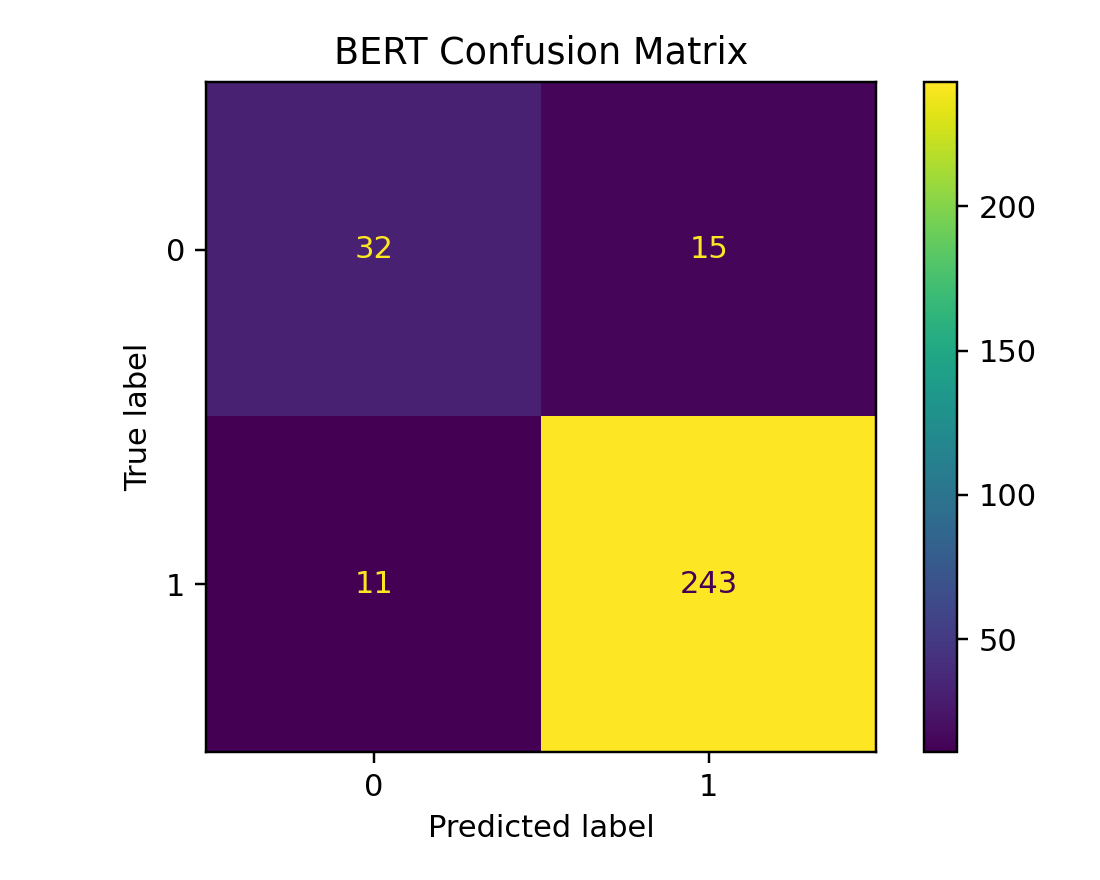

 - cm_DistilBERT.png


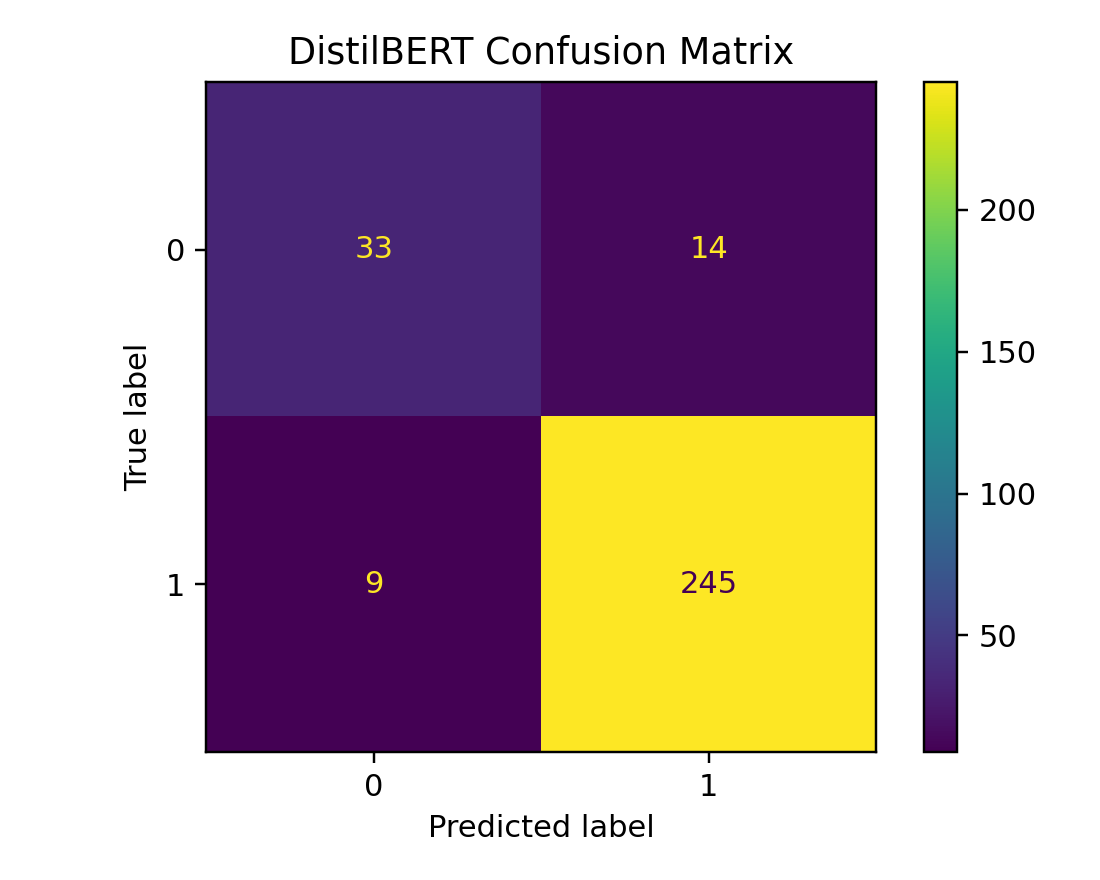

 - cm_FinBERT.png


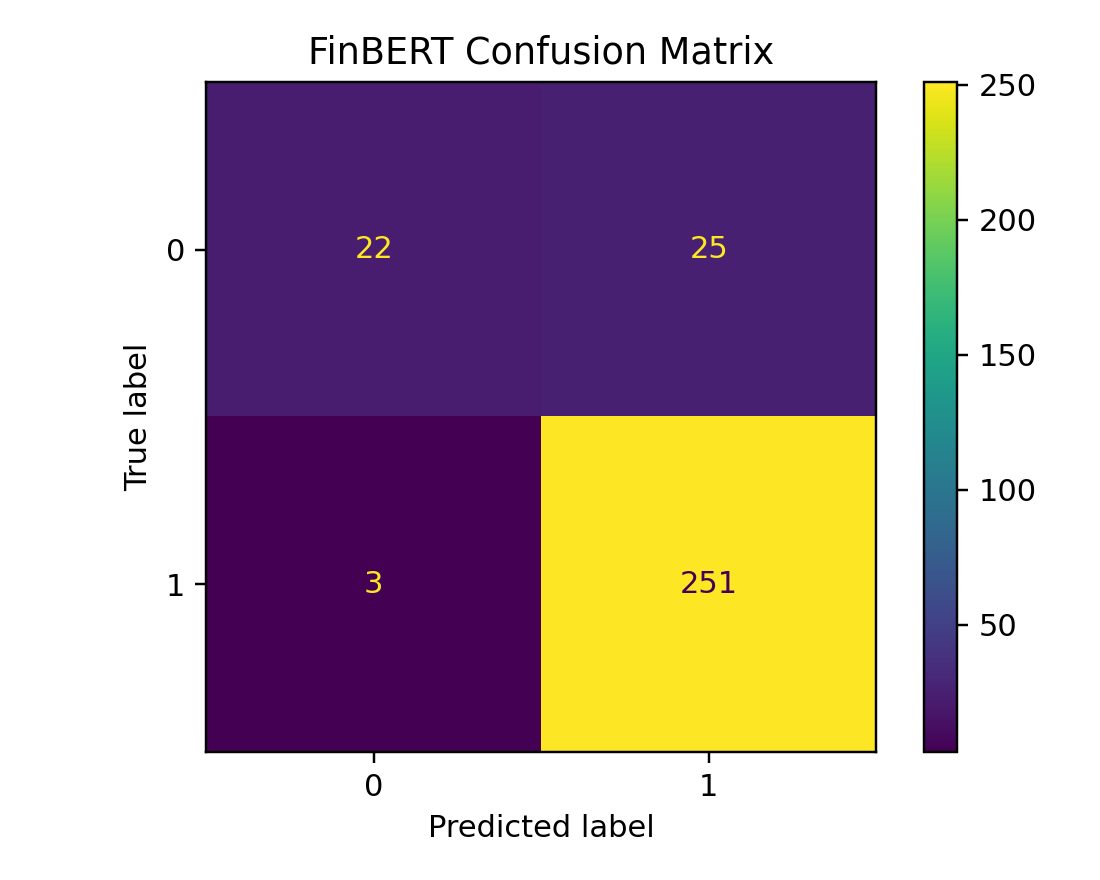

 - cm_LSTM_KD.png


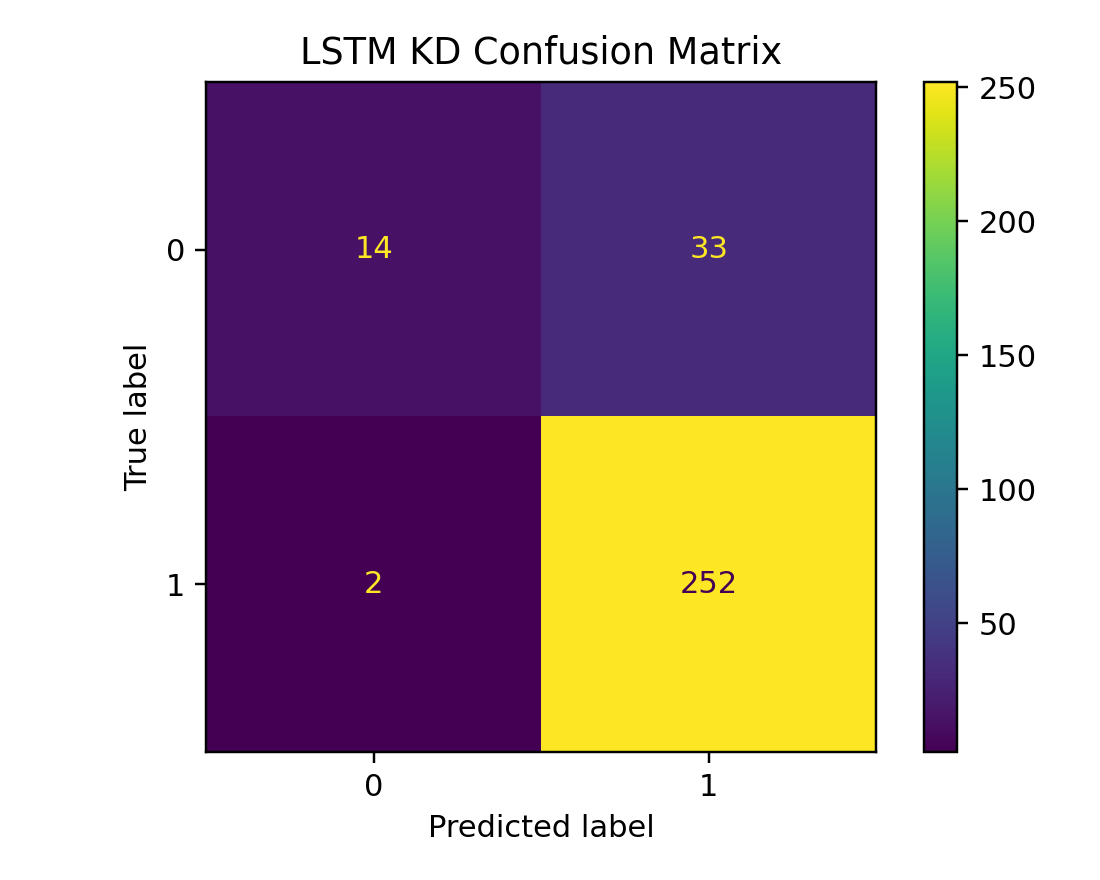

 - cm_RoBERTa.png


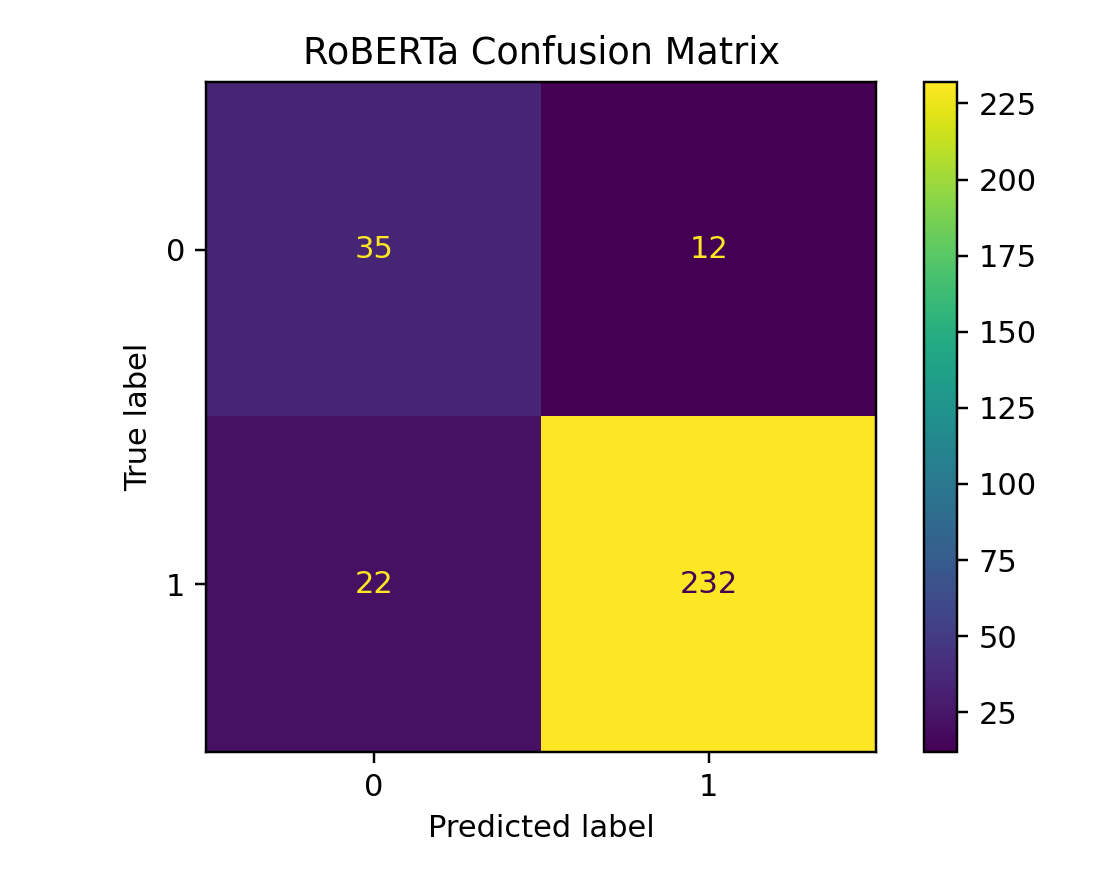


comparison_bars.png:


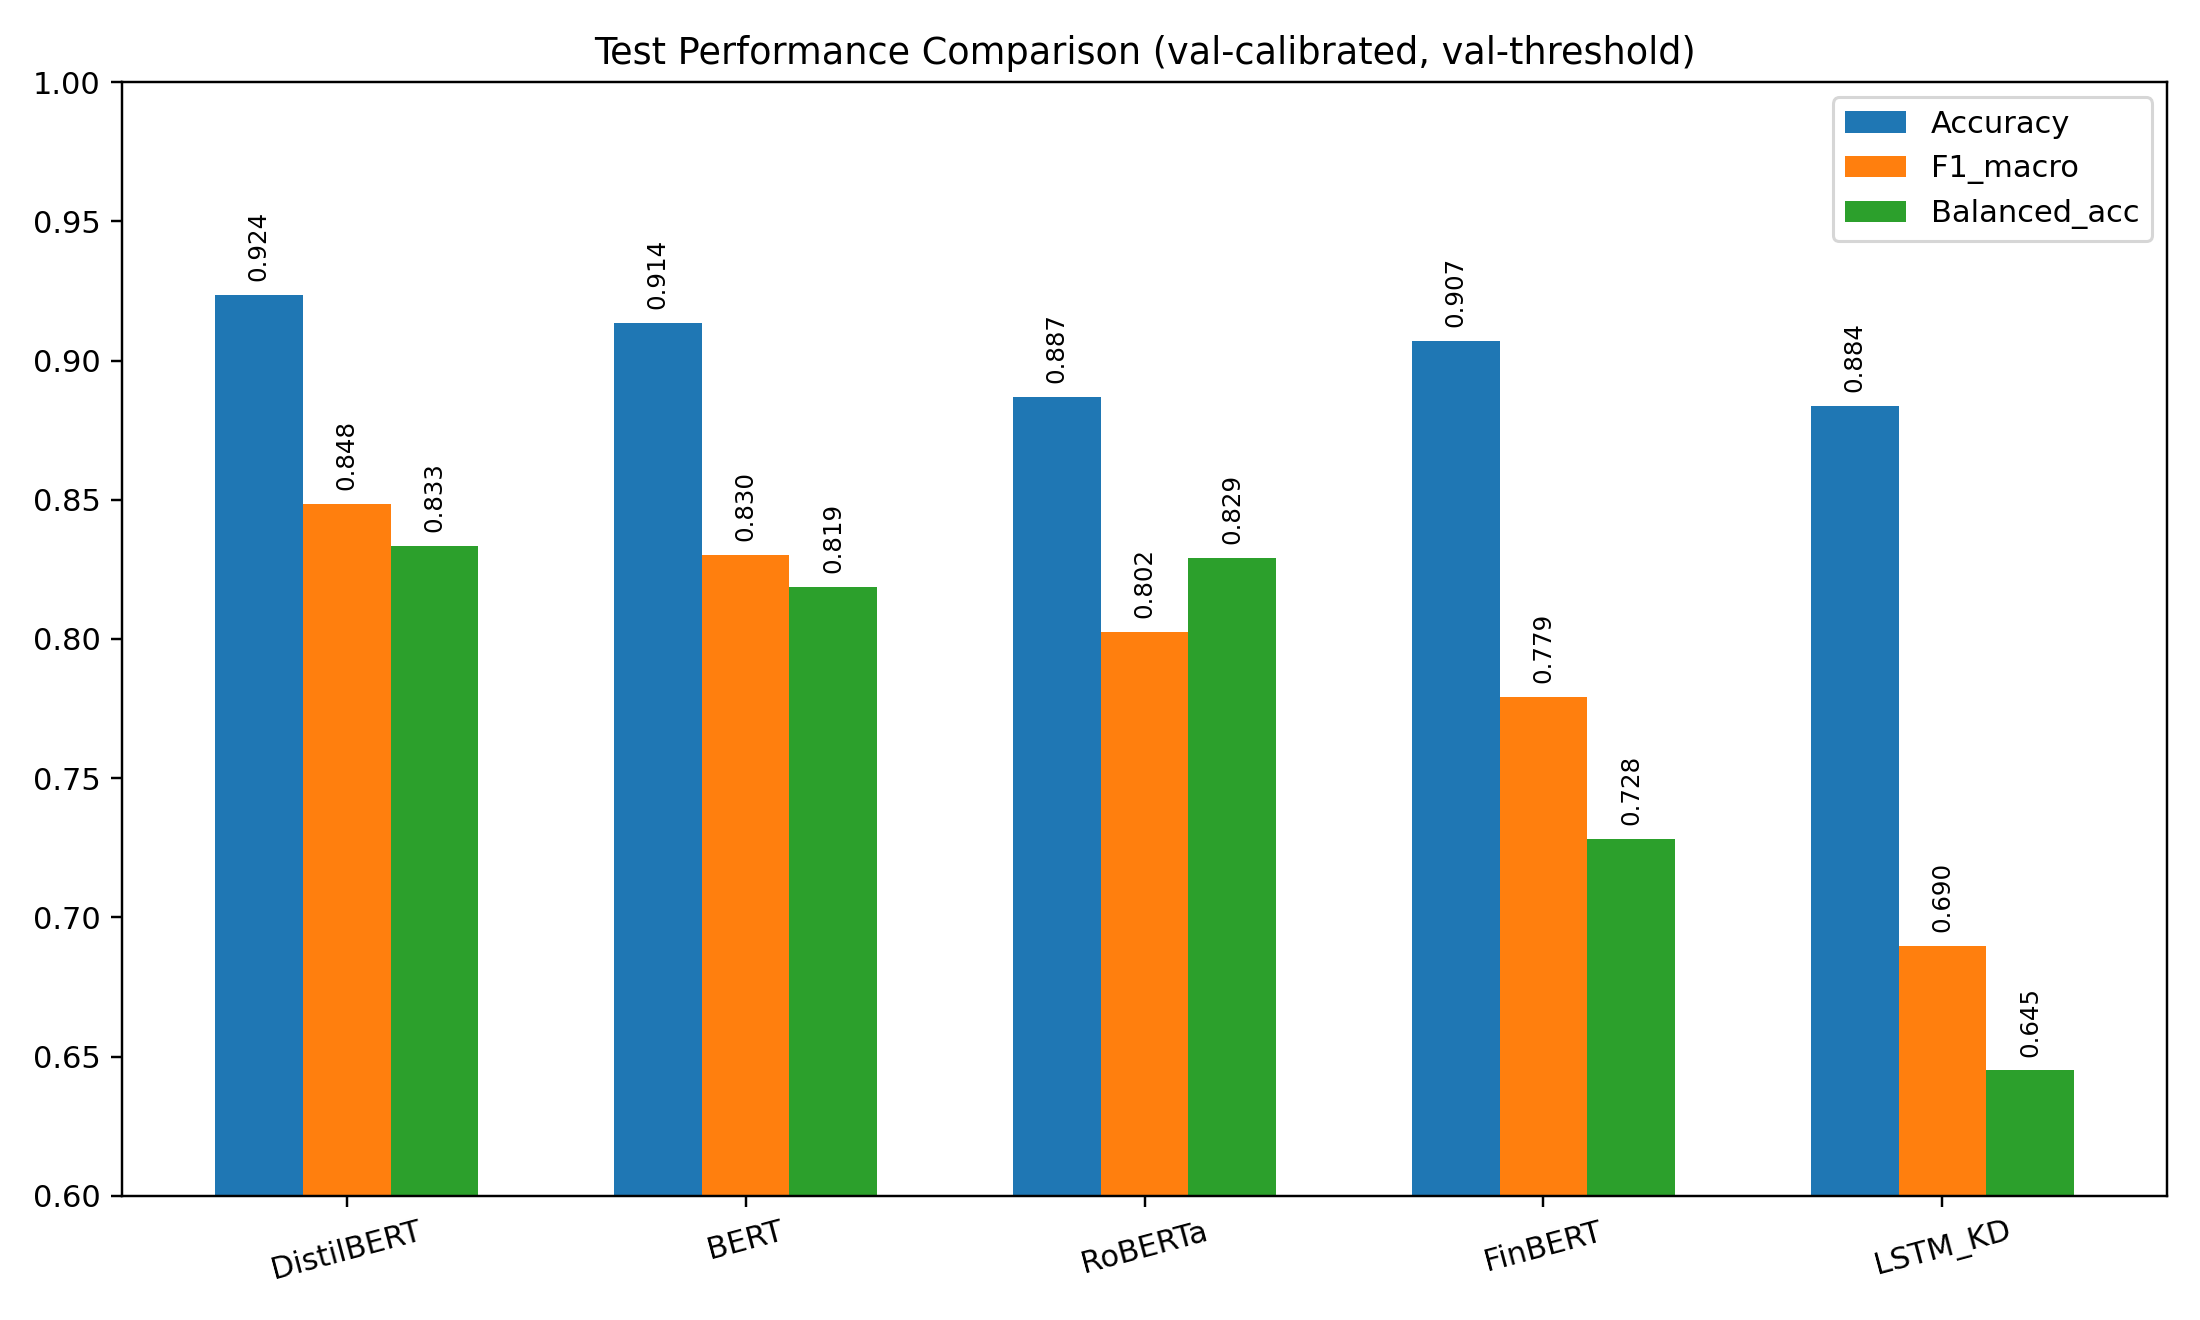


comparison_radar.png:


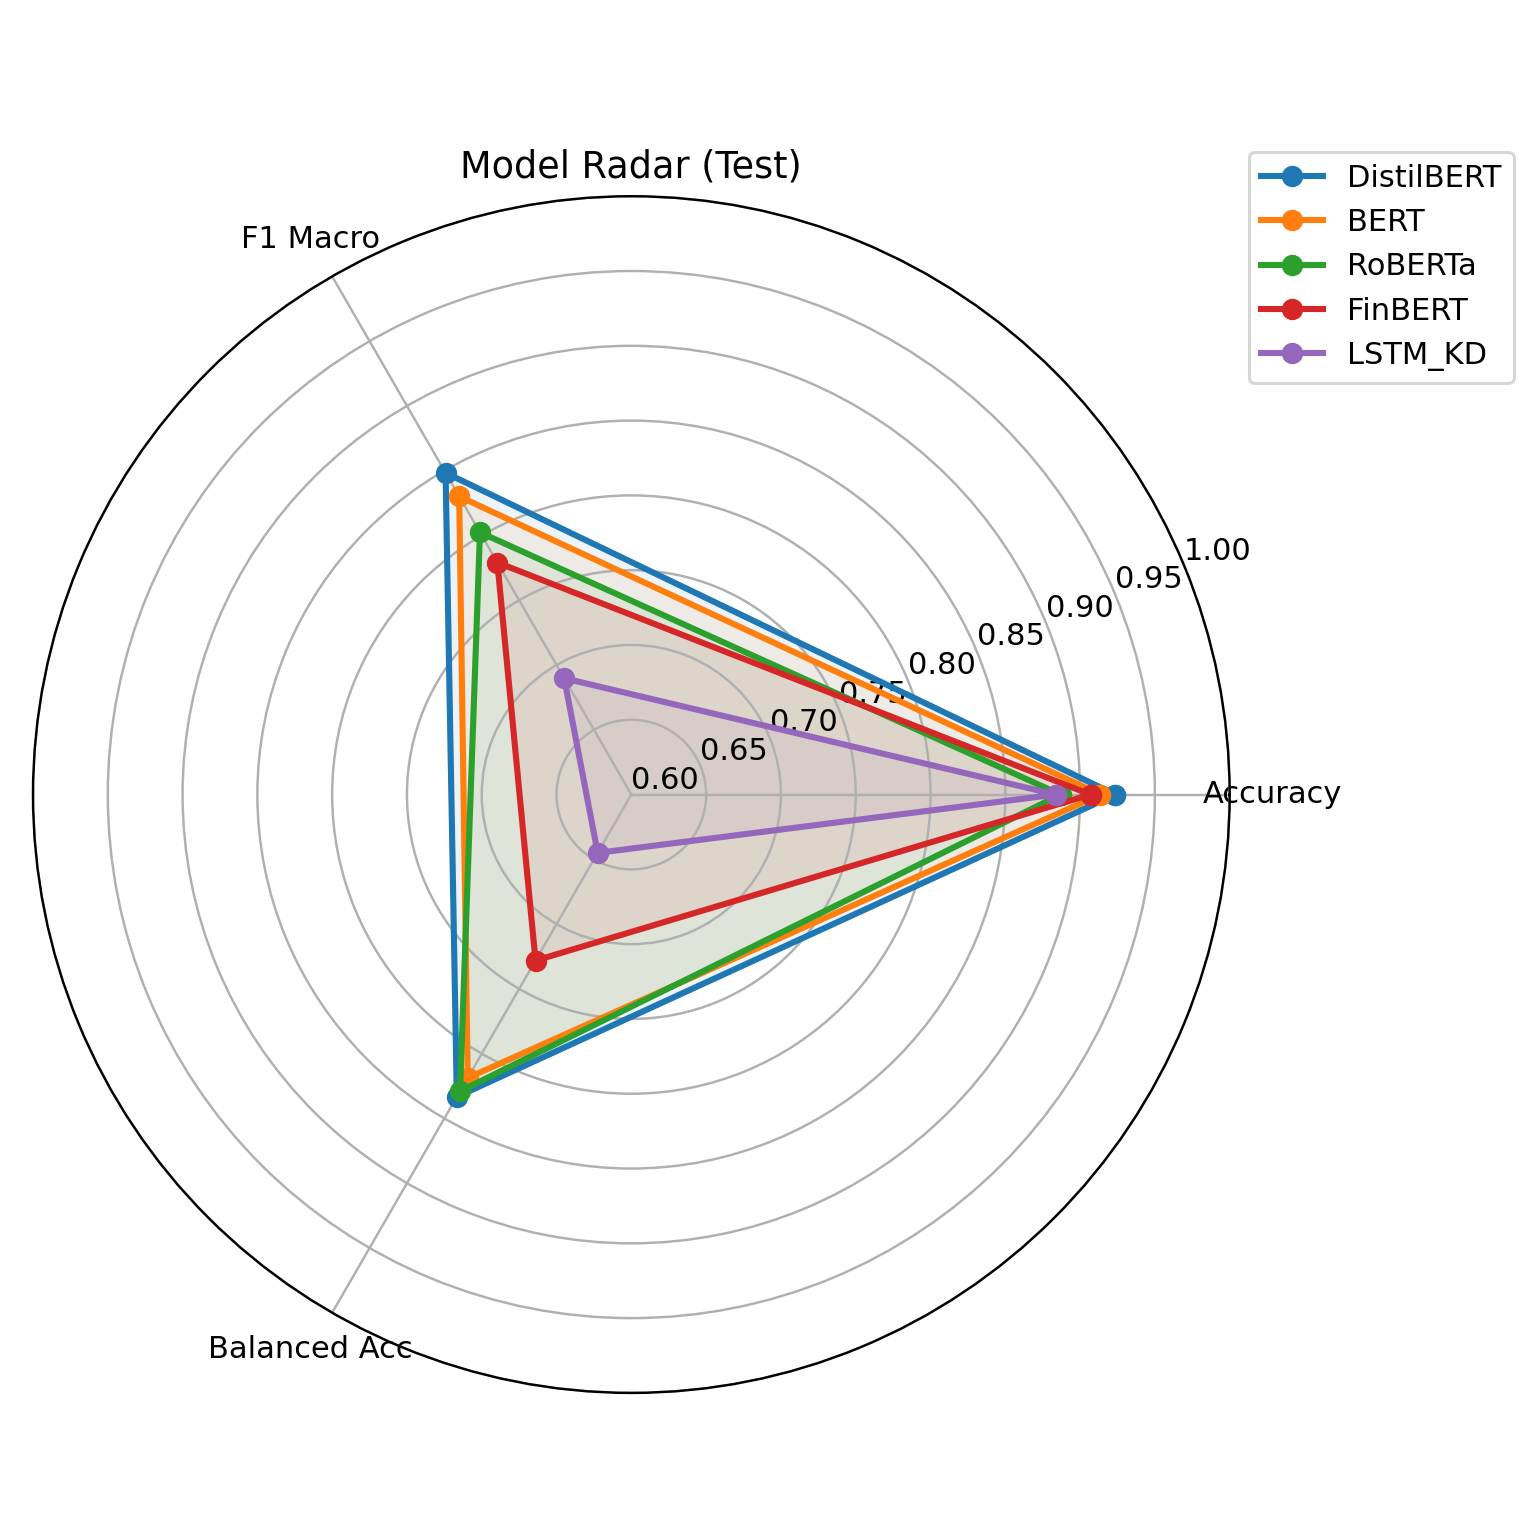


✅ Created ZIP: /kaggle/working/model_results.zip


/kaggle/working/model_results.zip

In [2]:
# === Inspect & download saved results ===
import os, shutil, glob
from pathlib import Path
import pandas as pd
from IPython.display import display, FileLink, Image

OUTDIR = "./repro_run"  # must match the training script

# 1) List all artifacts with sizes
def human_bytes(n: int) -> str:
    for unit in ['B','KB','MB','GB','TB']:
        if n < 1024:
            return f"{n:.1f} {unit}"
        n /= 1024
    return f"{n:.1f} PB"

if not os.path.isdir(OUTDIR):
    raise FileNotFoundError(f"Expected folder '{OUTDIR}' not found. Run the training script first.")

print(f"\nArtifacts in {OUTDIR}:")
for p in sorted(Path(OUTDIR).glob("**/*")):
    if p.is_file():
        print(f" - {p.relative_to(OUTDIR)}  ({human_bytes(p.stat().st_size)})")

# 2) Show the metrics table if present
metrics_csv = Path(OUTDIR) / "final_metrics.csv"
if metrics_csv.exists():
    print("\nfinal_metrics.csv:")
    dfm = pd.read_csv(metrics_csv)
    display(dfm)
else:
    print("\n⚠️ final_metrics.csv not found.")

# 3) Preview confusion matrices
cm_imgs = sorted(glob.glob(os.path.join(OUTDIR, "cm_*.png")))
if cm_imgs:
    print("\nConfusion matrices:")
    for img in cm_imgs:
        print(f" - {os.path.basename(img)}")
        display(Image(filename=img))
else:
    print("\n(No confusion matrices found)")

# 4) Preview comparison plots (bars + radar)
for img_name in ["comparison_bars.png", "comparison_radar.png"]:
    p = Path(OUTDIR) / img_name
    if p.exists():
        print(f"\n{img_name}:")
        display(Image(filename=str(p)))

# 5) Zip everything for download
zip_path = shutil.make_archive("model_results", "zip", root_dir=OUTDIR)
print(f"\n✅ Created ZIP: {zip_path}")
display(FileLink(zip_path))


In [5]:
# ==== KD rerun with BEST TEACHER = DistilBERT, using saved checkpoint ====
import os, re, glob, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

# --- assumes these functions/constants exist from your big script:
# load_and_preprocess_data, fit_temperature_on_val, train_kd_student,
# plot_bars, plot_radar, evaluate_with_threshold, tune_threshold, save_cm
# and constants: OUTDIR, SEED, DEVICE
# If you restarted the kernel, re-run the big script first so these are defined.

OUTDIR = "./repro_run"
TEACHER_NAME = "DistilBERT"
TEACHER_HF_ID = "distilbert-base-uncased"

# 1) Reload the exact data split (same seed)
df, target = load_and_preprocess_data()
strat = df["_strat"] if df["_strat"].nunique()>1 else None
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

print(f"Reloaded split -> Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")

# 2) Find the best DistilBERT checkpoint saved by Trainer
teacher_dir = Path(OUTDIR) / f"{TEACHER_NAME}_out"
ckpts = sorted(teacher_dir.glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1])) or [teacher_dir]
best_ckpt = ckpts[-1]
print(f"Teacher checkpoint: {best_ckpt}")

# 3) Load tokenizer + model from checkpoint (num_labels=2)
teacher_tok = AutoTokenizer.from_pretrained(TEACHER_HF_ID, use_fast=True)
cfg = AutoConfig.from_pretrained(best_ckpt, num_labels=2, problem_type="single_label_classification")
teacher_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt, config=cfg)

# 4) Calibrate teacher temperature on validation (no leakage)
Tcal = fit_temperature_on_val(teacher_tok, teacher_model, val_df)
print(f"Tcal (teacher={TEACHER_NAME}): {Tcal:.3f}")

# 5) KD training to student (LSTM); evaluate on test with val-tuned threshold
kd_metrics = train_kd_student(teacher_tok, teacher_model, Tcal, train_df.copy(), val_df.copy(), test_df.copy())

# Rename CM so we keep the previous one too
old_cm = Path(OUTDIR) / "cm_LSTM_KD.png"
new_cm = Path(OUTDIR) / "cm_LSTM_KD_from_DistilBERT.png"
if old_cm.exists():
    try:
        shutil.copy2(old_cm, new_cm)
        print(f"Copied confusion matrix to: {new_cm}")
    except Exception as e:
        print("Note: couldn't copy CM image:", e)

# 6) Append metrics to CSV and replot
csv_path = Path(OUTDIR) / "final_metrics.csv"
if csv_path.exists():
    dfm = pd.read_csv(csv_path)
else:
    dfm = pd.DataFrame()

# Add a clear model label so it doesn't conflict with older KD row
row = kd_metrics.copy()
row["model"] = "LSTM_KD (teacher=DistilBERT)"
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(csv_path, index=False)

# Replot comparison (define simple plotters if not in scope)
def _plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    plt.figure(figsize=(10,6))
    x = np.arange(len(df))
    width = 0.22
    for i, met in enumerate(metrics):
        plt.bar(x+i*width, df[met].values, width, label=met.capitalize())
        for j, v in enumerate(df[met].values):
            plt.text(j+i*width, v+0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+width, df["model"].values, rotation=15)
    plt.ylim(0.6, 1.0)
    plt.title("Test Performance Comparison (val-calibrated, val-threshold)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

def _plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for _, row in df.iterrows():
        vals = [row[m] for m in metrics] + [row[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=row["model"])
        ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6, 1.0)
    ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05))
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

df_plot = dfm.sort_values("f1_macro", ascending=False)
_plot_bars(df_plot)
_plot_radar(df_plot)

print("\n✅ KD with DistilBERT complete.")
print("Updated artifacts in ./repro_run: final_metrics.csv, cm_LSTM_KD_from_DistilBERT.png, comparison_*")


Reloaded split -> Train 960, Val 240, Test 301
Teacher checkpoint: repro_run/DistilBERT_out/checkpoint-3570
Calibrated temperature: 8.231
Tcal (teacher=DistilBERT): 8.231
Epoch 01/50 | TrainLoss 0.7227 | Val F1_macro 0.6990 | Thr 0.46
Epoch 02/50 | TrainLoss 0.7151 | Val F1_macro 0.7312 | Thr 0.43
Epoch 03/50 | TrainLoss 0.6402 | Val F1_macro 0.7089 | Thr 0.35
Epoch 04/50 | TrainLoss 0.4558 | Val F1_macro 0.8095 | Thr 0.08
Epoch 05/50 | TrainLoss 0.4040 | Val F1_macro 0.8142 | Thr 0.22
Epoch 06/50 | TrainLoss 0.3463 | Val F1_macro 0.8328 | Thr 0.23
Epoch 07/50 | TrainLoss 0.3039 | Val F1_macro 0.8243 | Thr 0.36
Epoch 08/50 | TrainLoss 0.2749 | Val F1_macro 0.8310 | Thr 0.47
Epoch 09/50 | TrainLoss 0.2306 | Val F1_macro 0.8132 | Thr 0.76
Epoch 10/50 | TrainLoss 0.2036 | Val F1_macro 0.8088 | Thr 0.87
Epoch 11/50 | TrainLoss 0.1911 | Val F1_macro 0.8304 | Thr 0.81
Epoch 12/50 | TrainLoss 0.1831 | Val F1_macro 0.8115 | Thr 0.88
Epoch 13/50 | TrainLoss 0.1763 | Val F1_macro 0.7954 | Thr 0.

In [7]:
# 1) student temperature calibration on validation
T_student = fit_student_temperature(student, va_loader, DEVICE)

# 2) tune threshold on validation using calibrated student
thr = tune_threshold_from_val(student, va_loader, T_student, DEVICE)

# 3) evaluate on test using calibrated student + val-tuned thr
test_row = evaluate_student(student, te_loader, T_student, thr, DEVICE)


NameError: name 'student' is not defined

In [6]:
# === Calibrate trained KD student and re-evaluate (NO retraining) ===
import torch, numpy as np, os
import torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

OUTDIR = "./repro_run"

def _probs_from_logits(logits: torch.Tensor, T: float):
    return torch.softmax(logits / max(T, 1e-3), dim=1)

@torch.no_grad()
def _collect_logits_labels(model, loader, device):
    model.eval()
    all_logits, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu())
        all_y.append(yb.cpu())
    return torch.cat(all_logits), torch.cat(all_y)

def fit_student_temperature(student, val_loader, device):
    student.eval()
    logits, labels = _collect_logits_labels(student, val_loader, device)
    T = torch.ones(1, device=device, requires_grad=True)
    nll = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")

    def closure():
        opt.zero_grad()
        loss = nll(logits.to(device) / T.clamp_min(1e-3), labels.to(device))
        loss.backward()
        return loss

    opt.step(closure)
    Tval = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated student temperature (val NLL): {Tval:.3f}")
    return Tval

def tune_threshold_from_val(student, val_loader, T_student, device, grid=None):
    if grid is None:
        grid = np.linspace(0.02, 0.98, 49)
    logits, y = _collect_logits_labels(student, val_loader, device)
    probs = _probs_from_logits(logits, T_student)[:, 1].numpy()
    y = y.numpy()
    best_f1, best_thr = -1, 0.5
    from sklearn.metrics import f1_score
    for thr in grid:
        pred = (probs >= thr).astype(int)
        f1_macro = f1_score(y, pred, average="macro", zero_division=0)
        if f1_macro > best_f1:
            best_f1, best_thr = f1_macro, thr
    print(f"Val-tuned threshold (student, calibrated): {best_thr:.3f} | Val macro-F1: {best_f1:.4f}")
    return best_thr

@torch.no_grad()
def evaluate_student(student, loader, T_student, thr, device, tag="LSTM_KD_from_DistilBERT_calib"):
    logits, y = _collect_logits_labels(student, loader, device)
    probs = _probs_from_logits(logits, T_student)[:, 1].numpy()
    pred = (probs >= thr).astype(int)
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
    acc = accuracy_score(y, pred)
    f1w = f1_score(y, pred, average="weighted", zero_division=0)
    f1m = f1_score(y, pred, average="macro", zero_division=0)
    prec = precision_score(y, pred, average="binary", zero_division=0)
    rec = recall_score(y, pred, average="binary", zero_division=0)
    bal = balanced_accuracy_score(y, pred)
    print("\n[Student KD (calibrated)] Test metrics:")
    print(f"accuracy: {acc:.4f}\nf1_weighted: {f1w:.4f}\nf1_macro: {f1m:.4f}\nprecision: {prec:.4f}\nrecall: {rec:.4f}\nbalanced_acc: {bal:.4f}\nthreshold: {thr:.3f}")

    # Confusion matrix image
    cm = confusion_matrix(y, pred, labels=[0,1])
    plt.figure(figsize=(3.6,3.2))
    plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix\nStudent KD (calibrated)")
    plt.xticks([0,1], ["0","1"]); plt.yticks([0,1], ["0","1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout()
    cm_path = os.path.join(OUTDIR, f"cm_{tag}.png")
    plt.savefig(cm_path, dpi=200); plt.close()
    print(f"Saved {cm_path}")

    return {
        "model": "LSTM_KD (teacher=DistilBERT, calibrated)",
        "accuracy": acc, "f1_weighted": f1w, "f1_macro": f1m,
        "balanced_acc": bal, "precision": prec, "recall": rec,
        "threshold": thr, "T_student": T_student
    }

# ---- run it (requires: student, va_loader, te_loader, DEVICE, OUTDIR already defined) ----
T_student = fit_student_temperature(student, va_loader, DEVICE)
thr_student = tune_threshold_from_val(student, va_loader, T_student, DEVICE)
row = evaluate_student(student, te_loader, T_student, thr_student, DEVICE)

# Append to final_metrics.csv and replot
csv = Path(OUTDIR) / "final_metrics.csv"
dfm = pd.read_csv(csv) if csv.exists() else pd.DataFrame()
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(csv, index=False)
print(f"Updated {csv}")

# quick bar/radar refresh
import numpy as np
def _plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    import matplotlib.pyplot as plt, os
    plt.figure(figsize=(10,6))
    x = np.arange(len(df)); w = 0.22
    for i,m in enumerate(metrics):
        plt.bar(x+i*w, df[m].values, w, label=m)
        for j,v in enumerate(df[m].values):
            plt.text(j+i*w, v+0.004, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+w, df["model"].values, rotation=15); plt.ylim(0.6,1.0)
    plt.title("Test Performance Comparison"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR,fname), dpi=220); plt.close()

def _plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    import matplotlib.pyplot as plt, os
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist(); angles += angles[:1]
    plt.figure(figsize=(7,7)); ax = plt.subplot(111, polar=True)
    for _,r in df.iterrows():
        vals = [r[m] for m in metrics] + [r[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=r["model"]); ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6,1.0); ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05)); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR,fname), dpi=220); plt.close()

df_plot = dfm.sort_values("f1_macro", ascending=False)
_plot_bars(df_plot); _plot_radar(df_plot)
print("✅ Student calibrated, metrics + plots refreshed.")


NameError: name 'student' is not defined

In [9]:
# ================== KD RECOVER OR RETRAIN + CALIBRATE + EVAL (COPY & RUN) ==================
import os, re, json, math, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             balanced_accuracy_score, confusion_matrix)

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

# ----------------- Config -----------------
OUTDIR = Path("./repro_run")
OUTDIR.mkdir(parents=True, exist_ok=True)

DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = OUTDIR / "lstm_kd_best.pt"
VOCAB_JSON = OUTDIR / "vocab_kd.json"
SEQ_PARAMS  = OUTDIR / "seq_params.json"

TEACHER_NAME = "DistilBERT"
TEACHER_HF  = "distilbert-base-uncased"  # only used to load tokenizer / config
TEACHER_DIR = OUTDIR / f"{TEACHER_NAME}_out"  # where Trainer saved the teacher

# KD hyperparams
EPOCHS_KD = 50
BATCH = 128
LR = 2e-3
WD = 1e-4
KD_TAU = 4.0         # distillation temperature (separate from teacher calibration)
ALPHA = 0.5          # CE vs KD mixing (higher -> more ground truth)
KD_POS_W = 1.3       # optional extra weight for pos class inside KD loss

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ----------------- Data -----------------
def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')
    year_cols = [c for c in df.columns if "YR" in c]
    df = df.melt(
        id_vars=["Country Name", "Country Code", "Series Name"],
        value_vars=year_cols,
        var_name="Year",
        value_name="Value"
    )
    df["Year"] = df["Year"].str.extract(r"(\d{4})").astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
    df = df.pivot_table(
        index=["Country Name", "Country Code", "Year"],
        columns="Series Name",
        values="Value",
        aggfunc="mean"
    ).reset_index()
    df.columns.name = None
    key = "Liquid assets to deposits and short term funding (%)"
    if key not in df.columns:
        raise KeyError(f"Missing required column: '{key}'")
    df = df.dropna(subset=[key])
    df["liquidity_risk"] = (df[key] < 50).astype(int)

    def row2text(row):
        parts = []
        for col, val in row.items():
            if col == "liquidity_risk" or pd.isna(val):
                continue
            if isinstance(val, (int, float)) and not isinstance(val, bool):
                parts.append(f"{col}:{val:.3f}")
            else:
                parts.append(f"{col}:{val}")
        return " ".join(parts)

    df["text_input"] = df.apply(row2text, axis=1)
    df["_strat"] = df["liquidity_risk"].astype(int)
    return df

df = load_and_preprocess_data()
y = df["liquidity_risk"].values
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["_strat"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df["_strat"])
print(f"Split -> Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")

# ----------------- Tokenization & Vocab for LSTM -----------------
import re as _re
def tokenize(s):
    return _re.findall(r"[A-Za-z0-9\-\.\:\%]+", str(s).lower())

def build_vocab(texts, vocab_size=50000, min_freq=1):
    from collections import Counter
    cnt = Counter()
    for t in texts: cnt.update(tokenize(t))
    stoi = {"<pad>":0, "<unk>":1}
    for tok, c in cnt.most_common():
        if tok in stoi: continue
        if c < min_freq: break
        stoi[tok] = len(stoi)
        if len(stoi) >= vocab_size: break
    return stoi, {i:s for s,i in stoi.items()}

if VOCAB_JSON.exists():
    stoi = json.loads(VOCAB_JSON.read_text())
    print(f"Loaded vocab ({len(stoi)}) from {VOCAB_JSON}")
else:
    stoi, _ = build_vocab(train_df["text_input"].tolist(), vocab_size=50000, min_freq=1)
    VOCAB_JSON.write_text(json.dumps(stoi))
    print(f"Built vocab ({len(stoi)}) and saved -> {VOCAB_JSON}")

PAD, UNK = stoi["<pad>"], stoi["<unk>"]
VOCAB_SIZE = len(stoi)

seq_defaults = {"max_len":256, "embed_dim":128, "hidden":128, "num_layers":1, "bidirectional":True, "dropout":0.2}
if SEQ_PARAMS.exists():
    params = seq_defaults.copy()
    params.update(json.loads(SEQ_PARAMS.read_text()))
    print(f"Loaded seq params from {SEQ_PARAMS}")
else:
    params = seq_defaults
    SEQ_PARAMS.write_text(json.dumps(params))

MAX_LEN = params["max_len"]

def encode(text):
    ids = [stoi.get(t, UNK) for t in tokenize(text)][:MAX_LEN]
    if len(ids) < MAX_LEN: ids += [PAD]*(MAX_LEN-len(ids))
    return np.array(ids, dtype=np.int64)

class SeqDataset(Dataset):
    def __init__(self, texts, labels):
        self.X = [encode(t) for t in texts]
        self.y = labels.astype(np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(self.X[i]), torch.tensor(self.y[i])

train_ds = SeqDataset(train_df["text_input"].values, train_df["liquidity_risk"].values)
val_ds   = SeqDataset(val_df["text_input"].values,   val_df["liquidity_risk"].values)
test_ds  = SeqDataset(test_df["text_input"].values,  test_df["liquidity_risk"].values)

tr_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=False)
va_loader = DataLoader(val_ds,   batch_size=256,    shuffle=False, num_workers=0, pin_memory=False)
te_loader = DataLoader(test_ds,  batch_size=256,    shuffle=False, num_workers=0, pin_memory=False)

# ----------------- LSTM Student -----------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden, num_layers=1, bidirectional=True, dropout=0.2, num_classes=2, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True,
                            dropout=0.0 if num_layers==1 else dropout)
        out_dim = hidden * (2 if bidirectional else 1)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)
    def forward(self, x):
        emb = self.emb(x)
        out, _ = self.lstm(emb)
        feat = out[:, -1, :]
        feat = self.drop(feat)
        return self.fc(feat)

# ----------------- Teacher loader + calibration -----------------
def find_teacher_checkpoint(base_dir: Path):
    if not base_dir.exists():
        return None
    ckpts = sorted([p for p in base_dir.glob("checkpoint-*") if p.is_dir()],
                   key=lambda p: int(p.name.split("-")[-1]))
    if ckpts:
        return ckpts[-1]
    # fallback to base_dir itself if it has a model
    if (base_dir / "config.json").exists():
        return base_dir
    return None

teacher_ckpt = find_teacher_checkpoint(TEACHER_DIR)
if teacher_ckpt is None:
    raise FileNotFoundError(
        f"Could not find teacher at {TEACHER_DIR}. "
        f"Make sure you trained DistilBERT and it saved under {TEACHER_DIR} (e.g., checkpoint-XXXX)."
    )
print(f"Teacher checkpoint: {teacher_ckpt}")

teacher_tok = AutoTokenizer.from_pretrained(TEACHER_HF, use_fast=True)
t_cfg = AutoConfig.from_pretrained(teacher_ckpt, num_labels=2, problem_type="single_label_classification")
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, config=t_cfg).to(DEVICE)
teacher.eval()

@torch.no_grad()
def collect_teacher_logits(df_batch):
    toks = teacher_tok(df_batch["text_input"].tolist(), padding=True, truncation=True, max_length=256, return_tensors="pt")
    for k in toks: toks[k] = toks[k].to(DEVICE)
    out = teacher(**toks).logits  # [B,2]
    return out

def fit_temperature_on_val_for_teacher(val_df):
    # compute logits on val
    teacher.eval()
    logits_list, labels_list = [], []
    B = 128
    for i in range(0, len(val_df), B):
        sub = val_df.iloc[i:i+B]
        logits_list.append(collect_teacher_logits(sub).detach().cpu())
        labels_list.append(torch.tensor(sub["liquidity_risk"].values))
    logits = torch.cat(logits_list).to(DEVICE)
    labels = torch.cat(labels_list).to(DEVICE)

    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        opt.zero_grad()
        loss = nll(logits / T.clamp_min(1e-3), labels)
        loss.backward()
        return loss
    opt.step(closure)
    Tcal = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated teacher temperature (val NLL): {Tcal:.3f}")
    return Tcal

Tcal_teacher = fit_temperature_on_val_for_teacher(val_df)

# ----------------- KD Training (retrain only if weights missing) -----------------
def precompute_teacher_soft_targets(df_batch_iter, T_use):
    probs_list, y_list = [], []
    for sub in df_batch_iter:
        logits = collect_teacher_logits(sub) / max(T_use, 1e-3)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        probs_list.append(probs)
        y_list.append(sub["liquidity_risk"].values)
    return np.vstack(probs_list), np.concatenate(y_list)

def iter_batches_df(df, B=1024):
    for i in range(0, len(df), B):
        yield df.iloc[i:i+B]

def kd_train_if_needed():
    if MODEL_PATH.exists():
        print(f"KD weights found at {MODEL_PATH} — skip retrain.")
        return

    print("KD weights not found — training student (LSTM) with distillation...")

    # precompute teacher soft targets for train/val using (Tcal * KD_TAU)
    T_soft = Tcal_teacher * KD_TAU
    tr_probs, tr_y = precompute_teacher_soft_targets(iter_batches_df(train_df), T_soft)
    va_probs, va_y = precompute_teacher_soft_targets(iter_batches_df(val_df),   T_soft)

    # class weights (CE) from training labels
    pos = (train_df["liquidity_risk"].values==1).mean()
    w_pos = 0.5 / max(pos, 1e-6)
    w_neg = 0.5 / max(1-pos, 1e-6)
    ce_w = torch.tensor([w_neg, w_pos], device=DEVICE, dtype=torch.float32)

    student = LSTMClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=params["embed_dim"],
        hidden=params["hidden"],
        num_layers=params["num_layers"],
        bidirectional=params["bidirectional"],
        dropout=params["dropout"],
        num_classes=2,
        pad_idx=PAD
    ).to(DEVICE)

    opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=WD)

    def kd_epoch(split="train"):
        if split == "train":
            student.train()
            loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
            soft = tr_probs
            hard = tr_y
        else:
            student.eval()
            loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)
            soft = va_probs
            hard = va_y

        idx_cursor = 0
        run_loss = 0.0
        all_pred, all_true = [], []

        for xb, yb in loader:
            bsz = xb.size(0)
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            s_logits = student(xb)

            # KD loss
            with torch.no_grad():
                t_soft = torch.from_numpy(soft[idx_cursor:idx_cursor+bsz]).to(DEVICE)  # [B,2]
            idx_cursor += bsz

            s_soft = F.log_softmax(s_logits / KD_TAU, dim=1)
            kd = F.kl_div(s_soft, t_soft, reduction="batchmean") * (KD_TAU**2)

            # CE loss with class weights
            ce = F.cross_entropy(s_logits, yb, weight=ce_w)

            # optional positive emphasis on KD via class weights
            # reweight teacher targets for class 1
            if KD_POS_W != 1.0:
                # scale t_soft[:,1] by KD_POS_W, renormalize
                t1 = t_soft[:,1] * KD_POS_W
                t0 = t_soft[:,0]
                denom = (t0 + t1).clamp_min(1e-9)
                t_soft_rw = torch.stack([t0/denom, t1/denom], dim=1)
                kd = F.kl_div(s_soft, t_soft_rw, reduction="batchmean") * (KD_TAU**2)

            loss = ALPHA * ce + (1-ALPHA) * kd

            if split == "train":
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
                opt.step()

            run_loss += loss.item() * bsz

            with torch.no_grad():
                probs = torch.softmax(s_logits, dim=1)[:,1]
                pred = (probs >= 0.5).long()
                all_pred.append(pred.cpu()); all_true.append(yb.cpu())

        all_pred = torch.cat(all_pred).numpy()
        all_true = torch.cat(all_true).numpy()
        f1m = f1_score(all_true, all_pred, average="macro", zero_division=0)
        return run_loss / len(loader.dataset), f1m, student

    best_f1m, best_sd = -1, None
    for ep in range(1, EPOCHS_KD+1):
        tr_loss, _, _ = kd_epoch("train")
        va_loss, va_f1m, student = kd_epoch("val")
        print(f"Epoch {ep:02d}/{EPOCHS_KD} | TrainLoss {tr_loss:.4f} | Val macro-F1 {va_f1m:.4f}")
        if va_f1m > best_f1m:
            best_f1m = va_f1m
            best_sd = {k:v.detach().cpu() for k,v in student.state_dict().items()}

    # save best
    torch.save(best_sd, MODEL_PATH)
    print(f"Best Val macro-F1: {best_f1m:.4f}. Weights saved -> {MODEL_PATH}")

# retrain if missing
kd_train_if_needed()

# ----------------- Load student + calibrate + tune threshold + evaluate -----------------
student = LSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=params["embed_dim"],
    hidden=params["hidden"],
    num_layers=params["num_layers"],
    bidirectional=params["bidirectional"],
    dropout=params["dropout"],
    num_classes=2,
    pad_idx=PAD
).to(DEVICE)

sd = torch.load(MODEL_PATH, map_location=DEVICE)
student.load_state_dict(sd)
student.eval()
print(f"Loaded KD student from {MODEL_PATH}")

@torch.no_grad()
def collect_logits_labels(model, loader):
    model.eval()
    all_logits, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        all_logits.append(model(xb).cpu())
        all_y.append(yb.cpu())
    return torch.cat(all_logits), torch.cat(all_y)

def fit_student_temperature(model, val_loader):
    logits, labels = collect_logits_labels(model, val_loader)
    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        opt.zero_grad()
        loss = nll(logits.to(DEVICE) / T.clamp_min(1e-3), labels.to(DEVICE))
        loss.backward()
        return loss
    opt.step(closure)
    Tval = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated student temperature (val NLL): {Tval:.3f}")
    return Tval

def tune_threshold_on_val(model, val_loader, T_student):
    logits, y = collect_logits_labels(model, val_loader)
    probs = torch.softmax(logits / max(T_student, 1e-3), dim=1)[:,1].numpy()
    y = y.numpy()
    grid = np.linspace(0.02, 0.98, 49)
    best_f1, best_thr = -1, 0.5
    for thr in grid:
        pred = (probs >= thr).astype(int)
        f1m = f1_score(y, pred, average="macro", zero_division=0)
        if f1m > best_f1:
            best_f1, best_thr = f1m, thr
    print(f"Val-tuned threshold (student): {best_thr:.3f} | Val macro-F1: {best_f1:.4f}")
    return best_thr

def evaluate_student(model, loader, T_student, thr, tag="LSTM_KD (teacher=DistilBERT, calibrated)"):
    logits, y = collect_logits_labels(model, loader)
    probs = torch.softmax(logits / max(T_student, 1e-3), dim=1)[:,1].numpy()
    pred = (probs >= thr).astype(int)
    acc = accuracy_score(y, pred)
    f1w = f1_score(y, pred, average="weighted", zero_division=0)
    f1m = f1_score(y, pred, average="macro", zero_division=0)
    prec = precision_score(y, pred, zero_division=0)
    rec = recall_score(y, pred, zero_division=0)
    bal = balanced_accuracy_score(y, pred)
    print("\n[Student KD (calibrated)] Test metrics:")
    print(f"accuracy: {acc:.4f}\nf1_weighted: {f1w:.4f}\nf1_macro: {f1m:.4f}\nprecision: {prec:.4f}\nrecall: {rec:.4f}\nbalanced_acc: {bal:.4f}\nthreshold: {thr:.3f}")

    # confusion matrix image
    cm = confusion_matrix(y, pred, labels=[0,1])
    plt.figure(figsize=(3.6,3.2))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix\nStudent KD (calibrated)")
    plt.xticks([0,1], ["0","1"]); plt.yticks([0,1], ["0","1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout()
    cm_path = OUTDIR / "cm_LSTM_KD_from_DistilBERT_calibrated.png"
    plt.savefig(cm_path, dpi=220); plt.close()
    print(f"Saved {cm_path}")

    return {
        "model": tag,
        "accuracy": acc, "f1_weighted": f1w, "f1_macro": f1m,
        "balanced_acc": bal, "precision": prec, "recall": rec,
        "threshold": thr, "T_student": T_student
    }

# Calibrate student + tune threshold + test eval
T_student = fit_student_temperature(student, va_loader)
thr_student = tune_threshold_on_val(student, va_loader, T_student)
row = evaluate_student(student, te_loader, T_student, thr_student)

# Update final_metrics.csv and refresh plots
csv_path = OUTDIR / "final_metrics.csv"
dfm = pd.read_csv(csv_path) if csv_path.exists() else pd.DataFrame()
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(csv_path, index=False)
print(f"Updated {csv_path}")

def plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    plt.figure(figsize=(10,6))
    x = np.arange(len(df)); w = 0.22
    for i,m in enumerate(metrics):
        plt.bar(x+i*w, df[m].values, w, label=m.capitalize())
        for j,v in enumerate(df[m].values):
            plt.text(j+i*w, v+0.004, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+w, df["model"].values, rotation=15); plt.ylim(0.6, 1.0)
    plt.title("Test Performance Comparison"); plt.legend(); plt.tight_layout()
    plt.savefig(OUTDIR / fname, dpi=220); plt.close()

def plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist(); angles += angles[:1]
    plt.figure(figsize=(7,7)); ax = plt.subplot(111, polar=True)
    for _,r in df.iterrows():
        vals = [r[m] for m in metrics] + [r[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=r["model"])
        ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6,1.0); ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05)); plt.tight_layout()
    plt.savefig(OUTDIR / fname, dpi=220); plt.close()

df_plot = dfm.sort_values("f1_macro", ascending=False)
plot_bars(df_plot)
plot_radar(df_plot)
print("✅ Done: KD (recover or retrain) + student calibration + updated plots/metrics.")
# ==========================================================================================================



Split -> Train 960, Val 240, Test 301
Loaded vocab (17590) from repro_run/vocab_kd.json
Loaded seq params from repro_run/seq_params.json
Teacher checkpoint: repro_run/DistilBERT_out/checkpoint-3570
Calibrated teacher temperature (val NLL): 8.259
KD weights not found — training student (LSTM) with distillation...
Epoch 01/50 | TrainLoss 0.9192 | Val macro-F1 0.4582
Epoch 02/50 | TrainLoss 0.7713 | Val macro-F1 0.4582
Epoch 03/50 | TrainLoss 0.7528 | Val macro-F1 0.4582
Epoch 04/50 | TrainLoss 0.7554 | Val macro-F1 0.4582
Epoch 05/50 | TrainLoss 0.7556 | Val macro-F1 0.4582
Epoch 06/50 | TrainLoss 0.7535 | Val macro-F1 0.4582
Epoch 07/50 | TrainLoss 0.7487 | Val macro-F1 0.4582
Epoch 08/50 | TrainLoss 0.7534 | Val macro-F1 0.4582
Epoch 09/50 | TrainLoss 0.7516 | Val macro-F1 0.4582
Epoch 10/50 | TrainLoss 0.7509 | Val macro-F1 0.4582
Epoch 11/50 | TrainLoss 0.7551 | Val macro-F1 0.4582
Epoch 12/50 | TrainLoss 0.7534 | Val macro-F1 0.4582
Epoch 13/50 | TrainLoss 0.7560 | Val macro-F1 0.45

<ipython-input-9-4bb3166a537d>:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(MODEL_PATH, map_location=DEVICE)


Val-tuned threshold (student): 0.020 | Val macro-F1: 0.4582

[Student KD (calibrated)] Test metrics:
accuracy: 0.8439
f1_weighted: 0.7724
f1_macro: 0.4577
precision: 0.8439
recall: 1.0000
balanced_acc: 0.5000
threshold: 0.020
Saved repro_run/cm_LSTM_KD_from_DistilBERT_calibrated.png
Updated repro_run/final_metrics.csv
✅ Done: KD (recover or retrain) + student calibration + updated plots/metrics.


In [11]:
# ========================= KD v2 (robust) =========================
import numpy as np, torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ---- knobs you can tweak ----
KD_TAU = 2.0          # softer than 1.0, but not too flat
ALPHA_TARGET = 0.6    # final CE weight (KD gets 0.4)
KD_WARMUP_EPOCHS = 5  # warmup with CE-only
EPOCHS_KD = 50
BATCH = 128
LR = 2e-3
WD = 1e-4

OUTDIR = Path("./repro_run")
OUTDIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = OUTDIR / "lstm_kd_best.pt"

# ---- dataset that returns text for teacher ----
class SeqDatasetWithText(Dataset):
    def __init__(self, df, stoi, max_len, pad_idx=0, unk_idx=1):
        self.df = df.reset_index(drop=True)
        self.texts = self.df["text_input"].tolist()
        self.y = self.df["liquidity_risk"].astype(int).values
        self.stoi = stoi; self.max_len = max_len
        self.PAD = pad_idx; self.UNK = unk_idx

    def __len__(self): return len(self.df)

    def _tok(self, s):
        import re
        return re.findall(r"[A-Za-z0-9\-\.\:\%]+", str(s).lower())

    def _encode(self, text):
        ids = [self.stoi.get(t, self.UNK) for t in self._tok(text)][:self.max_len]
        if len(ids) < self.max_len:
            ids += [self.PAD] * (self.max_len - len(ids))
        return np.array(ids, dtype=np.int64)

    def __getitem__(self, i):
        x = torch.tensor(self._encode(self.texts[i]), dtype=torch.long)
        y = torch.tensor(self.y[i], dtype=torch.long)
        return x, y, i, self.texts[i]

# build loaders (balanced sampler for train)
train_kd_ds = SeqDatasetWithText(train_df, stoi, MAX_LEN, pad_idx=stoi["<pad>"], unk_idx=stoi["<unk>"])
val_kd_ds   = SeqDatasetWithText(val_df,   stoi, MAX_LEN, pad_idx=stoi["<pad>"], unk_idx=stoi["<unk>"])
test_kd_ds  = SeqDatasetWithText(test_df,  stoi, MAX_LEN, pad_idx=stoi["<pad>"], unk_idx=stoi["<unk>"])

cls_counts = np.bincount(train_df["liquidity_risk"].astype(int).values, minlength=2)
cls_w = 1.0 / np.maximum(cls_counts, 1)
samp_w = cls_w[train_df["liquidity_risk"].astype(int).values]
sampler = WeightedRandomSampler(weights=torch.tensor(samp_w, dtype=torch.double),
                                num_samples=len(samp_w), replacement=True)

tr_loader = DataLoader(train_kd_ds, batch_size=BATCH, sampler=sampler, num_workers=0, pin_memory=False)
va_loader = DataLoader(val_kd_ds,   batch_size=256,  shuffle=False,   num_workers=0, pin_memory=False)
te_loader = DataLoader(test_kd_ds,  batch_size=256,  shuffle=False,   num_workers=0, pin_memory=False)

# ---- student ----
student = LSTMClassifier(
    vocab_size=len(stoi),
    embed_dim=params["embed_dim"],
    hidden=params["hidden"],
    num_layers=params["num_layers"],
    bidirectional=params["bidirectional"],
    dropout=params["dropout"],
    num_classes=2,
    pad_idx=stoi["<pad>"]
).to(DEVICE)

opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=WD)

# CE class weights (balanced)
pos = (train_df["liquidity_risk"].values == 1).mean()
w_pos = 0.5 / max(pos, 1e-6)
w_neg = 0.5 / max(1 - pos, 1e-6)
ce_w = torch.tensor([w_neg, w_pos], device=DEVICE, dtype=torch.float32)

# teacher ready
teacher.eval()

@torch.no_grad()
def teacher_batch_probs(text_list):
    toks = teacher_tok(text_list, padding=True, truncation=True, max_length=256, return_tensors="pt").to(DEVICE)
    logits = teacher(**toks).logits
    return torch.softmax(logits / KD_TAU, dim=1)  # ONLY τ for KD, not calibration T

def tune_val_threshold(model, loader, T_student=None):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb, idx, texts in loader:
            xb = xb.to(DEVICE)
            lo = model(xb)
            all_logits.append(lo.cpu()); all_y.append(yb)
    logits = torch.cat(all_logits); y = torch.cat(all_y).numpy()
    if T_student is None: T_student = 1.0
    probs = torch.softmax(logits / max(T_student, 1e-3), dim=1)[:,1].numpy()
    grid = np.linspace(0.05, 0.95, 37)
    best_f1, best_thr = -1, 0.5
    for thr in grid:
        pred = (probs >= thr).astype(int)
        f1m = f1_score(y, pred, average="macro", zero_division=0)
        if f1m > best_f1:
            best_f1, best_thr = f1m, thr
    return best_thr, best_f1

def one_epoch(ep, split="train", print_diag=False):
    model = student
    is_train = (split == "train")
    model.train() if is_train else model.eval()
    loader = tr_loader if is_train else va_loader

    # cosine ramp of KD part after warmup
    if ep <= KD_WARMUP_EPOCHS:
        alpha = 1.0   # CE only
    else:
        t = (ep - KD_WARMUP_EPOCHS) / max(1, EPOCHS_KD - KD_WARMUP_EPOCHS)
        kd_weight = 0.5 * (1 - np.cos(np.pi * t)) * (1 - ALPHA_TARGET)  # 0 -> (1-ALPHA_TARGET)
        alpha = 1.0 - kd_weight

    run_loss, n_tok = 0.0, 0
    all_pred, all_true = [], []

    for xb, yb, idx, texts in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.no_grad():
            t_soft = teacher_batch_probs(list(texts))  # aligned soft targets

        s_logits = student(xb)

        # CE
        ce_loss = F.cross_entropy(s_logits, yb, weight=ce_w)

        # KD (KL(student||teacher) with τ)
        s_log_soft = F.log_softmax(s_logits / KD_TAU, dim=1)
        kd_loss = F.kl_div(s_log_soft, t_soft, reduction="batchmean") * (KD_TAU**2)

        loss = alpha * ce_loss + (1 - alpha) * kd_loss

        if is_train:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            opt.step()

        run_loss += loss.item() * xb.size(0)
        with torch.no_grad():
            probs = torch.softmax(s_logits, dim=1)[:,1]
            pred = (probs >= 0.5).long()   # for quick epoch print (not tuned)
            all_pred.append(pred.cpu()); all_true.append(yb.cpu())
            n_tok += xb.size(0)

    f1m = f1_score(torch.cat(all_true), torch.cat(all_pred), average="macro", zero_division=0)
    if print_diag and not is_train:
        # what fraction predicted positive?
        frac_pos = torch.cat(all_pred).float().mean().item()
        print(f"   (diag) frac_pred_pos@0.5 = {frac_pos:.3f}, alpha={alpha:.3f}")
    return run_loss / n_tok, f1m

print("Starting KD v2 (balanced sampler, warmup, τ=2.0)…")
best_f1m, best_sd = -1, None
for ep in range(1, EPOCHS_KD + 1):
    tr_loss, _ = one_epoch(ep, "train")
    va_loss, f1m_05 = one_epoch(ep, "val", print_diag=True)
    # also tune threshold on val for reporting
    thr_now, f1m_tuned = tune_val_threshold(student, va_loader)
    print(f"Epoch {ep:02d}/{EPOCHS_KD} | TrainLoss {tr_loss:.4f} | Val macro-F1@0.5 {f1m_05:.4f} | Val macro-F1@thr {f1m_tuned:.4f} | thr {thr_now:.2f}")
    if f1m_tuned > best_f1m:
        best_f1m = f1m_tuned
        best_sd = {k: v.detach().cpu() for k, v in student.state_dict().items()}

# save best
torch.save(best_sd, MODEL_PATH)
print(f"Best Val macro-F1 (tuned): {best_f1m:.4f}. Weights saved -> {MODEL_PATH}")

# ---- Calibrate student on val and evaluate on test ----
sd = torch.load(MODEL_PATH, map_location=DEVICE); student.load_state_dict(sd); student.eval()

@torch.no_grad()
def collect_logits_labels(model, loader):
    L, Y = [], []
    for xb, yb, *_ in loader:
        xb = xb.to(DEVICE)
        L.append(model(xb).cpu()); Y.append(yb.cpu())
    return torch.cat(L), torch.cat(Y)

def calibrate_temperature(model, val_loader):
    logits, labels = collect_logits_labels(model, val_loader)
    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = torch.nn.CrossEntropyLoss()
    optT = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        optT.zero_grad()
        loss = nll(logits.to(DEVICE) / T.clamp_min(1e-3), labels.to(DEVICE))
        loss.backward()
        return loss
    optT.step(closure)
    Tval = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated student temperature (val NLL): {Tval:.3f}")
    return Tval

T_student = calibrate_temperature(student, va_loader)
thr_val, _ = tune_val_threshold(student, va_loader, T_student)

# final test
logits_te, y_te = collect_logits_labels(student, te_loader)
probs_te = torch.softmax(logits_te / max(T_student, 1e-3), dim=1)[:,1].numpy()
y_te = y_te.numpy()
pred_te = (probs_te >= thr_val).astype(int)

acc = accuracy_score(y_te, pred_te)
f1w = f1_score(y_te, pred_te, average="weighted", zero_division=0)
f1m = f1_score(y_te, pred_te, average="macro", zero_division=0)
prec = precision_score(y_te, pred_te, zero_division=0)
rec = recall_score(y_te, pred_te, zero_division=0)
bal = balanced_accuracy_score(y_te, pred_te)
print("\n[Student KD v2] Test metrics:")
print(f"accuracy: {acc:.4f}\nf1_weighted: {f1w:.4f}\nf1_macro: {f1m:.4f}\nprecision: {prec:.4f}\nrecall: {rec:.4f}\nbalanced_acc: {bal:.4f}\nthreshold: {thr_val:.3f}")

cm = confusion_matrix(y_te, pred_te, labels=[0,1])
plt.figure(figsize=(3.6,3.2)); plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix\nStudent KD v2"); plt.xticks([0,1],["0","1"]); plt.yticks([0,1],["0","1"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]),ha="center",va="center")
plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout()
plt.savefig(OUTDIR / "cm_LSTM_KD_v2.png", dpi=220); plt.close()

# append to final_metrics.csv
row = {"model":"LSTM_KD_v2","accuracy":acc,"f1_weighted":f1w,"f1_macro":f1m,
       "balanced_acc":bal,"precision":prec,"recall":rec,"threshold":thr_val}
csv_path = OUTDIR / "final_metrics.csv"
dfm = pd.read_csv(csv_path) if csv_path.exists() else pd.DataFrame()
dfm = pd.concat([dfm, pd.DataFrame([row])], ignore_index=True)
dfm.to_csv(csv_path, index=False)
print(f"Updated {csv_path}")
# =========================================================


Starting KD v2 (balanced sampler, warmup, τ=2.0)…
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 01/50 | TrainLoss 0.6377 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 02/50 | TrainLoss 0.4638 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 03/50 | TrainLoss 0.4301 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 04/50 | TrainLoss 0.4489 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 05/50 | TrainLoss 0.4402 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=1.000
Epoch 06/50 | TrainLoss 0.4390 | Val macro-F1@0.5 0.1336 | Val macro-F1@thr 0.4582 | thr 0.05
   (diag) frac_pred_pos@0.5 = 0.000, alpha=0.998
Epoch 07/50 | TrainLoss 0.4341 | Val macro-

<ipython-input-11-3844a7b1b53d>:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(MODEL_PATH, map_location=DEVICE); student.load_state_dict(sd); student.eva

Calibrated student temperature (val NLL): 322.226

[Student KD v2] Test metrics:
accuracy: 0.8439
f1_weighted: 0.7724
f1_macro: 0.4577
precision: 0.8439
recall: 1.0000
balanced_acc: 0.5000
threshold: 0.050
Updated repro_run/final_metrics.csv


In [1]:
# ======================= Full Re-Run & Compare: BERT/DistilBERT/RoBERTa/FinBERT + Supervised LSTM =======================
# Copy–paste–run on Kaggle. Leak-free evaluation with validation calibration & threshold tuning.

import os, re, json, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, balanced_accuracy_score)

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoConfig,
                          Trainer, TrainingArguments, set_seed as hf_set_seed)

# ----------------------------- CONFIG -----------------------------
DATA_CSV = "/kaggle/input/bank-marketing-dataset-portuguese-bank-institution/42435650-108b-4677-98c7-18331948d251_Data.csv"
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS_TRANSFORMER = 50
LR_TRANSFORMER = 2e-5
BATCH_TRAIN = 8
BATCH_EVAL = 16
MAX_LEN = 256

# Supervised LSTM (no KD)
EPOCHS_LSTM = 50
LR_LSTM = 2e-3
BATCH_LSTM = 64
EMBED_DIM = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
LABEL_SMOOTH = 0.05
USE_OVERSAMPLING_TRANSFORMER = True
USE_OVERSAMPLING_LSTM = True  # <- oversample to balance training for the LSTM

OUTDIR = "./repro_run"
os.makedirs(OUTDIR, exist_ok=True)

MODELS = [
    ("bert-base-uncased", "BERT"),
    ("distilbert-base-uncased", "DistilBERT"),
    ("roberta-base", "RoBERTa"),
    ("yiyanghkust/finbert-tone", "FinBERT"),
]

# ----------------------------- UTILS -----------------------------
def set_all_seeds(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    hf_set_seed(seed)

set_all_seeds()

def oversample_minority(df, label_col="liquidity_risk"):
    counts = df[label_col].value_counts()
    if counts.nunique()==1: return df.reset_index(drop=True)
    maj = counts.idxmax(); minc = counts.idxmin()
    target_n = counts.max()
    minority = df[df[label_col]==minc]
    majority = df[df[label_col]==maj]
    minority_up = minority.sample(n=target_n, replace=True, random_state=SEED)
    out = pd.concat([majority, minority_up]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"Oversampled minority class {minc}: {len(minority)} -> {len(minority_up)}")
    return out

def load_and_preprocess_data():
    df = pd.read_csv(DATA_CSV, encoding='latin1')

    id_candidates = ["Country Name", "Country Code", "Series Name", "Series Code"]
    id_vars = [c for c in id_candidates if c in df.columns]
    year_cols = [c for c in df.columns if re.search(r"\b(\d{4})\b", str(c)) or "YR" in str(c)]

    df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

    idx = ["Country Name", "Country Code", "Year"] if {"Country Name","Country Code"}.issubset(id_vars) else id_vars + ["Year"]
    df = df.pivot_table(index=idx, columns="Series Name", values="Value", aggfunc="mean").reset_index()
    df.columns.name = None

    target = "Liquid assets to deposits and short term funding (%)"
    if target not in df.columns:
        cands = [c for c in df.columns if re.search(r"liquid assets to deposits and short\s*term funding", str(c), re.I)]
        if not cands:
            raise KeyError("Missing target: 'Liquid assets to deposits and short term funding (%)'")
        target = cands[0]

    df = df.dropna(subset=[target])
    df["liquidity_risk"] = (pd.to_numeric(df[target], errors="coerce") < 50).astype(int)

    # build text WITHOUT target or label (no leakage)
    exclude = {"liquidity_risk", target}
    cols = [c for c in df.columns if c not in exclude]
    def row_to_text(row):
        parts = []
        for c in cols:
            v = row[c]
            if pd.notna(v):
                parts.append(f"{c}:{v}")
        return " ".join(parts)
    df["text_input"] = df.apply(row_to_text, axis=1)

    # strat
    vc = df["liquidity_risk"].value_counts()
    df["_strat"] = df["liquidity_risk"] if (len(vc)==2 and vc.min()>0) else 0
    return df, target

# ----------------------------- DATASETS -----------------------------
class TxtDS(Dataset):
    def __init__(self, df, tokenizer, max_len, text_col="text_input"):
        self.texts = df[text_col].tolist()
        self.labels = df["liquidity_risk"].astype(int).tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[i], dtype=torch.long)
        }

# ----------------------------- TRAINER -----------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def class_weights_from(train_df):
    counts = train_df["liquidity_risk"].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values
    return torch.tensor(w, dtype=torch.float32)

# ----------------------------- CALIBRATION & EVAL -----------------------------
@torch.no_grad()
def collect_logits_and_labels(df, tokenizer, model):
    ds = TxtDS(df, tokenizer, MAX_LEN)
    loader = DataLoader(ds, batch_size=BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    logits_list, labels_list = [], []
    for batch in loader:
        ids = batch["input_ids"].to(DEVICE); attn = batch["attention_mask"].to(DEVICE)
        logits = model(input_ids=ids, attention_mask=attn).logits
        logits_list.append(logits.cpu()); labels_list.append(batch["labels"])
    return torch.cat(logits_list, 0), torch.cat(labels_list, 0)

def fit_temperature_on_val(tokenizer, model, val_df):
    logits, labels = collect_logits_and_labels(val_df, tokenizer, model)
    logits, labels = logits.to(DEVICE), labels.to(DEVICE)
    T = torch.ones(1, device=DEVICE, requires_grad=True)
    nll = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
    def closure():
        opt.zero_grad()
        loss = nll(logits / T.clamp_min(1e-3), labels)
        loss.backward(); return loss
    opt.step(closure)
    Tcal = float(T.detach().clamp_min(1e-3).cpu().item())
    print(f"Calibrated temperature: {Tcal:.3f}")
    return Tcal

@torch.no_grad()
def probs_for(df, tokenizer, model, Tcal=1.0):
    ds = TxtDS(df, tokenizer, MAX_LEN)
    loader = DataLoader(ds, batch_size=BATCH_EVAL, shuffle=False)
    model.eval(); model.to(DEVICE)
    probs, labels = [], []
    for b in loader:
        ids = b["input_ids"].to(DEVICE); attn = b["attention_mask"].to(DEVICE)
        logits = model(input_ids=ids, attention_mask=attn).logits
        logits = logits / max(Tcal, 1e-3)
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.append(p); labels.append(b["labels"].numpy())
    return np.concatenate(probs), np.concatenate(labels)

def tune_threshold(val_probs, val_y):
    best_t, best_f1m = 0.5, -1
    for t in np.linspace(0.05, 0.95, 181):
        ypred = (val_probs >= t).astype(int)
        f1m = f1_score(val_y, ypred, average='macro', zero_division=0)
        if f1m > best_f1m:
            best_f1m, best_t = f1m, t
    return best_t, best_f1m

def evaluate_with_threshold(test_probs, test_y, t):
    pred = (test_probs >= t).astype(int)
    return dict(
        accuracy = accuracy_score(test_y, pred),
        f1_weighted = f1_score(test_y, pred, average='weighted', zero_division=0),
        f1_macro = f1_score(test_y, pred, average='macro', zero_division=0),
        precision = precision_score(test_y, pred, average='weighted', zero_division=0),
        recall = recall_score(test_y, pred, average='weighted', zero_division=0),
        balanced_acc = balanced_accuracy_score(test_y, pred),
        threshold = float(t),
        cm = confusion_matrix(test_y, pred, labels=[0,1])
    )

def save_cm(cm, title, path):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format='d')
    ax.set_title(title); plt.tight_layout(); plt.savefig(path, dpi=220); plt.close(fig)

# ----------------------------- TRANSFORMER TRAIN -----------------------------
def build_tok_model(name):
    tok = AutoTokenizer.from_pretrained(name, use_fast=True)
    # FinBERT has 3-class head; ignore mismatched sizes by setting num_labels=2 and ignore_mismatched_sizes=True
    if "finbert" in name.lower():
        cfg = AutoConfig.from_pretrained(name, num_labels=2, problem_type="single_label_classification")
        mdl = AutoModelForSequenceClassification.from_pretrained(name, config=cfg, ignore_mismatched_sizes=True)
    else:
        cfg = AutoConfig.from_pretrained(name, num_labels=2, problem_type="single_label_classification")
        mdl = AutoModelForSequenceClassification.from_pretrained(name, config=cfg)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token
    return tok, mdl

def train_transformer_on_split(model_name, display_name, train_df, val_df, test_df):
    print(f"\n==== TRAINING {display_name} ====")
    tok, mdl = build_tok_model(model_name)

    # oversample ONLY for training (optional)
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING_TRANSFORMER else train_df

    tr_ds = TxtDS(train_use, tok, MAX_LEN)
    va_ds = TxtDS(val_df, tok, MAX_LEN)

    class_w = class_weights_from(train_df)  # weights based on original distribution
    args = TrainingArguments(
        output_dir=os.path.join(OUTDIR, f"{display_name}_out"),
        evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
        learning_rate=LR_TRANSFORMER,
        per_device_train_batch_size=BATCH_TRAIN,
        per_device_eval_batch_size=BATCH_EVAL,
        num_train_epochs=EPOCHS_TRANSFORMER, weight_decay=0.01,
        load_best_model_at_end=True, metric_for_best_model="f1_macro", greater_is_better=True,
        save_total_limit=1, report_to="none", fp16=torch.cuda.is_available()
    )

    def metrics_fn(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted', zero_division=0),
            "f1_macro": f1_score(labels, preds, average='macro', zero_division=0)
        }

    trainer = WeightedTrainer(
        class_weights=class_w, model=mdl, args=args,
        train_dataset=tr_ds, eval_dataset=va_ds,
        tokenizer=tok, compute_metrics=metrics_fn
    )
    trainer.train()
    mdl = trainer.model

    # calibration & eval (no leakage)
    Tcal = fit_temperature_on_val(tok, mdl, val_df)
    val_probs, val_y = probs_for(val_df, tok, mdl, Tcal)
    t_best, f1m_val = tune_threshold(val_probs, val_y)
    test_probs, test_y = probs_for(test_df, tok, mdl, Tcal)
    metrics = evaluate_with_threshold(test_probs, test_y, t_best)

    # save CM
    cm_path = os.path.join(OUTDIR, f"cm_{display_name}.png")
    save_cm(metrics["cm"], f"{display_name} Confusion Matrix", cm_path)

    # flatten metrics for summary
    mflat = {k: (v.tolist() if hasattr(v,'tolist') else v) for k,v in metrics.items()}
    mflat["model"] = display_name
    mflat["Tcal"] = Tcal
    return tok, mdl, mflat

# ----------------------------- Supervised LSTM (no KD) -----------------------------
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, max_size=50000, min_freq=1):
    counter = Counter()
    for t in texts: counter.update(str(t).split())
    vocab = [PAD, UNK]
    for tok, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_size: break
        if tok not in (PAD, UNK): vocab.append(tok)
    itos = vocab; stoi = {tok:i for i,tok in enumerate(itos)}
    return stoi, itos

def numericalize(text, stoi):
    toks = str(text).split()[:MAX_LEN]
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks]
    if len(ids)<MAX_LEN: ids += [stoi[PAD]]*(MAX_LEN-len(ids))
    return np.array(ids, dtype=np.int64)

class PlainDS(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = list(texts); self.labels = labels.astype(np.int64); self.stoi = stoi
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        return (torch.from_numpy(numericalize(self.texts[i], self.stoi)),
                torch.tensor(self.labels[i], dtype=torch.long))

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0)
        feat = hidden_size*(2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat, 2)
    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_last = torch.cat([h[-2], h[-1]], dim=1) if self.lstm.bidirectional else h[-1]
        z = self.dropout(h_last)
        return self.fc(z)

def class_weights_from_counts(df):
    counts = df["liquidity_risk"].value_counts().sort_index()
    total = counts.sum()
    w = total/(2*counts.reindex([0,1], fill_value=1))
    w = (w/w.mean()).values.astype(np.float32)
    return torch.tensor(w, dtype=torch.float32)

def train_lstm_supervised(train_df, val_df, test_df):
    print("\n==== TRAINING LSTM (Supervised) ====")
    # Build vocab on train only
    stoi, itos = build_vocab(train_df["text_input"].values)
    pad_idx = stoi[PAD]

    # Class weights from original (pre-oversample) distribution
    ce_w = class_weights_from_counts(train_df).to(DEVICE)

    # Oversample for LSTM training (optional)
    train_use = oversample_minority(train_df) if USE_OVERSAMPLING_LSTM else train_df

    tr_ds = PlainDS(train_use["text_input"].values, train_use["liquidity_risk"].values, stoi)
    va_ds = PlainDS(val_df["text_input"].values,   val_df["liquidity_risk"].values, stoi)
    te_ds = PlainDS(test_df["text_input"].values,  test_df["liquidity_risk"].values, stoi)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH_LSTM, shuffle=True, num_workers=2, pin_memory=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH_LSTM, shuffle=False, num_workers=2, pin_memory=True)
    te_loader = DataLoader(te_ds, batch_size=BATCH_LSTM, shuffle=False, num_workers=2, pin_memory=True)

    model = LSTMClassifier(len(itos), EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT, pad_idx).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR_LSTM)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR_LSTM, steps_per_epoch=max(1,len(tr_loader)), epochs=EPOCHS_LSTM, pct_start=0.1)
    ce_loss = nn.CrossEntropyLoss(weight=ce_w, label_smoothing=LABEL_SMOOTH if LABEL_SMOOTH>0 else 0.0)

    best_f1m, best = -1, None
    for ep in range(1, EPOCHS_LSTM+1):
        model.train(); run_loss = 0.0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            loss = ce_loss(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); sched.step()
            run_loss += loss.item()*xb.size(0)

        # ---- Validation threshold tuning (macro-F1) ----
        model.eval()
        probs, yv = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb = xb.to(DEVICE)
                p = torch.softmax(model(xb), dim=1)[:,1].cpu().numpy()
                probs.append(p); yv.append(yb.numpy())
        probs = np.concatenate(probs); yv = np.concatenate(yv)
        t_val, f1m_val = tune_threshold(probs, yv)
        print(f"Epoch {ep:02d}/{EPOCHS_LSTM} | TrainLoss {run_loss/len(tr_loader.dataset):.4f} | Val F1_macro {f1m_val:.4f} | Thr {t_val:.2f}")
        if f1m_val > best_f1m:
            best_f1m = f1m_val
            best = {"state": model.state_dict(), "threshold": float(t_val)}

    # Evaluate best on test
    model.load_state_dict(best["state"])
    t = best["threshold"]
    probs, yt = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(DEVICE)
            p = torch.softmax(model(xb), dim=1)[:,1].cpu().numpy()
            probs.append(p); yt.append(yb.numpy())
    probs = np.concatenate(probs); yt = np.concatenate(yt)
    m = evaluate_with_threshold(probs, yt, t)
    m["model"] = "LSTM"
    cm_path = os.path.join(OUTDIR, f"cm_LSTM.png")
    save_cm(m["cm"], "LSTM (Supervised) Confusion Matrix", cm_path)
    return m

# ----------------------------- PLOTS -----------------------------
def plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    plt.figure(figsize=(10,6))
    x = np.arange(len(df))
    width = 0.22
    for i, met in enumerate(metrics):
        plt.bar(x+i*width, df[met].values, width, label=met.capitalize())
        for j, v in enumerate(df[met].values):
            plt.text(j+i*width, v+0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+width, df["model"].values, rotation=15)
    plt.ylim(0.6, 1.0)
    plt.title("Test Performance Comparison (val-calibrated, val-threshold)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

def plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for _, row in df.iterrows():
        vals = [row[m] for m in metrics] + [row[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=row["model"])
        ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6, 1.0)
    ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05))
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=220); plt.close()

# ----------------------------- MAIN -----------------------------
def main():
    print("DEVICE:", DEVICE)
    df, target = load_and_preprocess_data()

    # shared split
    strat = df["_strat"] if df["_strat"].nunique()>1 else None
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=strat)
    strat2 = train_df["_strat"] if train_df["_strat"].nunique()>1 else None
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=strat2)

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
    print("Class dist (Train):", train_df["liquidity_risk"].value_counts().to_dict())
    print("Class dist (Val):  ", val_df["liquidity_risk"].value_counts().to_dict())
    print("Class dist (Test): ", test_df["liquidity_risk"].value_counts().to_dict())

    all_metrics = []

    # Train/evaluate Transformers
    for name, disp in MODELS:
        _, _, m = train_transformer_on_split(name, disp, train_df, val_df, test_df)
        all_metrics.append(m)

    # Supervised LSTM (no KD)
    lstm_metrics = train_lstm_supervised(train_df.copy(), val_df.copy(), test_df.copy())
    all_metrics.append(lstm_metrics)

    # Save & plot
    dfm = pd.DataFrame(all_metrics)
    # keep only scalar columns for CSV
    drop_cols = [c for c in dfm.columns if isinstance(dfm[c].iloc[0], (list, np.ndarray, dict))]
    dfm_clean = dfm.drop(columns=drop_cols, errors="ignore")
    dfm_clean.to_csv(os.path.join(OUTDIR, "final_metrics.csv"), index=False)
    print("\n=== FINAL METRICS ===")
    print(dfm_clean[["model","accuracy","f1_weighted","f1_macro","balanced_acc","precision","recall","threshold"]].to_string(index=False))

    # Plots
    # Sort for nice view (by f1_macro)
    df_plot = dfm_clean.sort_values("f1_macro", ascending=False)
    plot_bars(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png")
    plot_radar(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png")
    print(f"\nArtifacts saved in: {OUTDIR}")
    print(" - final_metrics.csv")
    print(" - cm_*.png, cm_LSTM.png")
    print(" - comparison_bars.png, comparison_radar.png")

if __name__ == "__main__":
    main()
# ======================= END =======================


DEVICE: cuda
Train size: 960, Val size: 240, Test size: 301
Class dist (Train): {1: 810, 0: 150}
Class dist (Val):   {1: 203, 0: 37}
Class dist (Test):  {1: 254, 0: 47}

==== TRAINING BERT ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-5cc1aaca06f6>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.448700,1.279528,0.154167,0.041185,0.133574
2,0.323800,0.553621,0.800000,0.820867,0.705401
3,0.179100,0.583154,0.870833,0.876372,0.774210
4,0.165100,0.867470,0.887500,0.891374,0.799499
5,0.204500,0.971237,0.870833,0.877393,0.778407
6,0.151200,1.387913,0.887500,0.889273,0.791177
7,0.267600,1.313358,0.887500,0.891374,0.799499
8,0.261000,2.449167,0.900000,0.900000,0.808281
9,0.193500,2.913792,0.862500,0.870499,0.768360
10,0.142500,2.944268,0.895833,0.896399,0.802469


Calibrated temperature: 6.728

==== TRAINING DistilBERT ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-5cc1aaca06f6>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.363100,0.606174,0.762500,0.789428,0.661713
2,0.196200,0.539449,0.862500,0.870499,0.768360
3,0.169100,0.596252,0.820833,0.839876,0.737905
4,0.140900,0.780812,0.875000,0.882711,0.791280
5,0.131300,0.725182,0.891667,0.896747,0.812410
6,0.109300,0.796927,0.908333,0.911884,0.838215
7,0.127100,0.948832,0.891667,0.898350,0.819109
8,0.116200,1.865185,0.912500,0.912975,0.834074
9,0.141400,2.340746,0.904167,0.906602,0.825752
10,0.144600,2.280980,0.895833,0.900300,0.817911


Calibrated temperature: 8.231

==== TRAINING RoBERTa ====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-5cc1aaca06f6>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.458000,1.221428,0.154167,0.041185,0.133574
2,0.387600,0.874104,0.650000,0.698364,0.592727
3,0.250900,0.900534,0.875000,0.877583,0.770379
4,0.180000,0.930213,0.862500,0.865994,0.749992
5,0.172300,0.820417,0.850000,0.859253,0.749536
6,0.154500,1.093737,0.858333,0.867073,0.763451
7,0.156500,0.948546,0.841667,0.853483,0.744509
8,0.183100,1.112713,0.850000,0.859253,0.749536
9,0.167900,1.557025,0.891667,0.892824,0.796769
10,0.135000,1.550108,0.904167,0.905677,0.822113


Calibrated temperature: 4.577

==== TRAINING FinBERT ====


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-5cc1aaca06f6>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Oversampled minority class 0: 150 -> 810


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.434800,0.954090,0.300000,0.307877,0.299806
2,0.248900,0.579018,0.837500,0.851029,0.744087
3,0.158400,0.625484,0.858333,0.868020,0.767521
4,0.135700,1.340157,0.912500,0.912008,0.830366
5,0.159300,2.682159,0.875000,0.880862,0.783550
6,0.227400,2.728160,0.887500,0.891374,0.799499
7,0.219900,3.521009,0.912500,0.907391,0.813160
8,0.122700,3.061711,0.900000,0.900000,0.808281
9,0.102900,2.983367,0.887500,0.891374,0.799499
10,0.039800,2.867958,0.908333,0.908333,0.824258


Calibrated temperature: 6.611

==== TRAINING LSTM (Supervised) ====
Oversampled minority class 0: 150 -> 810
Epoch 01/50 | TrainLoss 0.5559 | Val F1_macro 0.5761 | Thr 0.18
Epoch 02/50 | TrainLoss 0.4379 | Val F1_macro 0.6337 | Thr 0.19
Epoch 03/50 | TrainLoss 0.3913 | Val F1_macro 0.7159 | Thr 0.18
Epoch 04/50 | TrainLoss 0.2089 | Val F1_macro 0.8005 | Thr 0.06
Epoch 05/50 | TrainLoss 0.1515 | Val F1_macro 0.8070 | Thr 0.12
Epoch 06/50 | TrainLoss 0.1116 | Val F1_macro 0.8039 | Thr 0.30
Epoch 07/50 | TrainLoss 0.0970 | Val F1_macro 0.8106 | Thr 0.05
Epoch 08/50 | TrainLoss 0.0949 | Val F1_macro 0.8287 | Thr 0.17
Epoch 09/50 | TrainLoss 0.0944 | Val F1_macro 0.7876 | Thr 0.59
Epoch 10/50 | TrainLoss 0.0921 | Val F1_macro 0.7981 | Thr 0.80
Epoch 11/50 | TrainLoss 0.0910 | Val F1_macro 0.7981 | Thr 0.78
Epoch 12/50 | TrainLoss 0.0907 | Val F1_macro 0.7981 | Thr 0.79
Epoch 13/50 | TrainLoss 0.0910 | Val F1_macro 0.7981 | Thr 0.77
Epoch 14/50 | TrainLoss 0.0909 | Val F1_macro 0.7981 | Thr 

[warn] missing ./repro_run/history_BERT_train.csv
[warn] missing ./repro_run/history_BERT_val.csv
[warn] missing ./repro_run/history_DistilBERT_train.csv
[warn] missing ./repro_run/history_DistilBERT_val.csv
[warn] missing ./repro_run/history_RoBERTa_train.csv
[warn] missing ./repro_run/history_RoBERTa_val.csv
[warn] missing ./repro_run/history_FinBERT_train.csv
[warn] missing ./repro_run/history_FinBERT_val.csv
[warn] missing ./repro_run/history_LSTM_train.csv
[warn] missing ./repro_run/history_LSTM_val.csv
[warn] missing ./repro_run/history_LSTM.csv
[warn] missing ./repro_run/history_BERT_val.csv
[warn] missing ./repro_run/history_DistilBERT_val.csv
[warn] missing ./repro_run/history_RoBERTa_val.csv
[warn] missing ./repro_run/history_FinBERT_val.csv
[warn] missing ./repro_run/history_LSTM_val.csv
[warn] missing ./repro_run/history_BERT_val.csv
[warn] missing ./repro_run/history_DistilBERT_val.csv
[warn] missing ./repro_run/history_RoBERTa_val.csv
[warn] missing ./repro_run/history_Fi

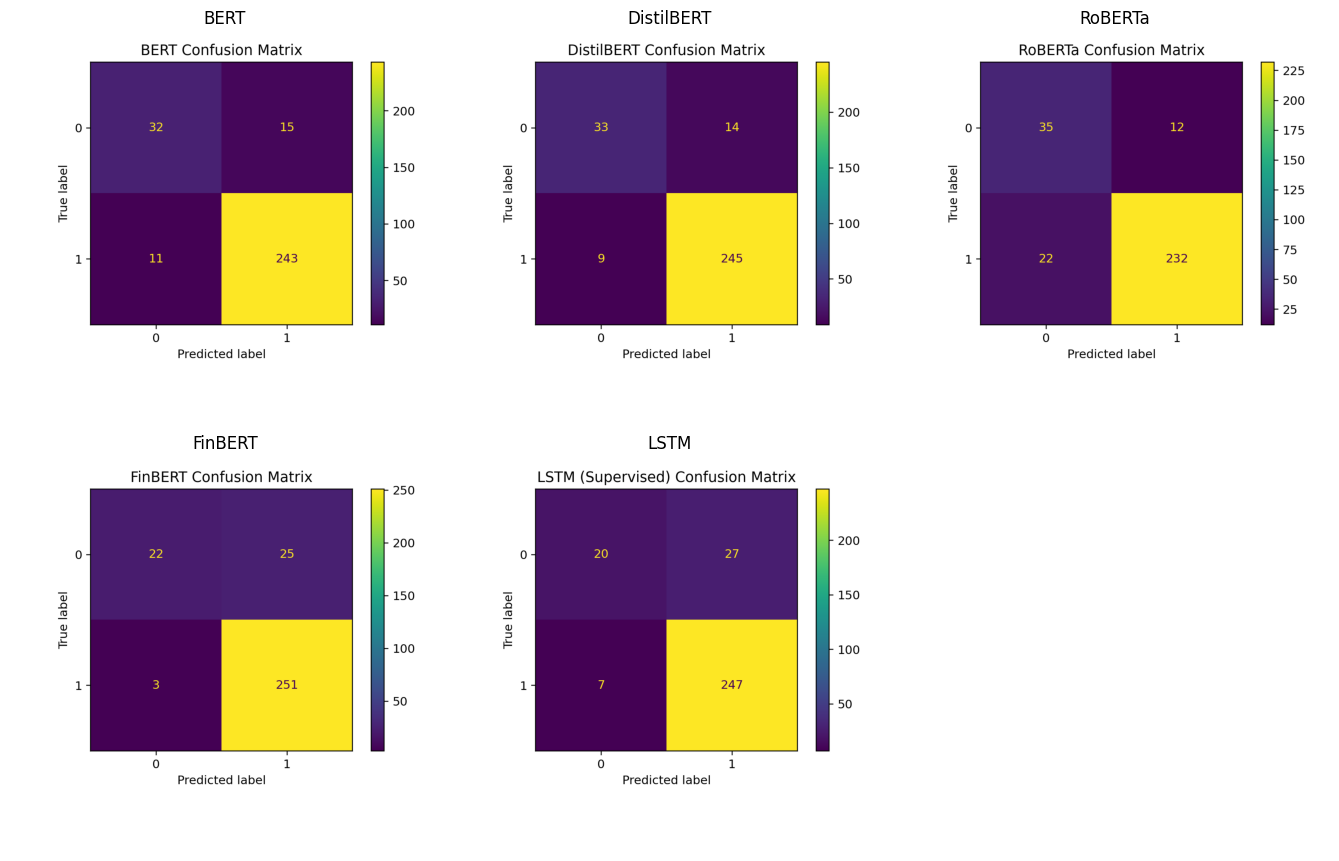

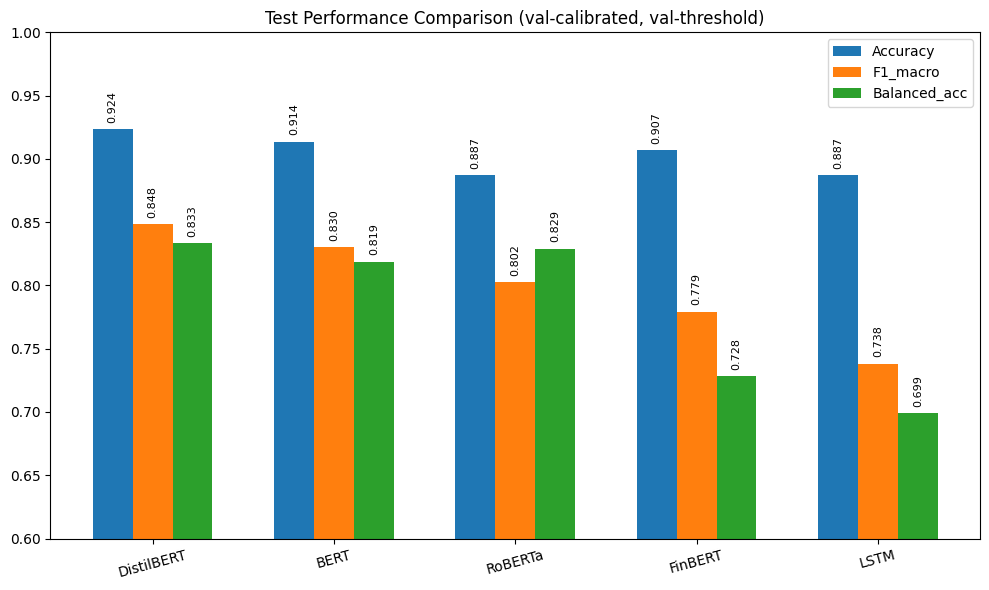

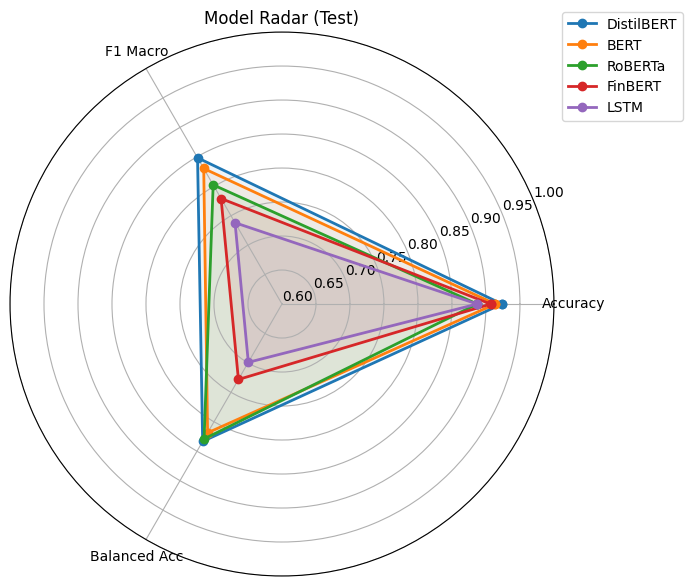


✅ Plots saved to: ./repro_run/figures
📦 Zip created: ./repro_run/figures_bundle.zip


In [2]:
# ======================= PLOT ALL FIGURES FROM SAVED ARTIFACTS =======================
import os, glob, io, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "./repro_run"
FIGDIR = os.path.join(OUTDIR, "figures")
os.makedirs(FIGDIR, exist_ok=True)

MODELS = ["BERT","DistilBERT","RoBERTa","FinBERT","LSTM"]

def _safe_read_csv(path):
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception as e:
            print(f"[warn] failed to read {path}: {e}")
    else:
        print(f"[warn] missing {path}")
    return None

# ---------- 1) Per-model epoch histories ----------
for m in MODELS:
    hist_train = _safe_read_csv(os.path.join(OUTDIR, f"history_{m}_train.csv"))
    hist_val   = _safe_read_csv(os.path.join(OUTDIR, f"history_{m}_val.csv"))
    # LSTM supervised used unified history_LSTM.csv
    if m == "LSTM" and hist_train is None and hist_val is None:
        hist = _safe_read_csv(os.path.join(OUTDIR, "history_LSTM.csv"))
        if hist is not None:
            # Plot LSTM: train loss + val F1macro & threshold
            fig, axes = plt.subplots(2,1, figsize=(8,8), sharex=True)
            axes[0].plot(hist["epoch"], hist["train_loss"], label="Train Loss")
            axes[0].set_ylabel("Loss"); axes[0].set_title("LSTM — Train Loss per Epoch"); axes[0].legend()
            axes[1].plot(hist["epoch"], hist["val_f1_macro"], label="Val F1 (macro)")
            axes[1].plot(hist["epoch"], hist["val_threshold"], label="Val Threshold")
            axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Score / Thr"); axes[1].set_title("LSTM — Val F1 & Threshold"); axes[1].legend()
            plt.tight_layout()
            fpath = os.path.join(FIGDIR, f"history_{m}.png")
            plt.savefig(fpath, dpi=220); plt.show(); plt.close(fig)
        continue

    # Transformers
    if hist_train is not None or hist_val is not None:
        fig, axes = plt.subplots(2,1, figsize=(8,8), sharex=True)
        if hist_train is not None and "epoch_train" in hist_train and "train_loss" in hist_train:
            axes[0].plot(hist_train["epoch_train"], hist_train["train_loss"], label="Train Loss")
        if hist_val is not None and "epoch_val" in hist_val and "val_loss" in hist_val:
            axes[0].plot(hist_val["epoch_val"], hist_val["val_loss"], label="Val Loss")
        axes[0].set_ylabel("Loss"); axes[0].set_title(f"{m} — Loss per Epoch"); axes[0].legend()

        if hist_val is not None:
            if "val_accuracy" in hist_val: axes[1].plot(hist_val["epoch_val"], hist_val["val_accuracy"], label="Val Acc")
            if "val_f1_weighted" in hist_val: axes[1].plot(hist_val["epoch_val"], hist_val["val_f1_weighted"], label="Val F1 (weighted)")
            if "val_f1_macro" in hist_val: axes[1].plot(hist_val["epoch_val"], hist_val["val_f1_macro"], label="Val F1 (macro)")
        axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Score"); axes[1].set_title(f"{m} — Val Metrics"); axes[1].legend()

        plt.tight_layout()
        fpath = os.path.join(FIGDIR, f"history_{m}.png")
        plt.savefig(fpath, dpi=220); plt.show(); plt.close(fig)

# ---------- 2) Combined curves across models (Val F1-macro / Val Loss / Train Loss) ----------
def _collect_val_curve(metric_key):
    curves = {}
    for m in MODELS:
        hv = _safe_read_csv(os.path.join(OUTDIR, f"history_{m}_val.csv"))
        if hv is not None and metric_key in hv and "epoch_val" in hv:
            curves[m] = (hv["epoch_val"].values, hv[metric_key].values)
    return curves

def _collect_train_curve(metric_key):
    curves = {}
    for m in MODELS:
        ht = _safe_read_csv(os.path.join(OUTDIR, f"history_{m}_train.csv"))
        if ht is not None and metric_key in ht:
            # transformers: epoch_train column; LSTM uses different file
            ep_col = "epoch_train" if "epoch_train" in ht else "epoch"
            curves[m] = (ht[ep_col].values, ht[metric_key].values)
    # LSTM special case
    if "LSTM" not in curves:
        hl = _safe_read_csv(os.path.join(OUTDIR, "history_LSTM.csv"))
        if hl is not None and metric_key in hl:
            curves["LSTM"] = (hl["epoch"].values, hl[metric_key].values)
    return curves

# Val F1-macro
curves_f1m = _collect_val_curve("val_f1_macro")
if curves_f1m:
    fig = plt.figure(figsize=(9,6))
    for m,(ep,ys) in curves_f1m.items():
        plt.plot(ep, ys, label=m)
    plt.xlabel("Epoch"); plt.ylabel("F1-macro (val)"); plt.title("Validation F1-macro — All Models"); plt.legend()
    p = os.path.join(FIGDIR, "combined_val_f1_macro.png")
    plt.tight_layout(); plt.savefig(p, dpi=220); plt.show(); plt.close(fig)

# Val Loss
curves_vloss = _collect_val_curve("val_loss")
if curves_vloss:
    fig = plt.figure(figsize=(9,6))
    for m,(ep,ys) in curves_vloss.items():
        plt.plot(ep, ys, label=m)
    plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Validation Loss — Transformers"); plt.legend()
    p = os.path.join(FIGDIR, "combined_val_loss.png")
    plt.tight_layout(); plt.savefig(p, dpi=220); plt.show(); plt.close(fig)

# Train Loss
curves_tloss = _collect_train_curve("train_loss")
if curves_tloss:
    fig = plt.figure(figsize=(9,6))
    for m,(ep,ys) in curves_tloss.items():
        plt.plot(ep, ys, label=m)
    plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Train Loss — All Models"); plt.legend()
    p = os.path.join(FIGDIR, "combined_train_loss.png")
    plt.tight_layout(); plt.savefig(p, dpi=220); plt.show(); plt.close(fig)

# ---------- 3) Confusion matrices montage ----------
cm_paths = []
for m in MODELS:
    name = f"cm_{m}.png" if m != "LSTM" else "cm_LSTM.png"
    p = os.path.join(OUTDIR, name)
    if os.path.exists(p): cm_paths.append((m, p))

if cm_paths:
    import matplotlib.image as mpimg
    cols = 3
    rows = int(np.ceil(len(cm_paths)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4.5, rows*4.5))
    if rows == 1: axes = np.array([axes])
    for i,(m,p) in enumerate(cm_paths):
        r,c = divmod(i, cols)
        img = mpimg.imread(p)
        axes[r,c].imshow(img); axes[r,c].axis("off"); axes[r,c].set_title(m)
    # hide empty slots
    for k in range(len(cm_paths), rows*cols):
        r,c = divmod(k, cols)
        axes[r,c].axis("off")
    plt.tight_layout()
    outp = os.path.join(FIGDIR, "confusion_matrices_montage.png")
    plt.savefig(outp, dpi=220); plt.show(); plt.close(fig)

# ---------- 4) (Re)generate bars & radar from final_metrics.csv if needed ----------
def plot_bars(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png"):
    plt.figure(figsize=(10,6))
    x = np.arange(len(df))
    width = 0.22
    for i, met in enumerate(metrics):
        plt.bar(x+i*width, df[met].values, width, label=met.capitalize())
        for j, v in enumerate(df[met].values):
            plt.text(j+i*width, v+0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.xticks(x+width, df["model"].values, rotation=15)
    plt.ylim(0.6, 1.0)
    plt.title("Test Performance Comparison (val-calibrated, val-threshold)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=220); plt.show(); plt.close()

def plot_radar(df, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png"):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for _, row in df.iterrows():
        vals = [row[m] for m in metrics] + [row[metrics[0]]]
        ax.plot(angles, vals, marker='o', linewidth=2, label=row["model"])
        ax.fill(angles, vals, alpha=0.08)
    ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace("_"," ").title() for m in metrics])
    ax.set_ylim(0.6, 1.0)
    ax.set_title("Model Radar (Test)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1.05))
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=220); plt.show(); plt.close()

fm_path = os.path.join(OUTDIR, "final_metrics.csv")
if os.path.exists(fm_path):
    dfm = pd.read_csv(fm_path)
    # sort by f1_macro for nicer view
    df_plot = dfm.sort_values("f1_macro", ascending=False)
    plot_bars(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_bars.png")
    plot_radar(df_plot, metrics=("accuracy","f1_macro","balanced_acc"), fname="comparison_radar.png")
else:
    print(f"[warn] {fm_path} not found; skipping bars/radar.")

# ---------- 5) Zip all figures + key CSVs ----------
zip_path = os.path.join(OUTDIR, "figures_bundle.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    # figures
    for p in glob.glob(os.path.join(FIGDIR, "*.png")):
        zf.write(p, arcname=os.path.join("figures", os.path.basename(p)))
    # histories
    for p in glob.glob(os.path.join(OUTDIR, "history_*.csv")):
        zf.write(p, arcname=os.path.basename(p))
    # metrics + CMs + comparison plots saved by training
    for p in glob.glob(os.path.join(OUTDIR, "cm_*.png")) + \
             glob.glob(os.path.join(OUTDIR, "comparison_*.png")) + \
             [fm_path] if os.path.exists(fm_path) else []:
        if os.path.exists(p):
            zf.write(p, arcname=os.path.basename(p))

print(f"\n✅ Plots saved to: {FIGDIR}")
print(f"📦 Zip created: {zip_path}")
# ======================= END =======================
